In [1]:
import theano
import numpy as np

import joblib

from braindecode.veganlasagne.layer_util import print_layers
from braindecode.analysis.plot_util import plot_head_signals_tight,plot_head_signals_tight_with_tube
from braindecode.datasets.sensor_positions import tight_cap_positions
import lasagne
import scipy

import os

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5005)


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import convvisual.receptive_field.receptive_field as receptive_field
import convvisual.analysis.analysis as analysis
import convvisual.analysis.utils as utils
import convvisual.analysis.plot as plot

/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
modelpath = '/home/hartmank/braindecode/data/models/'
modelname = 'paper/ours/cnt/deep4/car/22'
savepath  = '/home/hartmank/data/convvisual/RF_data/'

In [6]:
import os
n_class_inputs = 50
max_baseline_inputs = 2500 # Number of signal windows used for baseline
wins_per_input = 3
fig_h = 60

In [7]:
def make_data(RF_Result,n_chans):   
    feature_funcs = [analysis.get_frequency]
    
    RF_Result.max_filters = RF_Result.max_filters
    c = False
    
    for i,filt in enumerate(RF_Result.max_filters):
        X_RF_cropped = utils.get_RF(RF_Result,i,n_chans)[:n_class_inputs]
        if not c:
            X_baseline = utils.cut_baseline(RF_Data.inputs,wins_per_input,X_RF_cropped.shape)[:max_baseline_inputs]
            FFT_base = utils.get_feature_vals(X_baseline,feature_funcs,sampling_rate=sampling_rate)[0]
            Phase_base = np.angle(FFT_base)[:,:,1:]
            FFT_base = analysis.real_frequency(FFT_base)
            
            frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
            frequencies = frequencies[:frequencies.shape[0]/2].astype(str)
            
            FFT_diff = np.zeros((len(frequencies),len(RF_Result.max_filters)))
            FFT_KS = np.zeros((len(frequencies),len(RF_Result.max_filters)))
            Phase_diff = np.zeros((len(frequencies)-1,len(RF_Result.max_filters)))
            Phase_KS = np.zeros((len(frequencies)-1,len(RF_Result.max_filters)))
            Electrode_KS = np.zeros((FFT_base.shape[1],len(RF_Result.max_filters)))
            Electrode_KS_max = np.zeros((FFT_base.shape[1],len(RF_Result.max_filters)))
            c = True
        
        FFT_filt = utils.get_feature_vals(X_RF_cropped,feature_funcs,sampling_rate=sampling_rate)[0]
        Phase_filt = np.angle(FFT_filt)[:,:,1:]
        FFT_filt = analysis.real_frequency(FFT_filt)
        
        FFT_KS_,_ = utils.feat_diff_KS(FFT_filt.reshape((FFT_filt.shape[0],-1)),FFT_base.reshape((FFT_base.shape[0],-1)))
        Phase_KS_,_ = utils.feat_diff_KS(Phase_filt.reshape((Phase_filt.shape[0],-1)),Phase_base.reshape((Phase_base.shape[0],-1)))
                
        FFT_KS_ = FFT_KS_.reshape(FFT_filt.shape[1:])
        Phase_KS_ = Phase_KS_.reshape(Phase_filt.shape[1:])
        
        Electrode_KS[:,i] = (FFT_KS_.mean(axis=1)+Phase_KS_.mean(axis=1))/2
        
        
        Electrode_KS_max[:,i] = np.maximum(FFT_KS_.max(axis=1),Phase_KS_.max(axis=1))
            
        FFT_KS[:,i] = FFT_KS_.mean(axis=0)
        Phase_KS[:,i] = Phase_KS_.mean(axis=0)

        FFT_diff[:,i] = np.mean(np.log2(np.divide(FFT_filt.mean(axis=0),FFT_base.mean(axis=0))),axis=0)
        Phase_diff[:,i] = np.mean(np.log2(np.divide(scipy.stats.circvar(Phase_filt,axis=0),scipy.stats.circvar(Phase_base,axis=0)),axis=0)
                                 
    return FFT_diff,Phase_diff,FFT_KS,Phase_KS,Electrode_KS,Electrode_KS_max,frequencies

In [8]:
def make_plot(FFT_diff,Phase_diff,FFT_KS,Phase_KS,Electrode_KS,Electrode_KS_max,sensor_names,frequencies):
    plt.figure(figsize=(fig_h,fig_h))
    plt.imshow(FFT_diff,interpolation='nearest',aspect='equal',origin='lower',cmap=plt.get_cmap('jet'))
    plt.grid(False)
    plt.colorbar()
    plt.xticks(range(FFT_diff.shape[1]),range(FFT_diff.shape[1]))
    plt.yticks(range(FFT_diff.shape[0]),frequencies)
    plt.ylabel('Frequency')
    plt.xlabel('Filter')
    plt.title('Mean difference of mean amplitude over all electrodes')
    plt.show()
    
    plt.figure(figsize=(fig_h,fig_h))
    plt.imshow(FFT_KS,interpolation='nearest',aspect='equal',origin='lower',vmin=0.1,vmax=0.8,cmap=plt.get_cmap('winter'))
    plt.grid(False)
    plt.colorbar()
    plt.xticks(range(FFT_diff.shape[1]),range(FFT_diff.shape[1]))
    plt.yticks(range(FFT_diff.shape[0]),frequencies)
    plt.ylabel('Frequency')
    plt.xlabel('Filter')
    plt.title('Mean KS Score of amplitude distributions over all electrodes')
    plt.show()
    
    plt.figure(figsize=(fig_h,fig_h))
    plt.imshow(Phase_diff,interpolation='nearest',aspect='equal',origin='lower',cmap=plt.get_cmap('jet'))
    plt.grid(False)
    plt.colorbar()
    plt.xticks(range(Phase_diff.shape[1]),range(Phase_diff.shape[1]))
    plt.yticks(range(Phase_diff.shape[0]),frequencies[1:])
    plt.ylabel('Frequency')
    plt.xlabel('Filter')
    plt.title('Mean difference in phase variance over all electrodes')
    plt.show()
    
    plt.figure(figsize=(fig_h,fig_h))
    plt.imshow(Phase_KS,interpolation='nearest',aspect='equal',origin='lower',vmin=0.1,vmax=0.8,cmap=plt.get_cmap('winter'))
    plt.grid(False)
    plt.colorbar()
    plt.xticks(range(Phase_diff.shape[1]),range(Phase_diff.shape[1]))
    plt.yticks(range(Phase_diff.shape[0]),frequencies[1:])
    plt.ylabel('Frequency')
    plt.xlabel('Filter')
    plt.title('Mean KS Score of phase distribution over all electrodes')
    plt.show()
    
    plt.figure(figsize=(fig_h,fig_h))
    plt.imshow(Electrode_KS.T,interpolation='nearest',aspect='equal',vmin=0.1,vmax=0.8,cmap=plt.get_cmap('winter'))
    plt.grid(False)
    plt.colorbar()
    plt.yticks(range(Phase_diff.shape[1]),range(Phase_diff.shape[1]),fontsize=7)
    plt.xticks(range(128),sensor_names[range(128)],fontsize=7,rotation='vertical')
    plt.xlabel('Electrode')
    plt.ylabel('Filter')
    plt.title('Mean KS Score of Electrodes')
    plt.show()
    
    plt.figure(figsize=(fig_h,fig_h))
    plt.imshow(Electrode_KS_max.T,interpolation='nearest',aspect='equal',vmin=0.1,vmax=0.8,cmap=plt.get_cmap('cool'))
    plt.grid(False)
    plt.colorbar()
    plt.yticks(range(Phase_diff.shape[1]),range(Phase_diff.shape[1]),fontsize=7)
    plt.xticks(range(128),sensor_names[range(128)],fontsize=7,rotation='vertical')
    plt.xlabel('Electrode')
    plt.ylabel('Filter')
    plt.title('Max KS Score of Electrodes')
    plt.show()

### Layer 4

In [9]:
RF_Data = receptive_field.load_ExtractorData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'))
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'),4,None)

n_chans = RF_Data.n_chans
sensor_names = RF_Data.sensor_names
sampling_rate = RF_Data.sampling_rate

In [10]:
FFT_diff,Phase_diff,FFT_KS,Phase_KS,Electrode_KS,Electrode_KS_max,frequencies = make_data(RF_Result,n_chans)


(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (128000,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1]

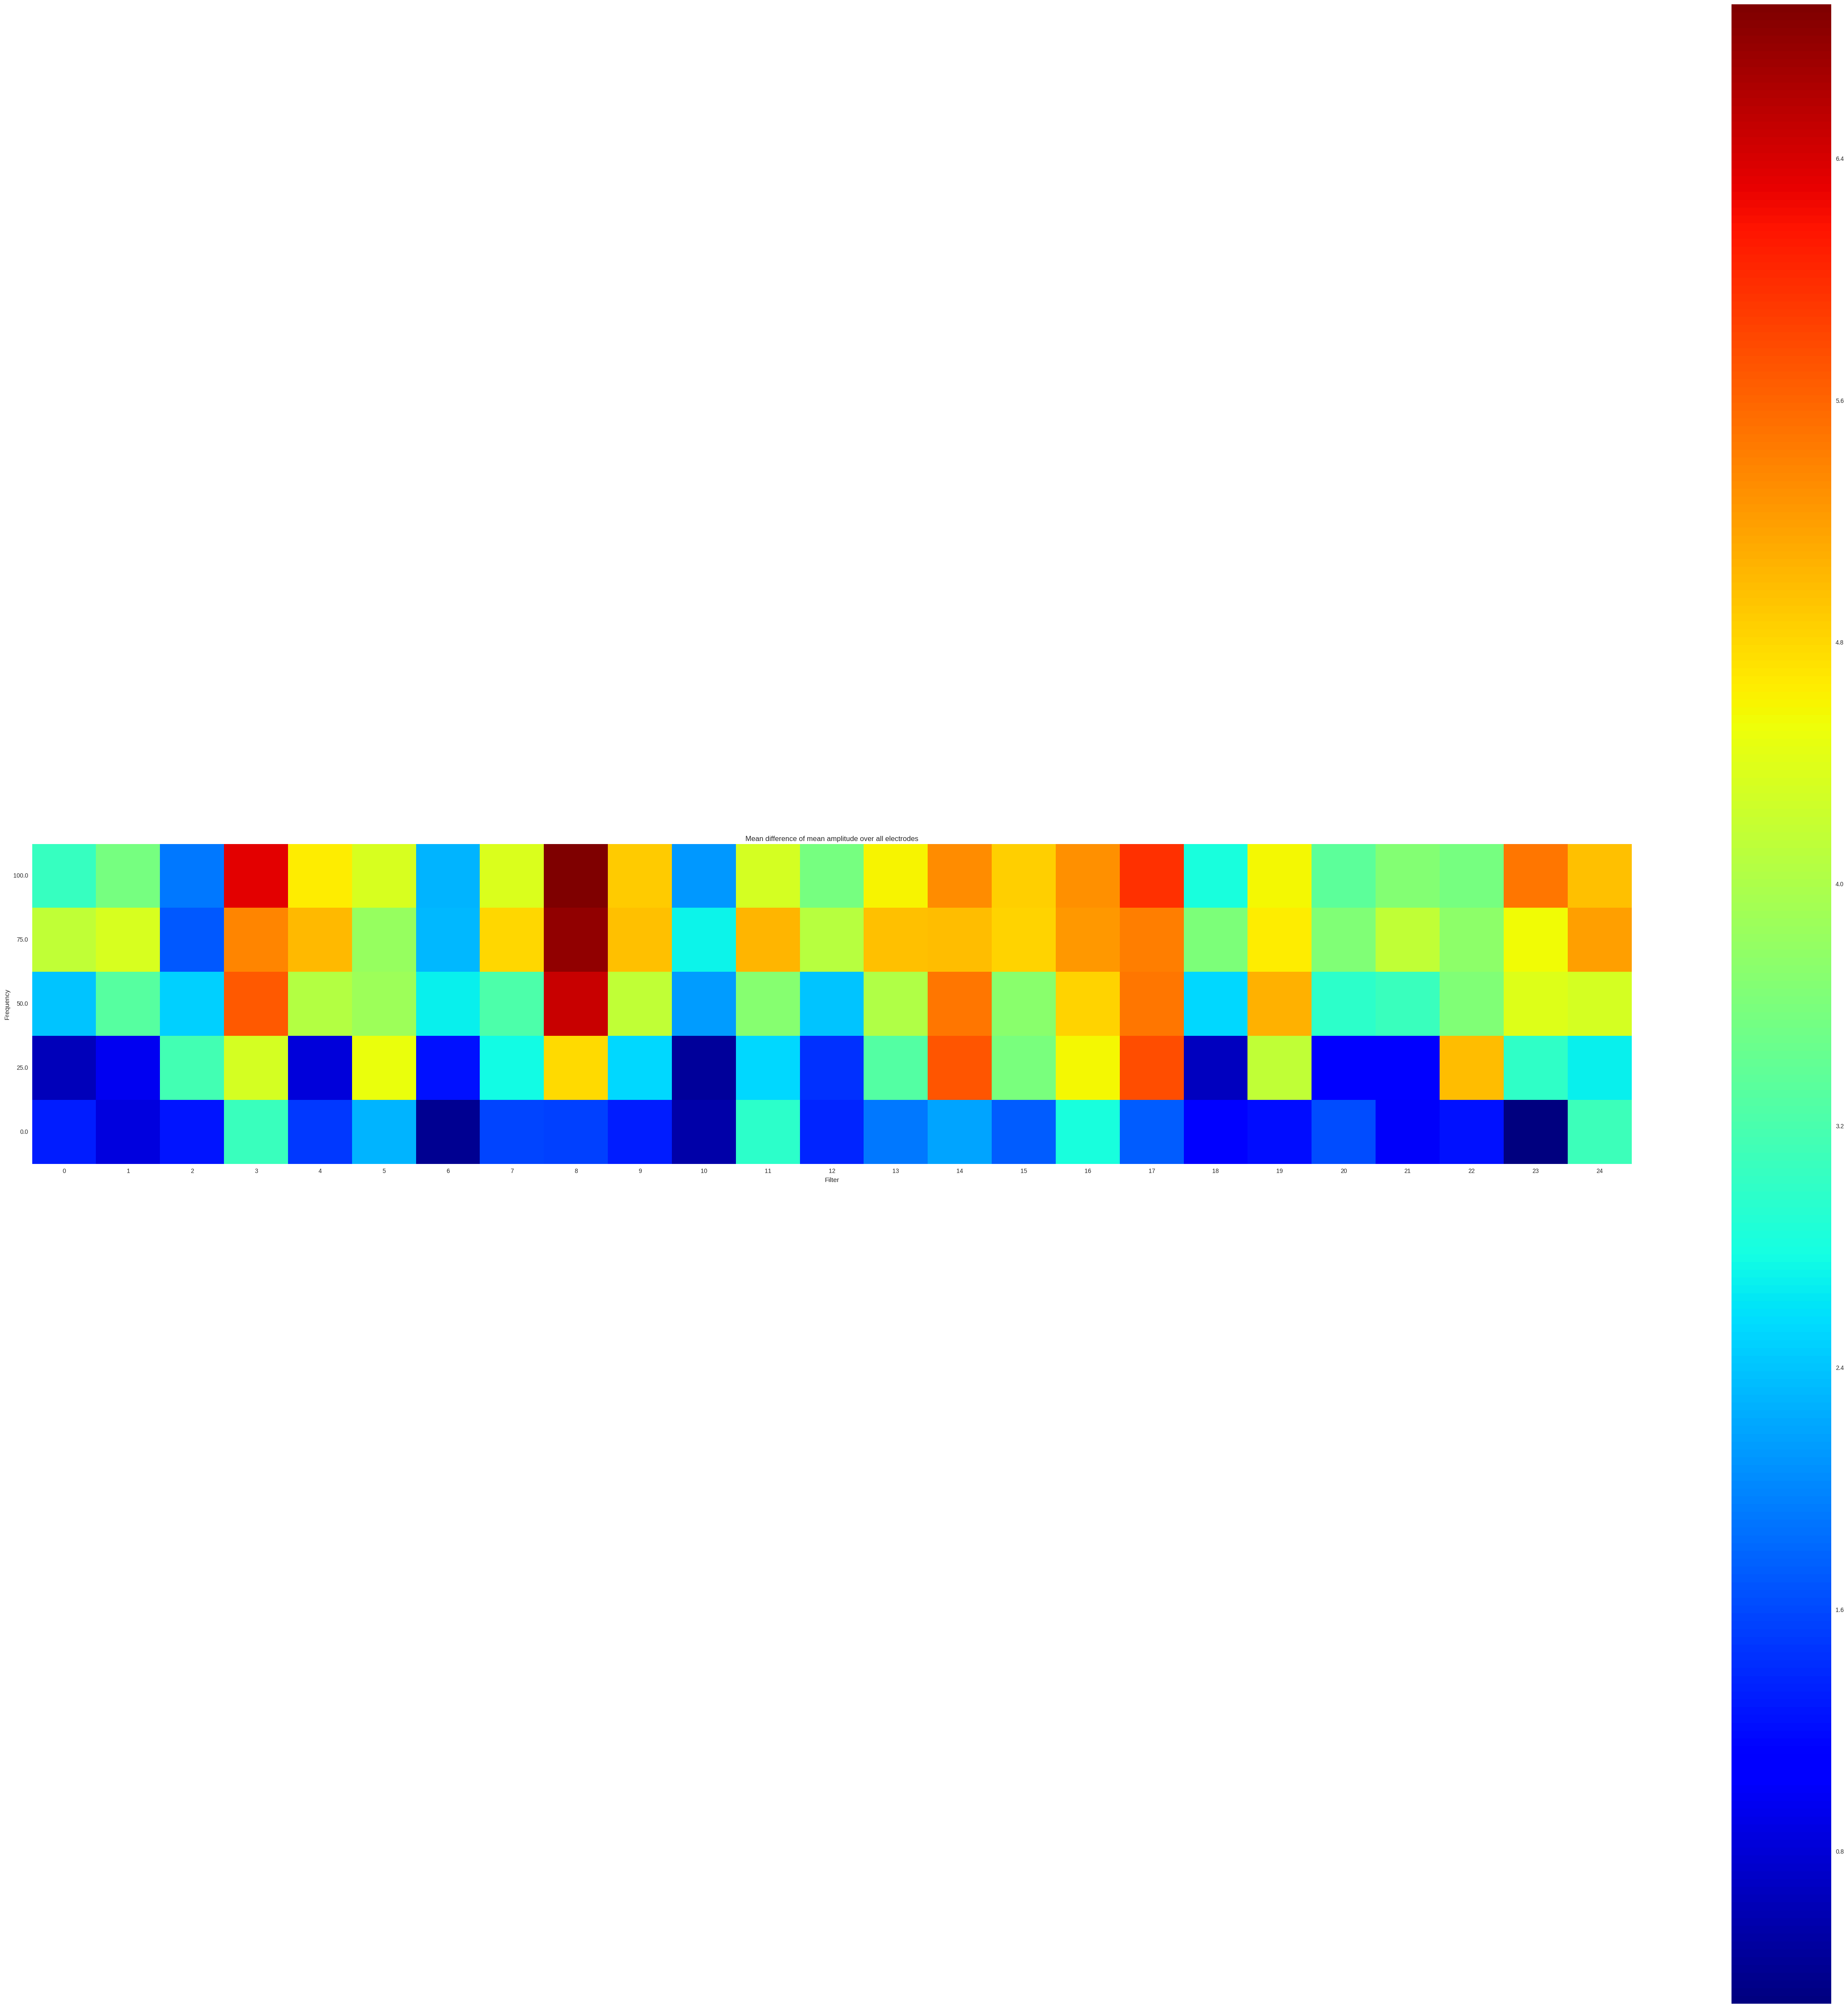

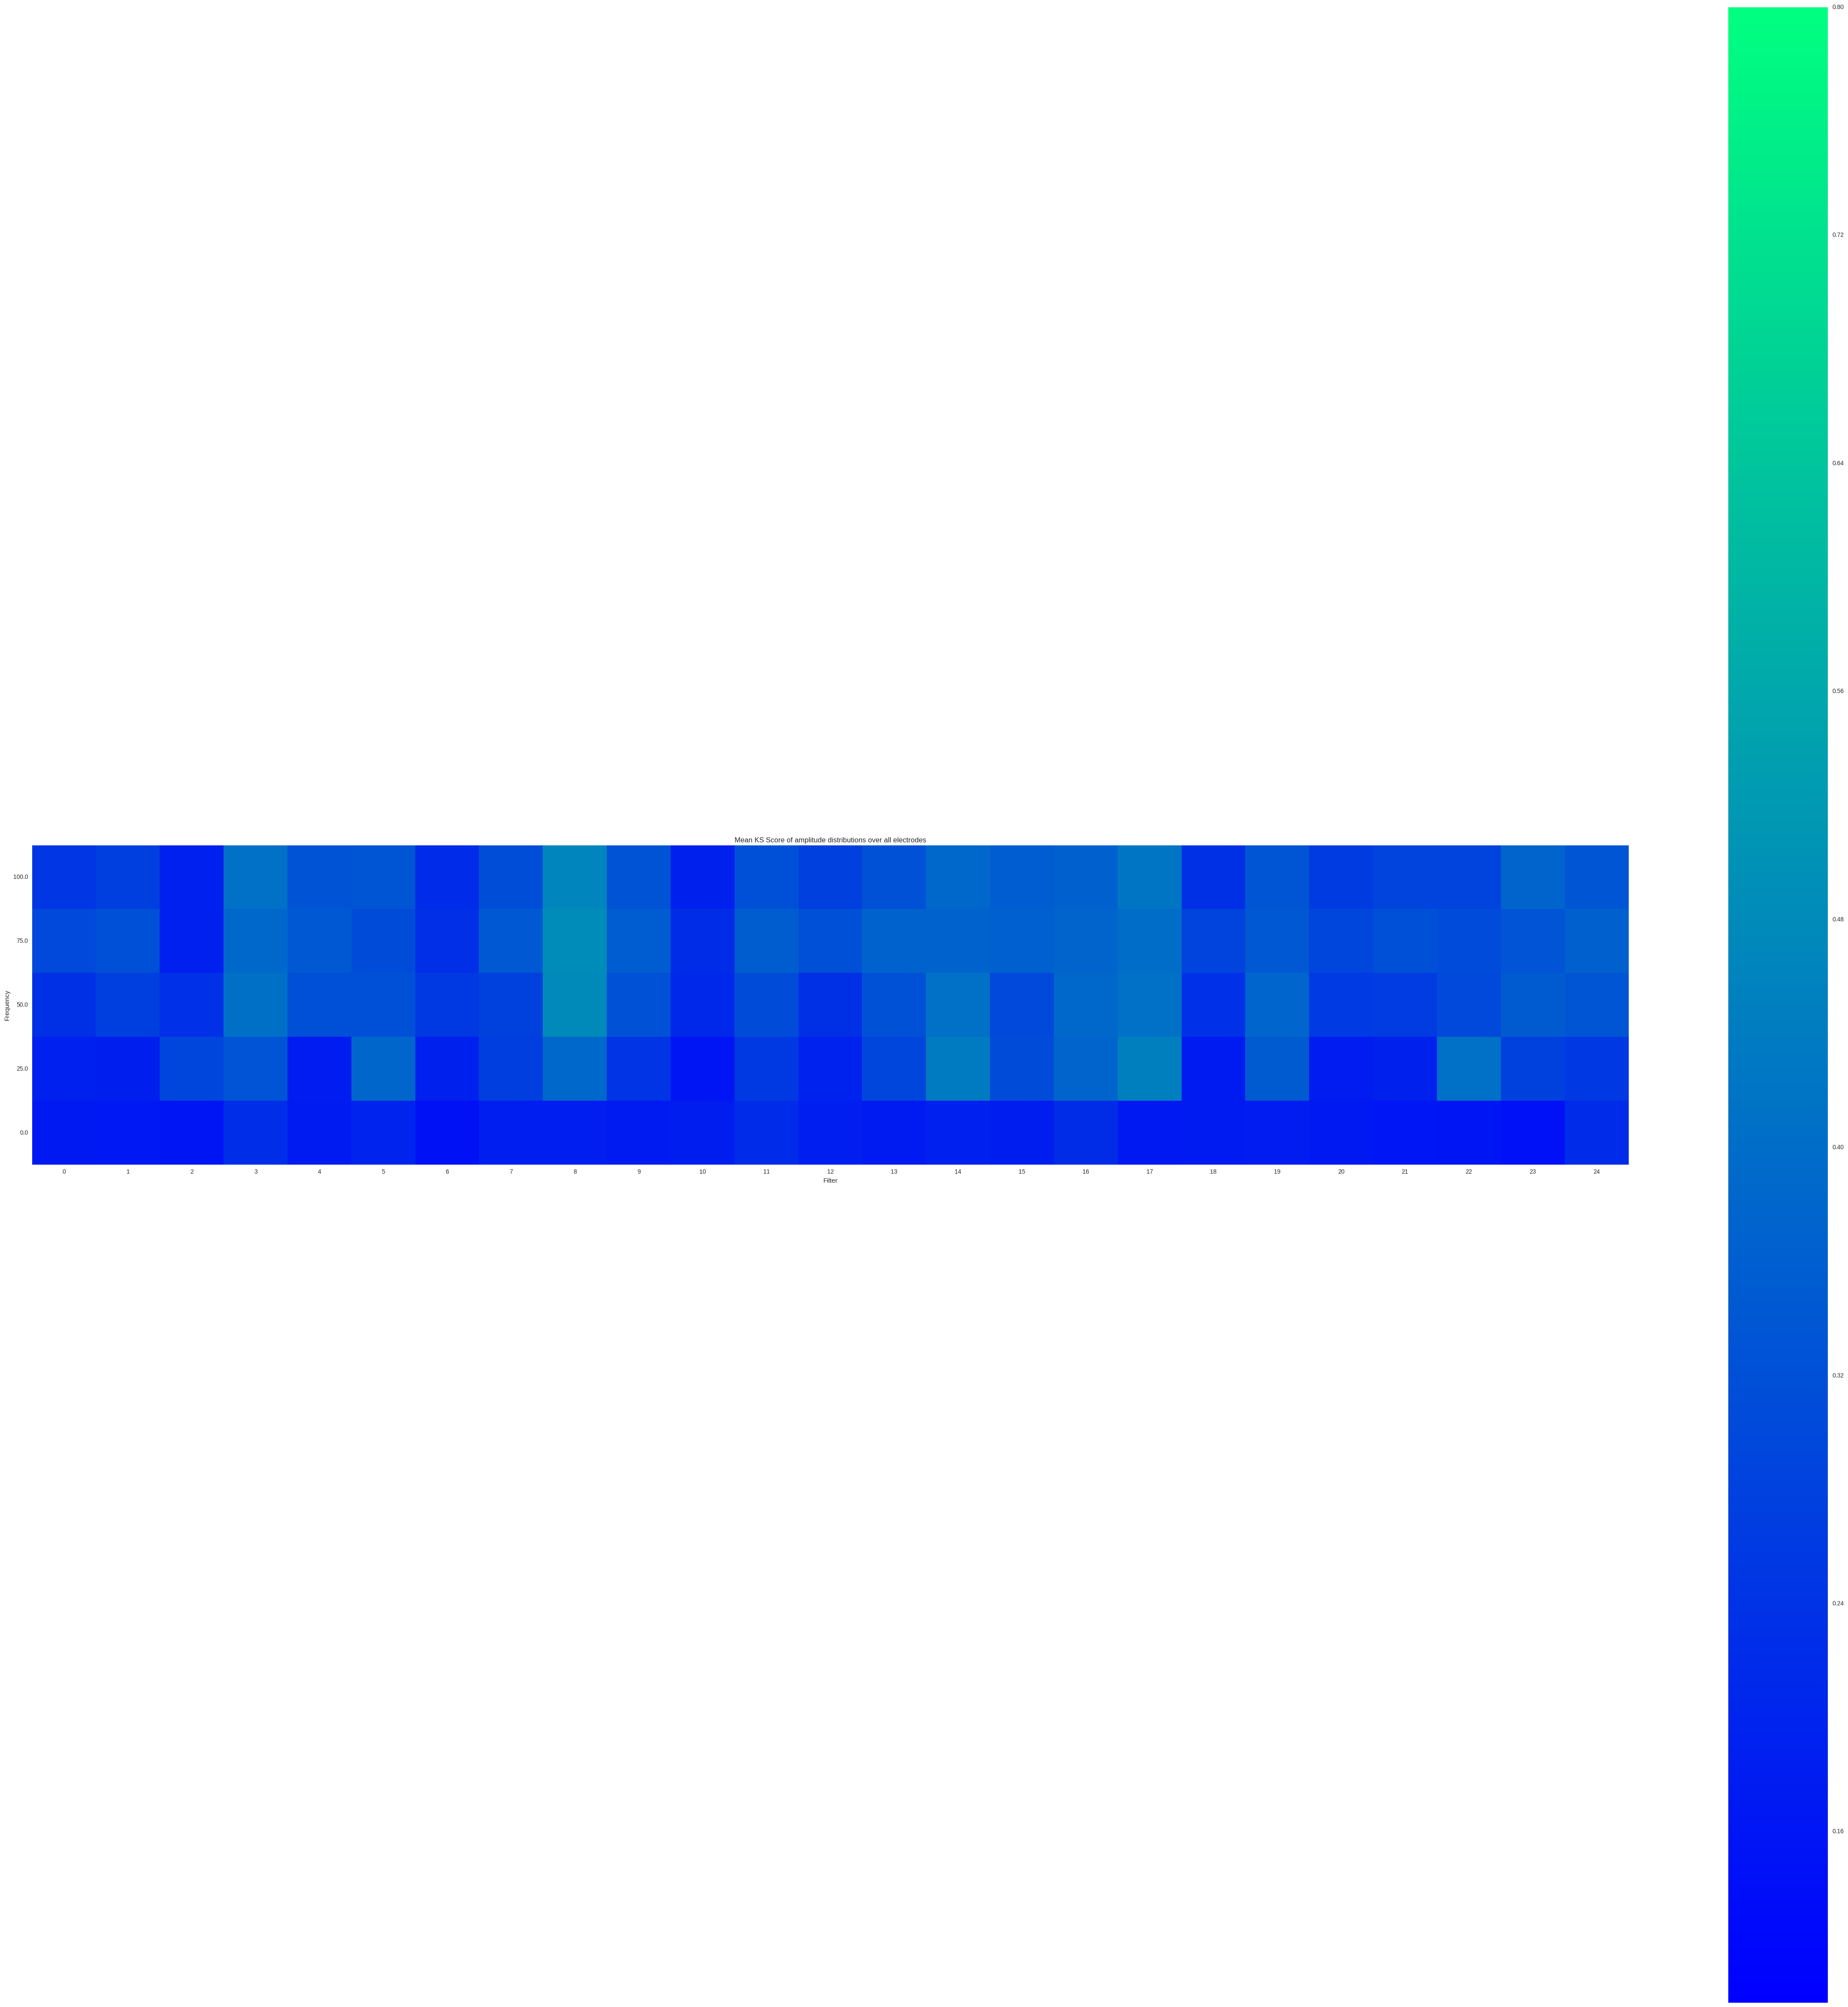

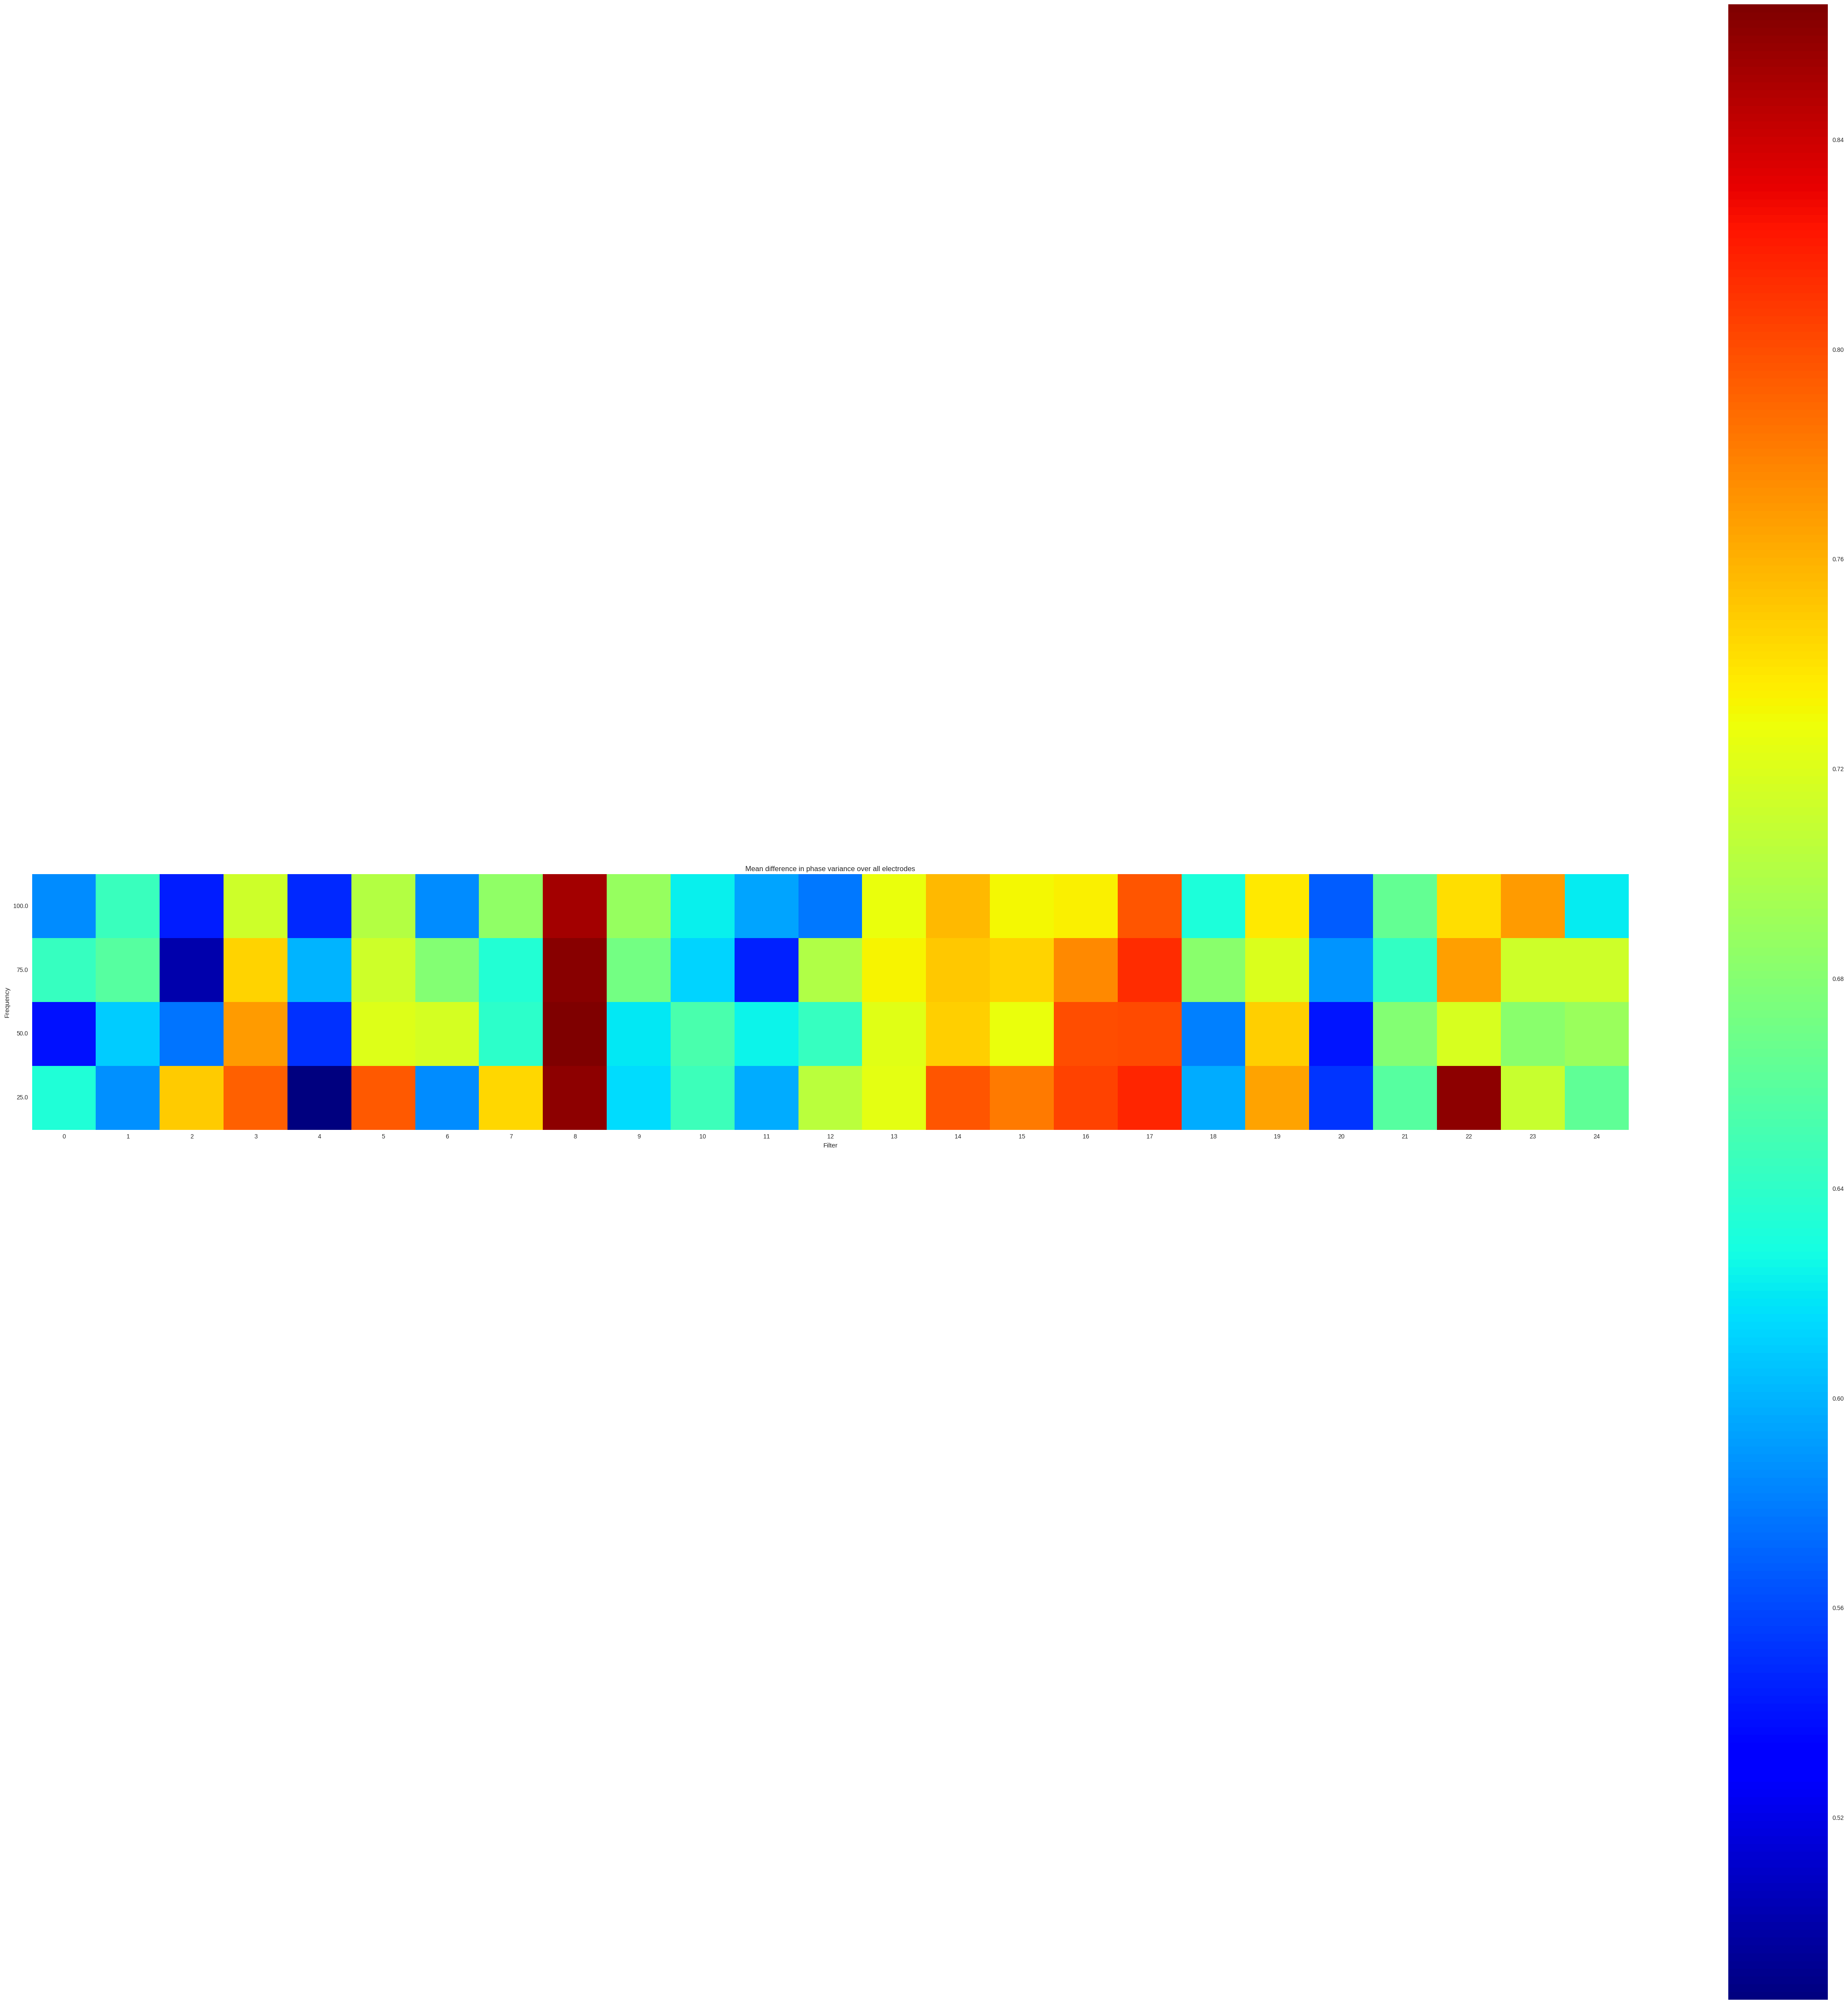

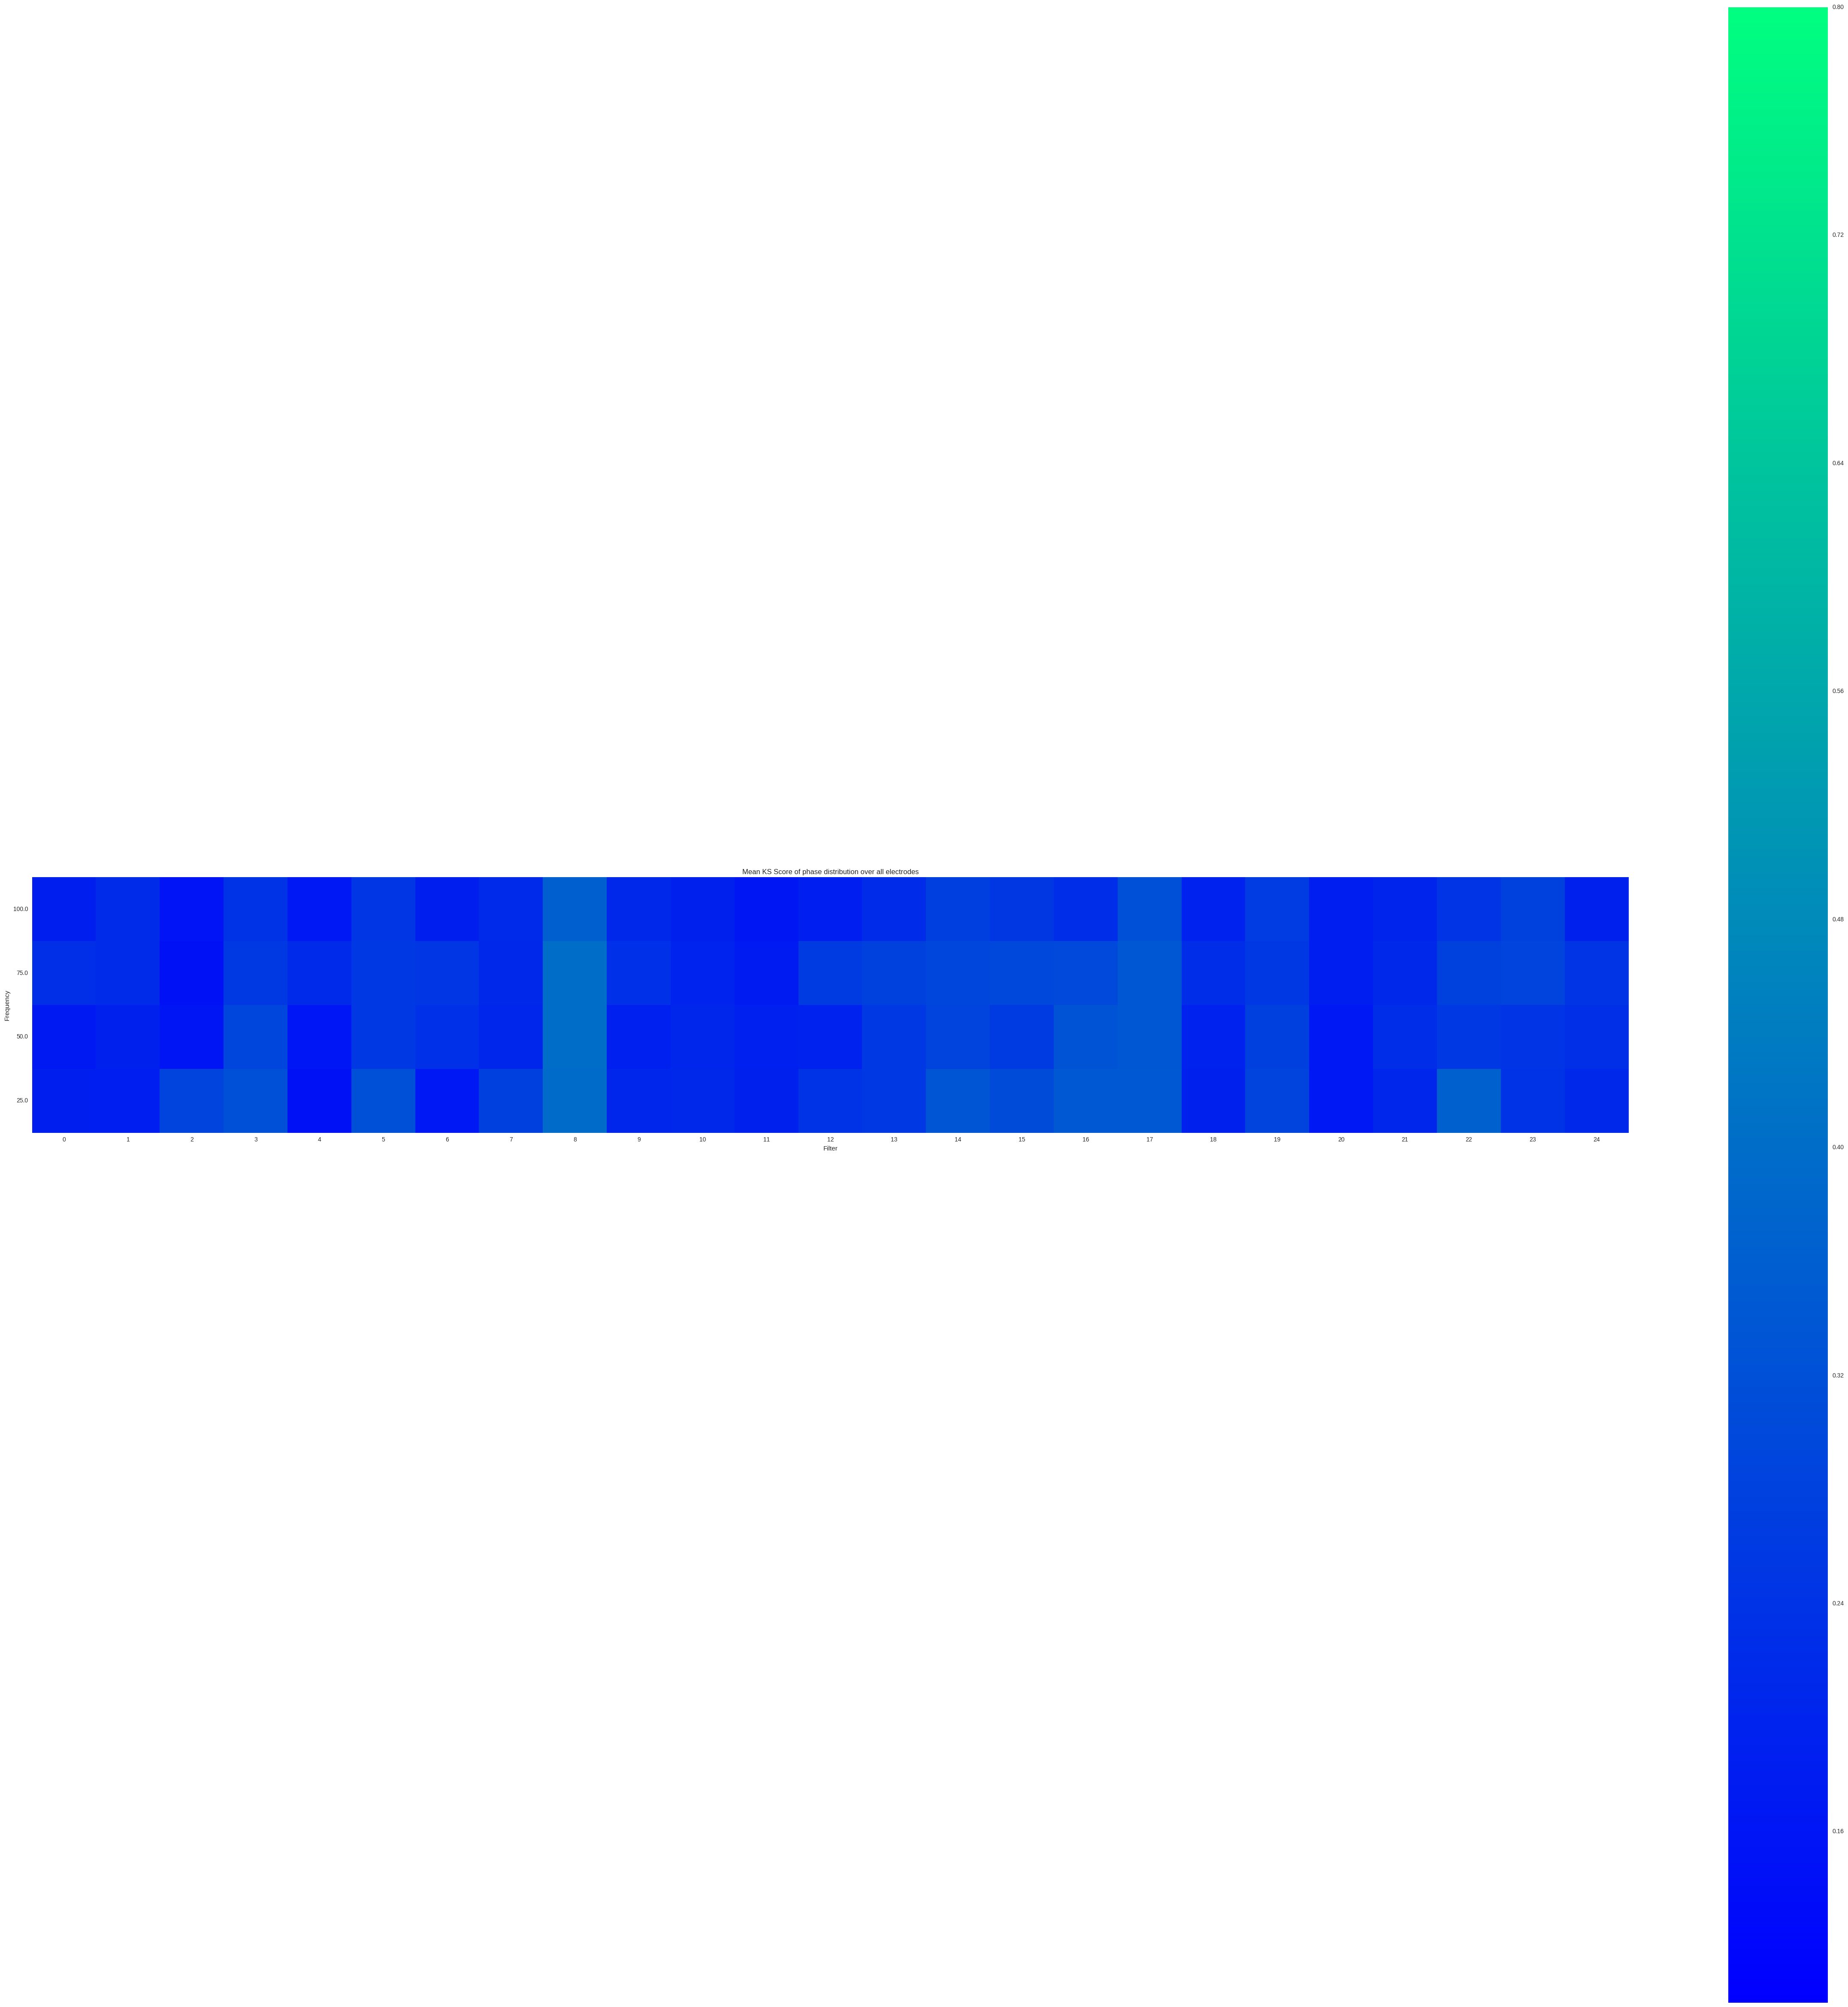

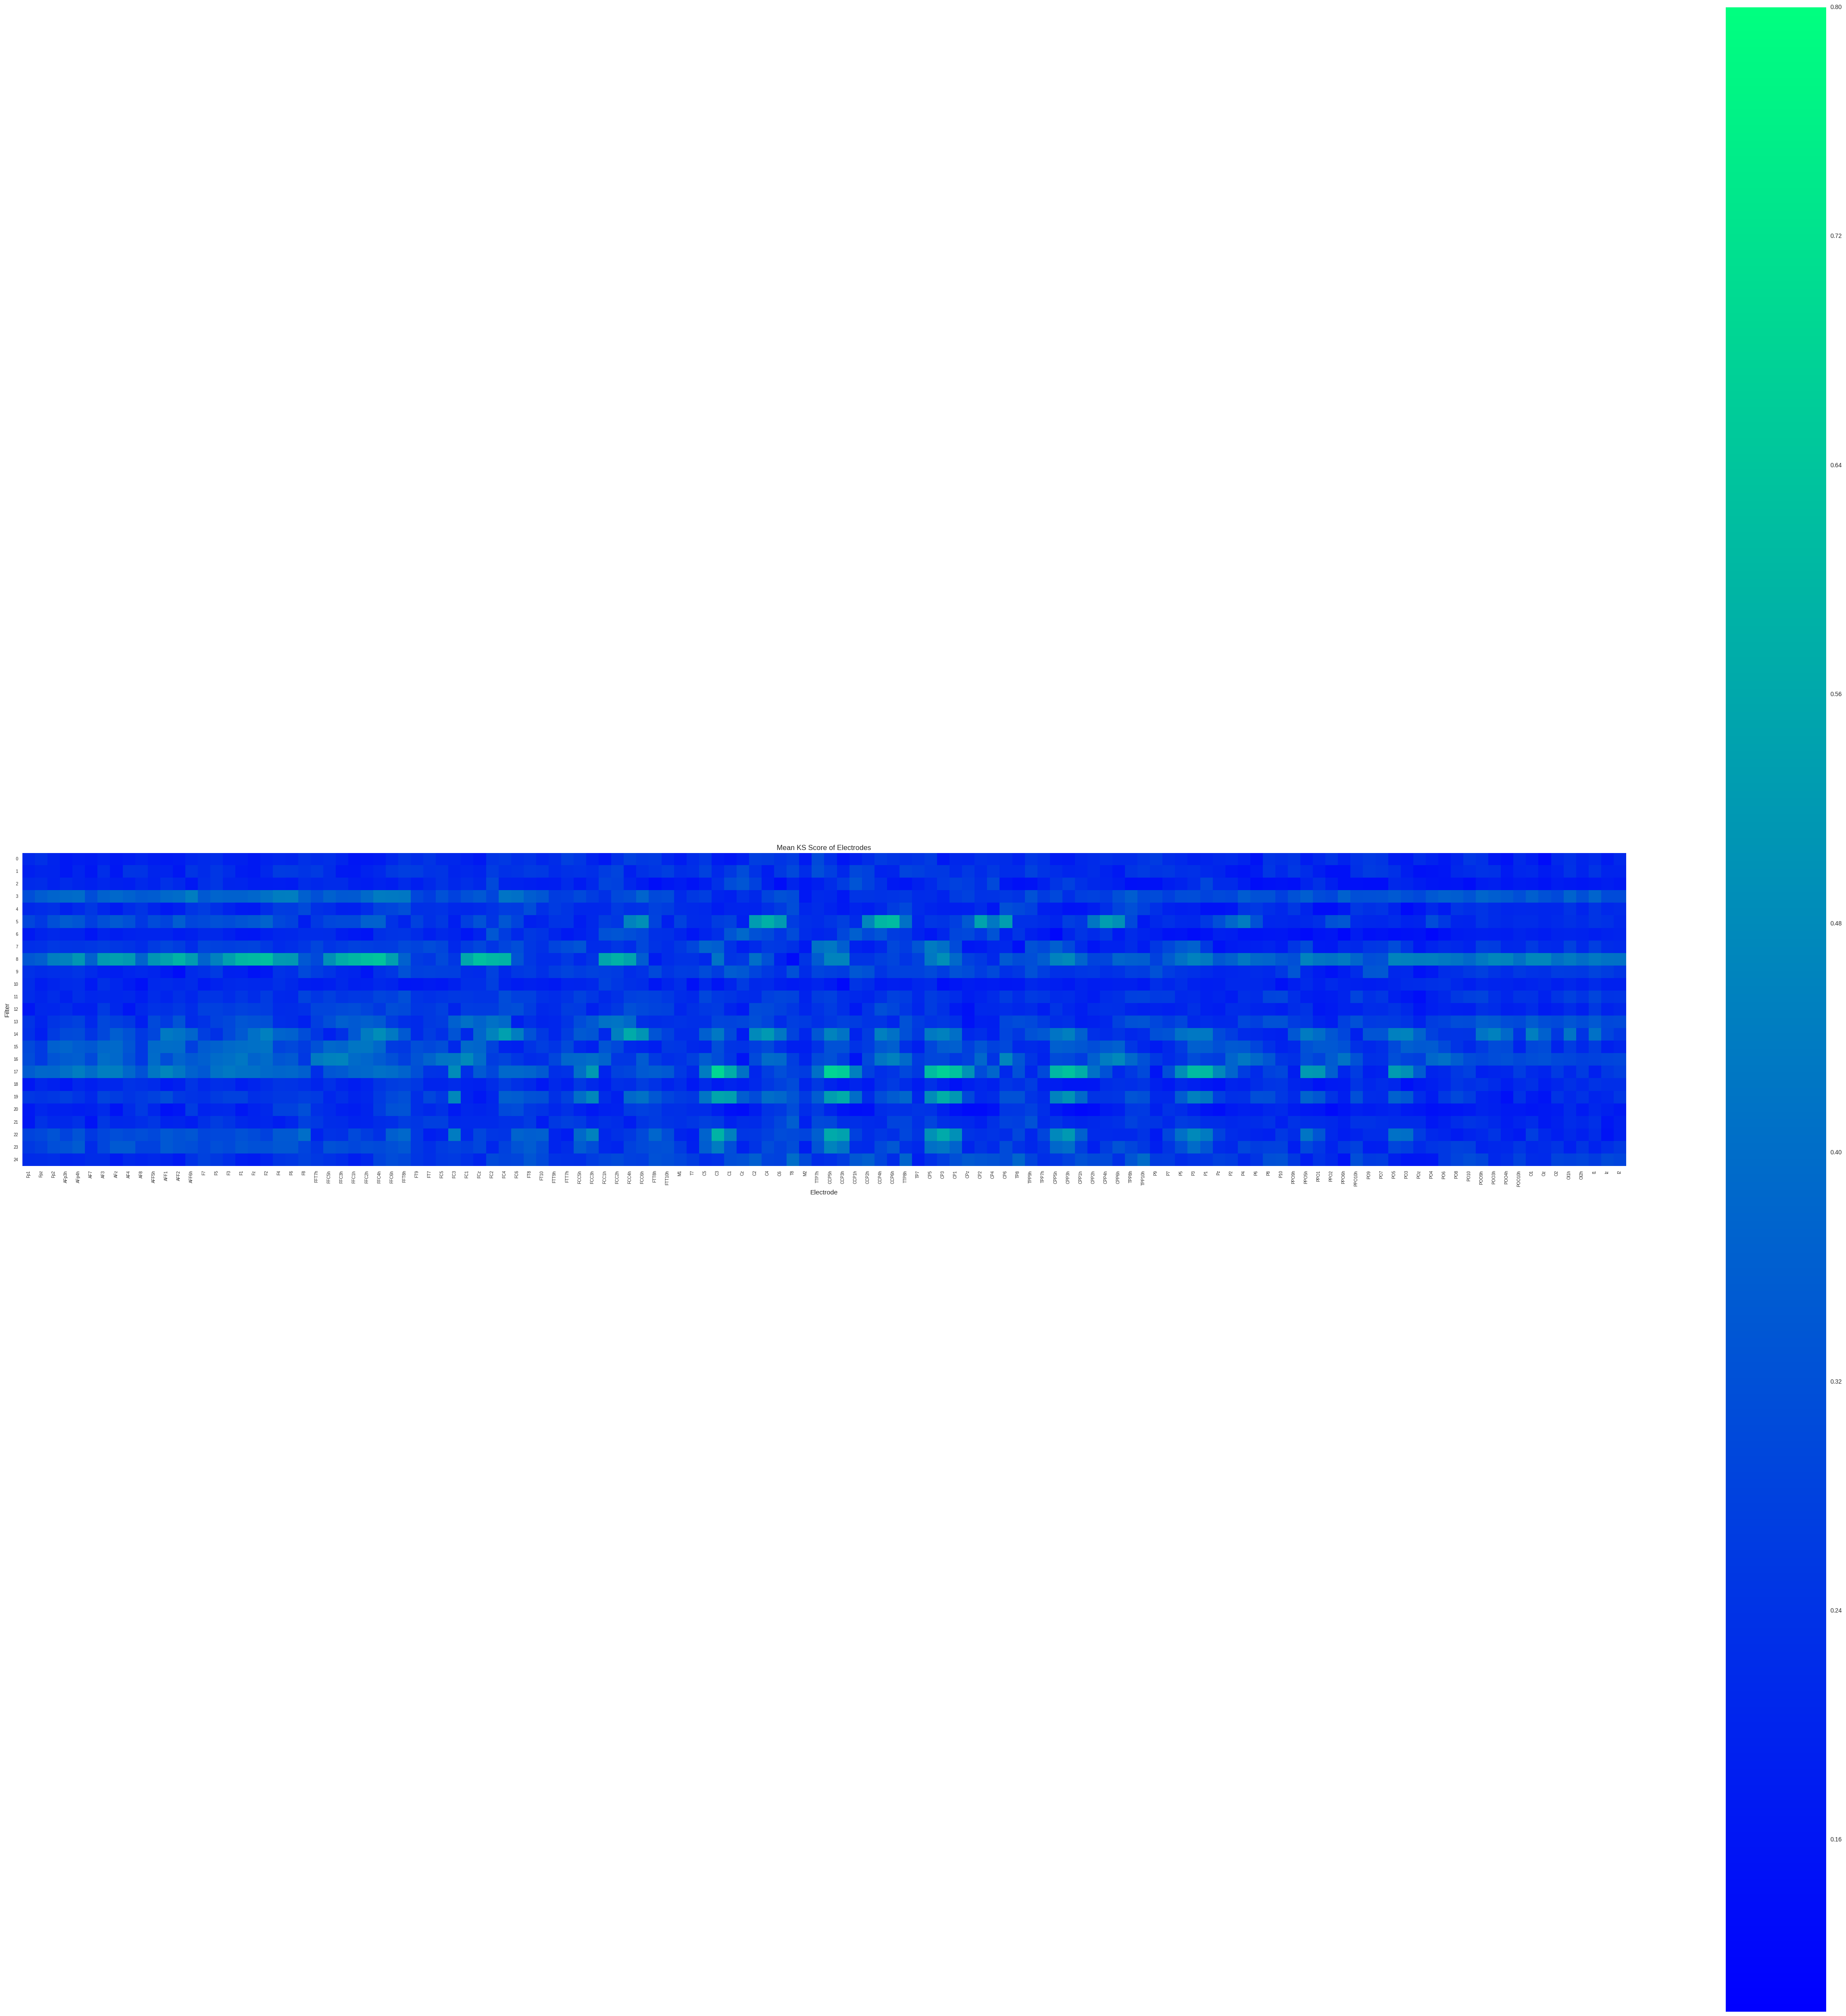

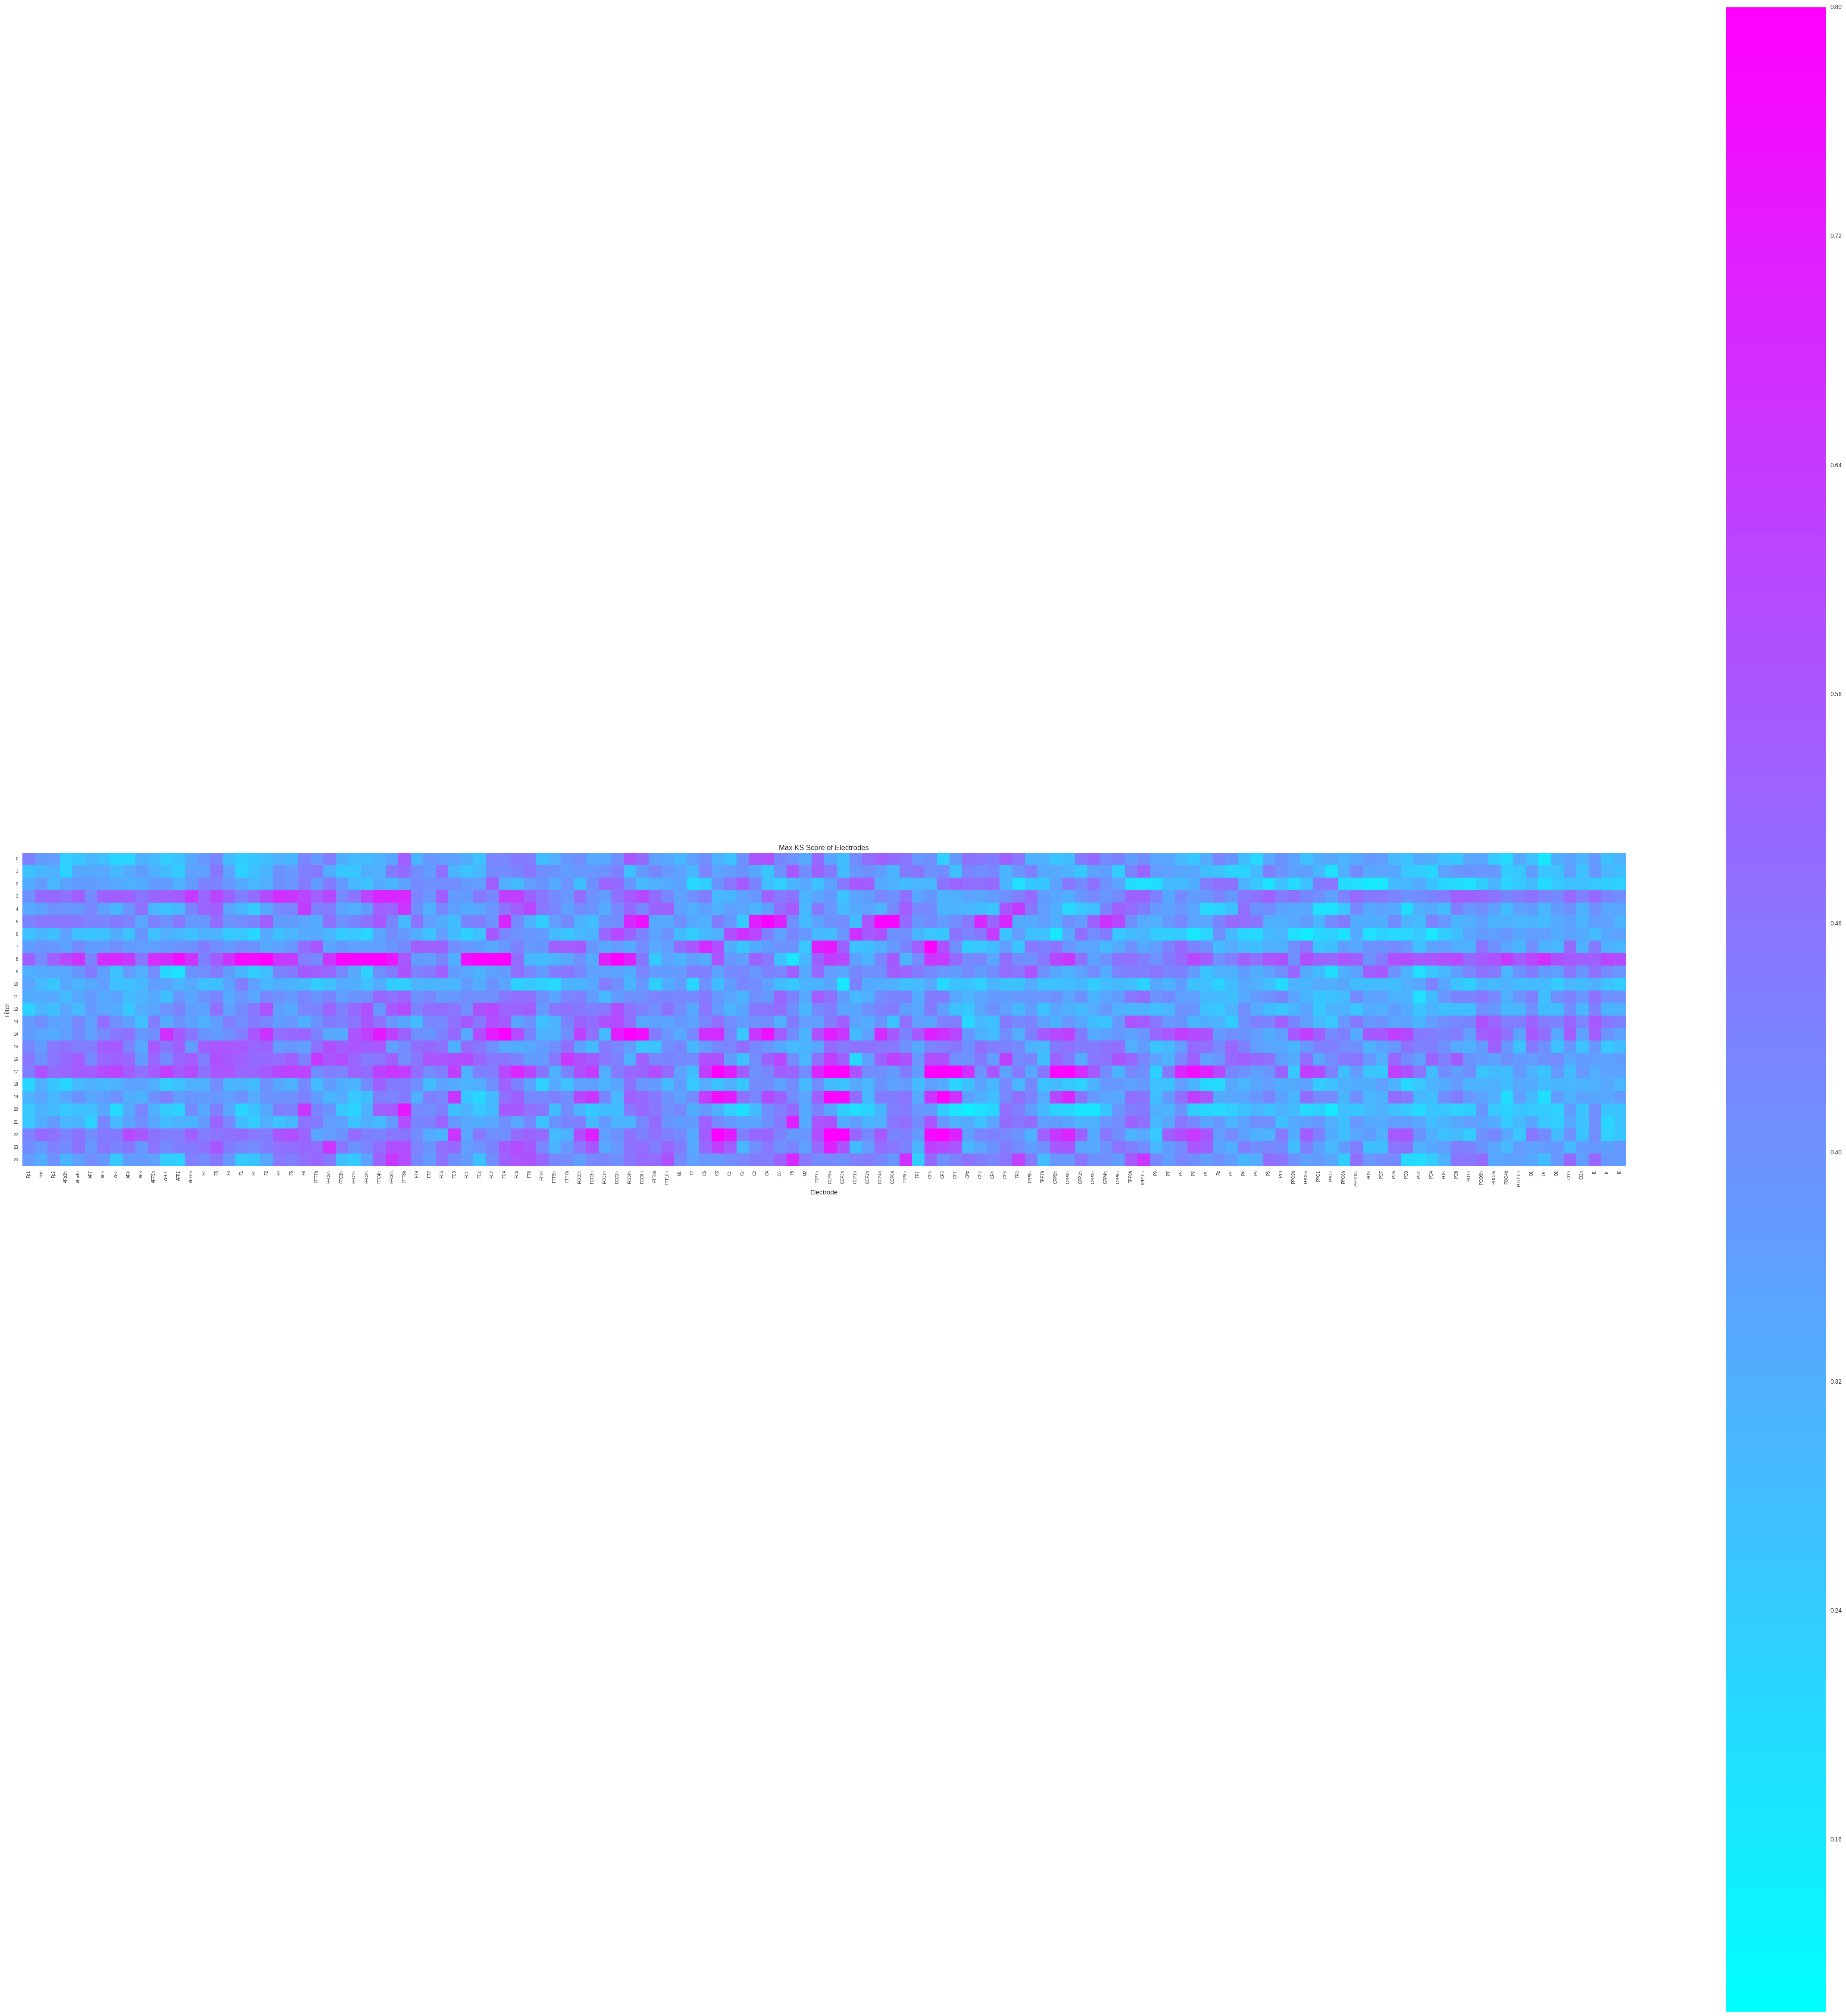

In [11]:
make_plot(FFT_diff,Phase_diff,FFT_KS,Phase_KS,Electrode_KS,Electrode_KS_max,sensor_names,frequencies)

### Layer 10

In [12]:
RF_Data = receptive_field.load_ExtractorData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'))
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'),10,None)

n_chans = RF_Data.n_chans
sensor_names = RF_Data.sensor_names
sampling_rate = RF_Data.sampling_rate

In [13]:
FFT_diff,Phase_diff,FFT_KS,Phase_KS,Electrode_KS,Electrode_KS_max,frequencies = make_data(RF_Result,n_chans)


(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (499200,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1]

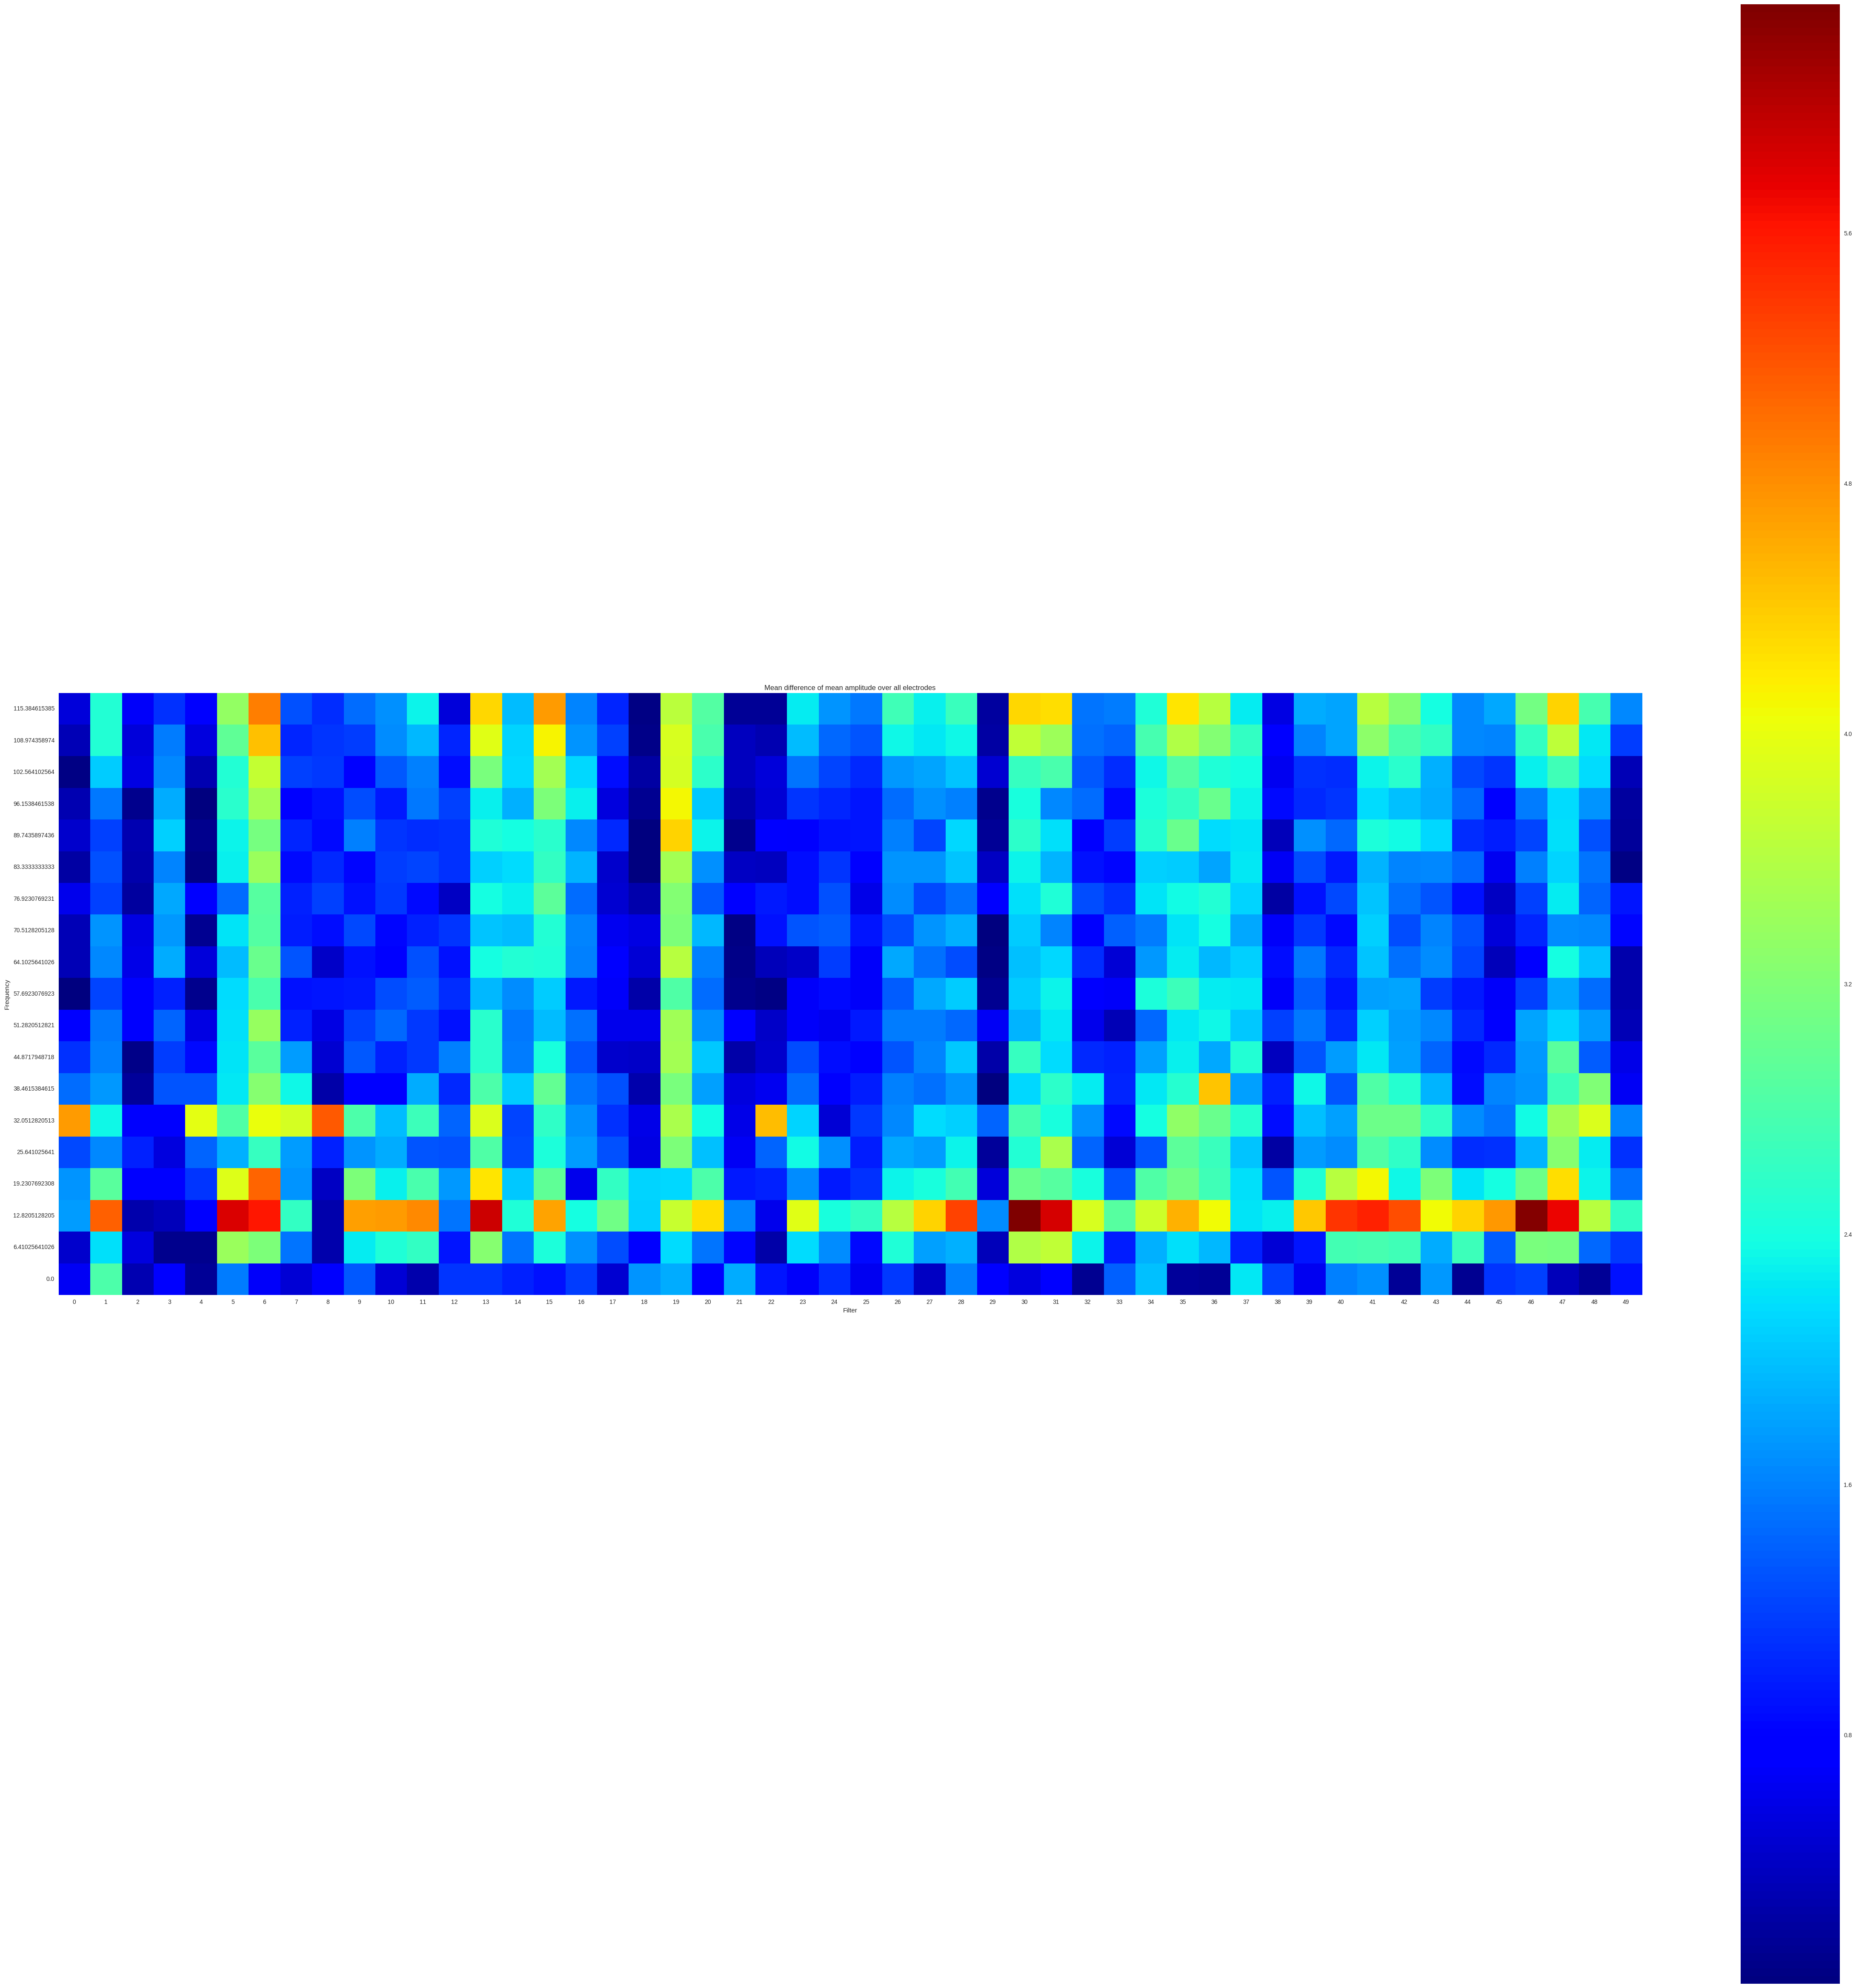

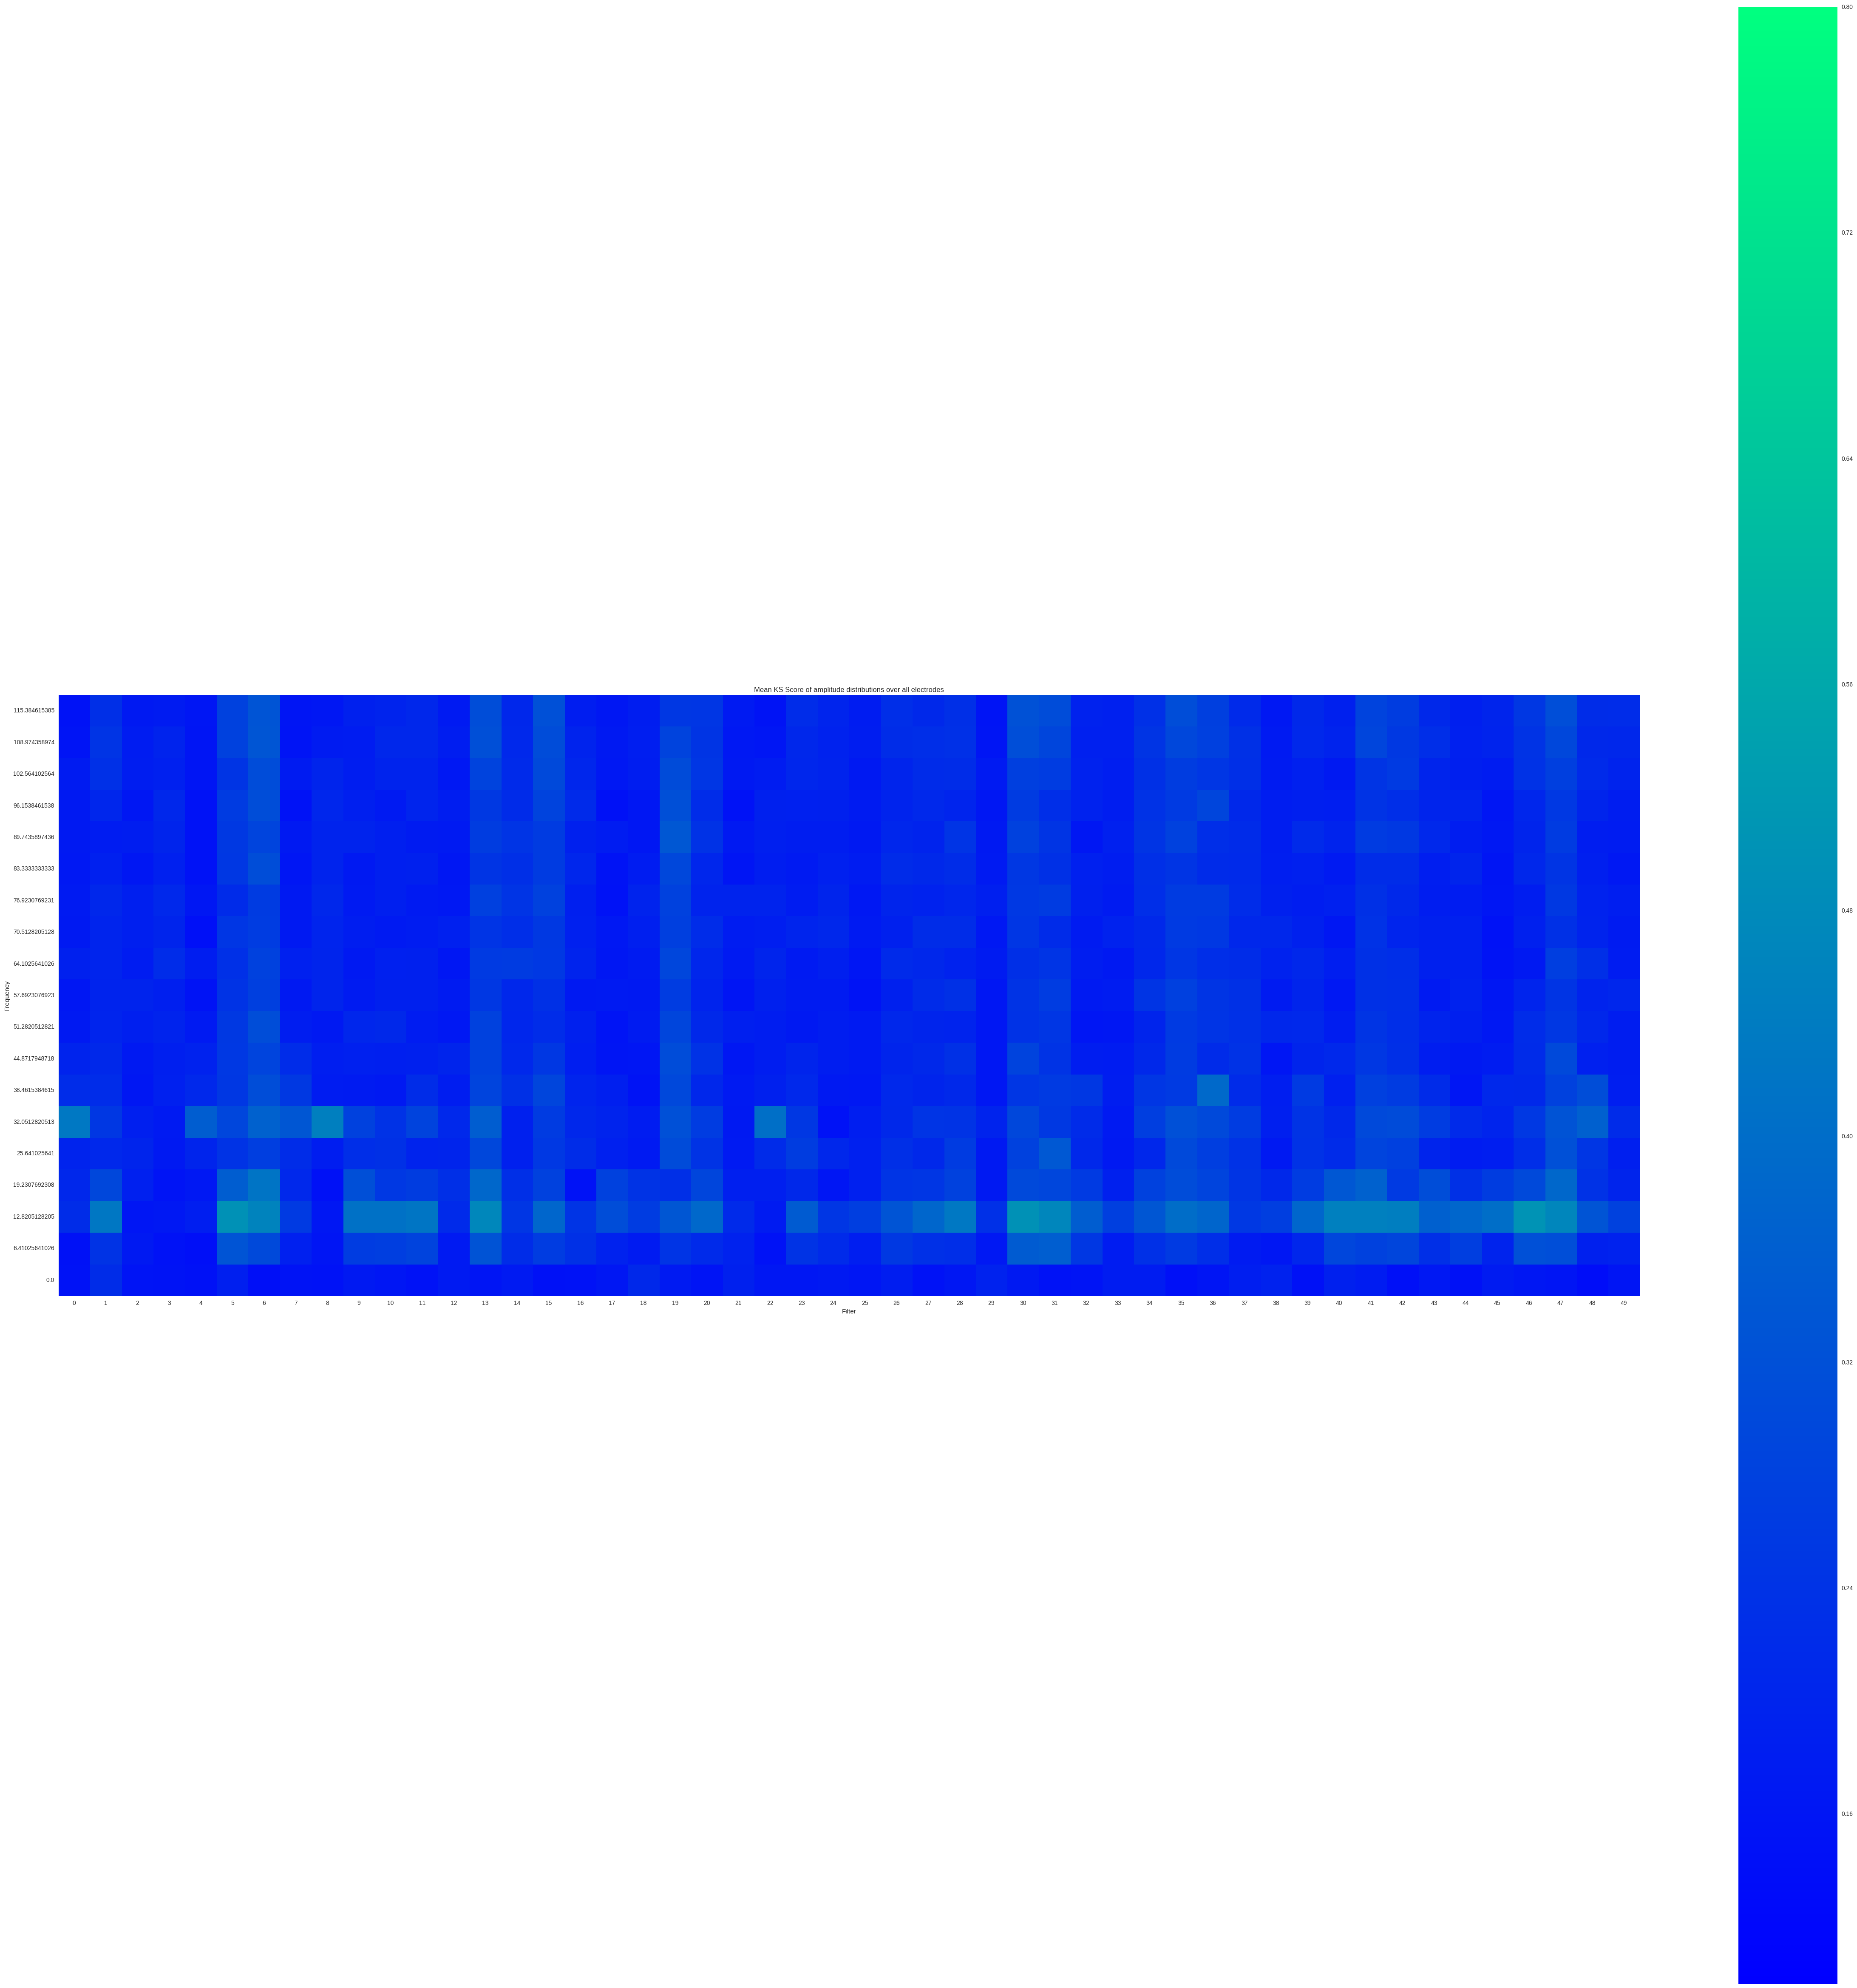

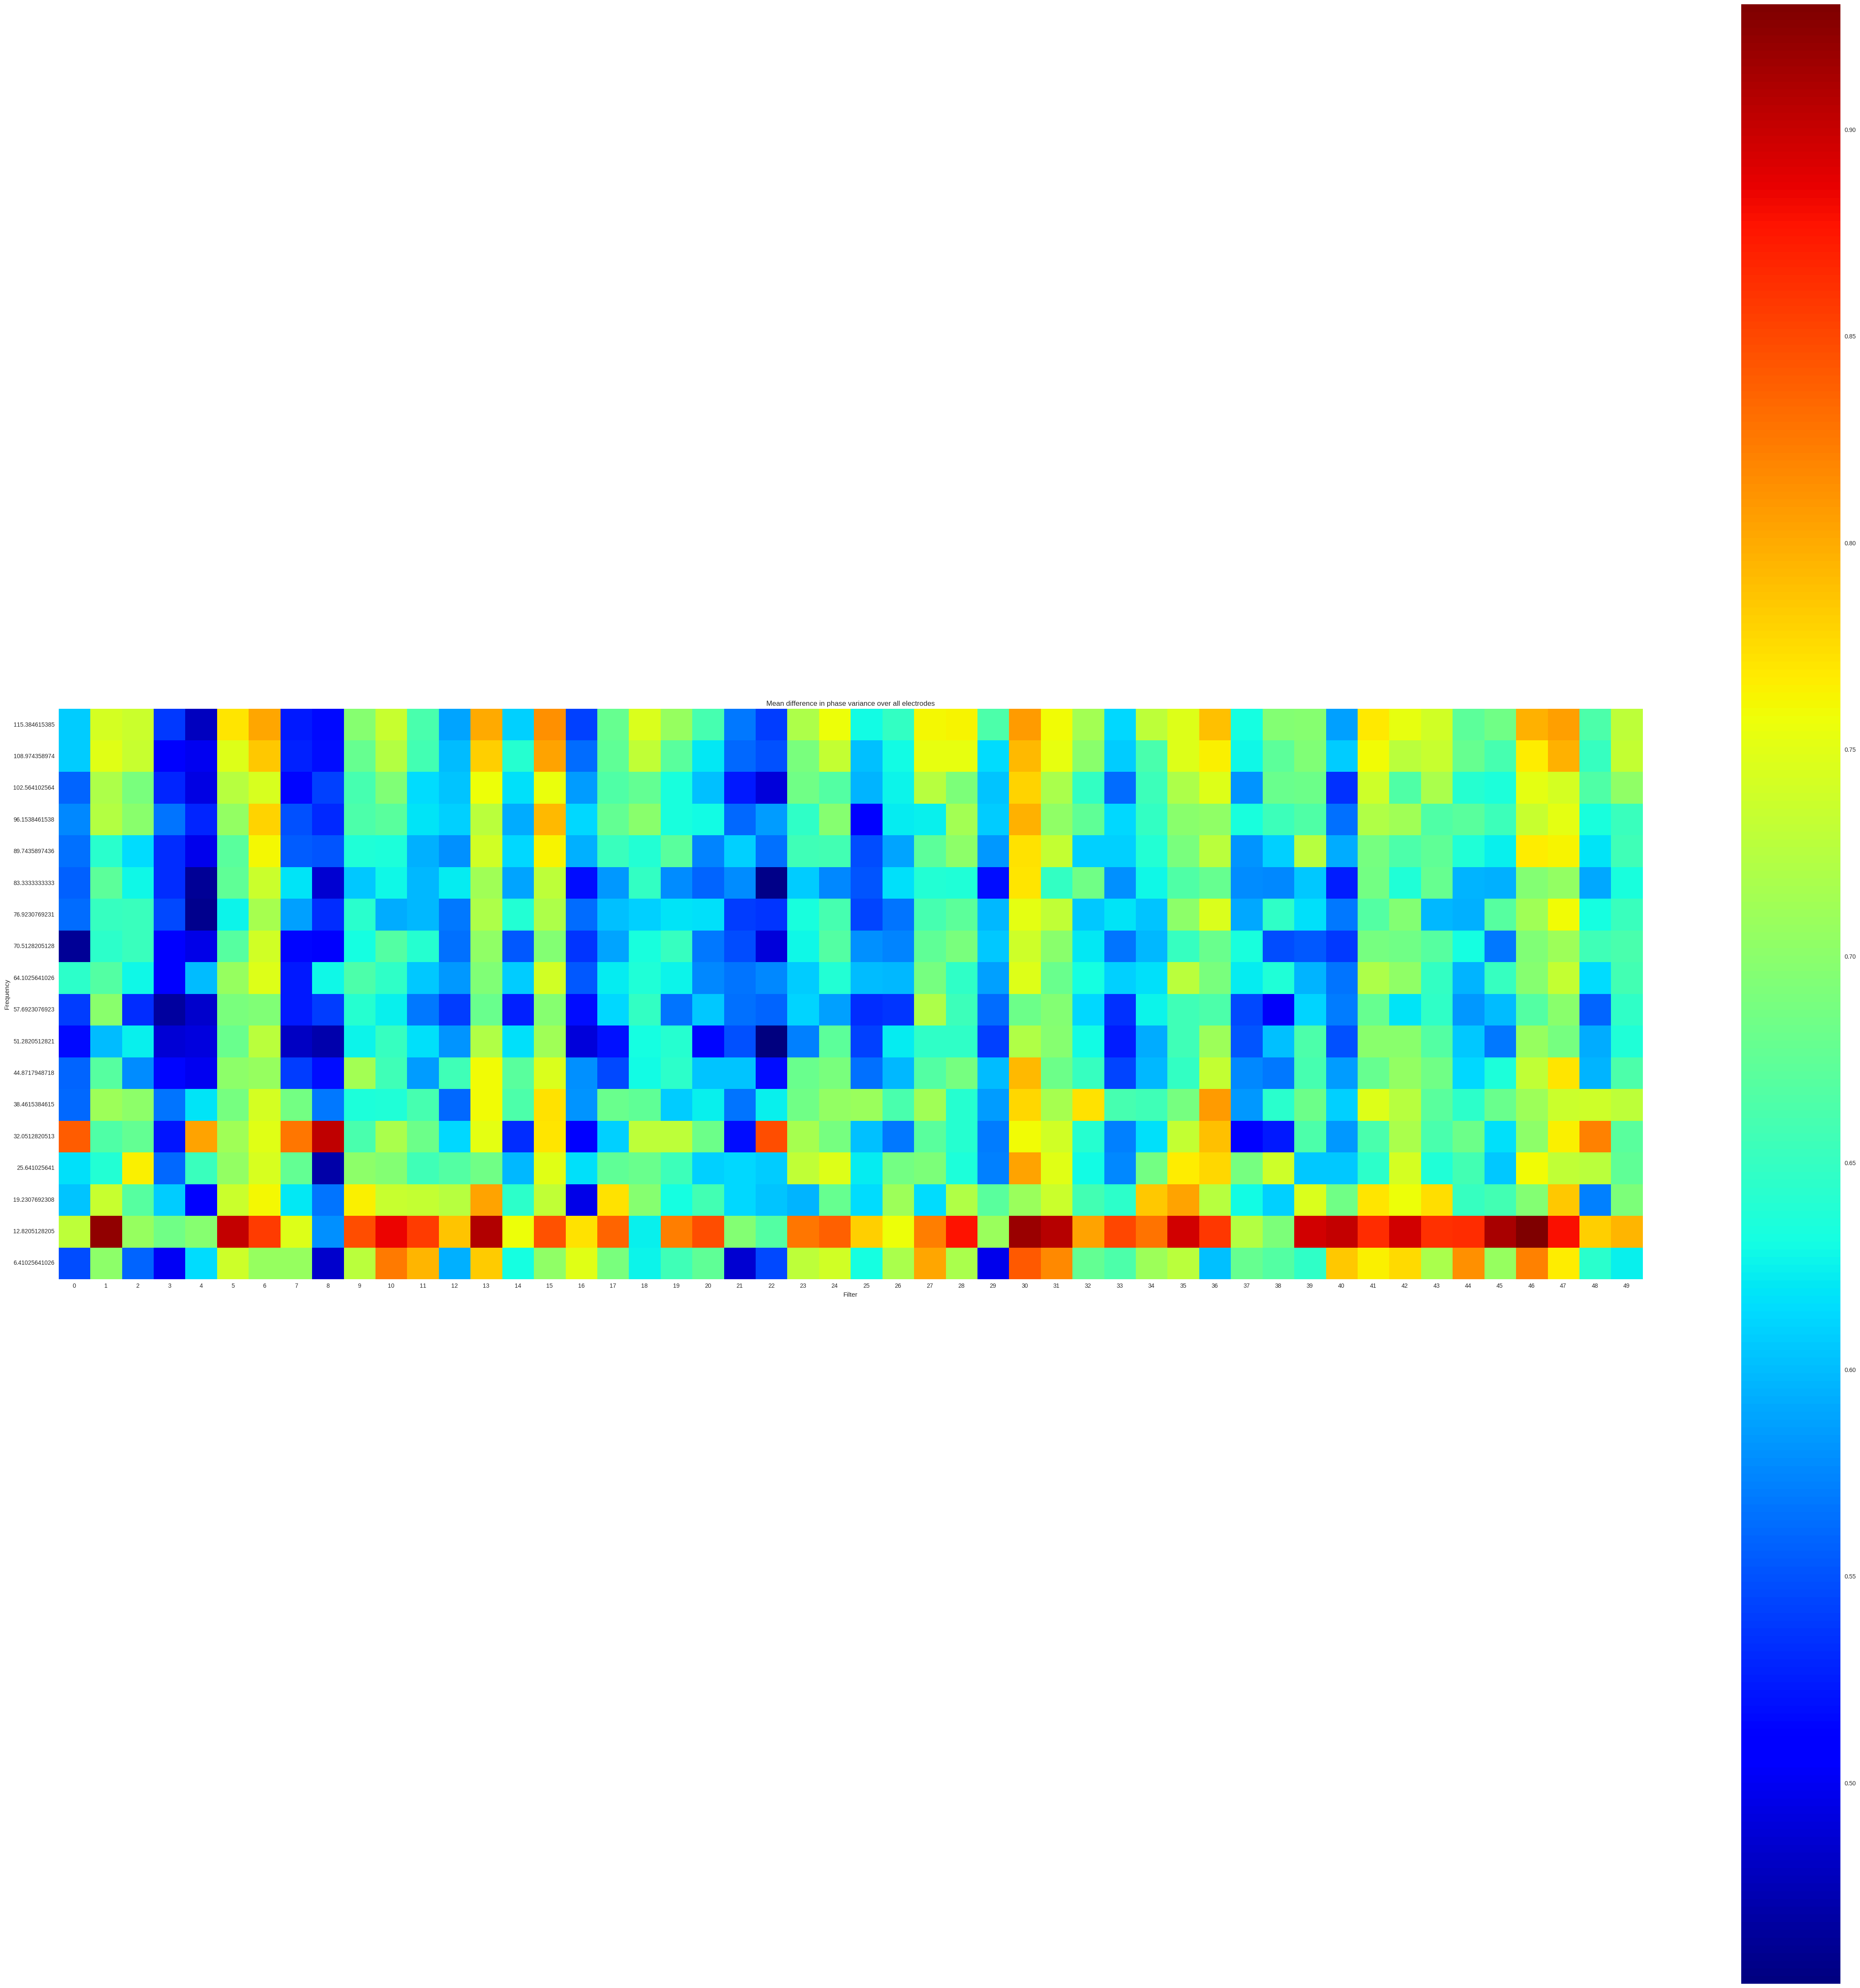

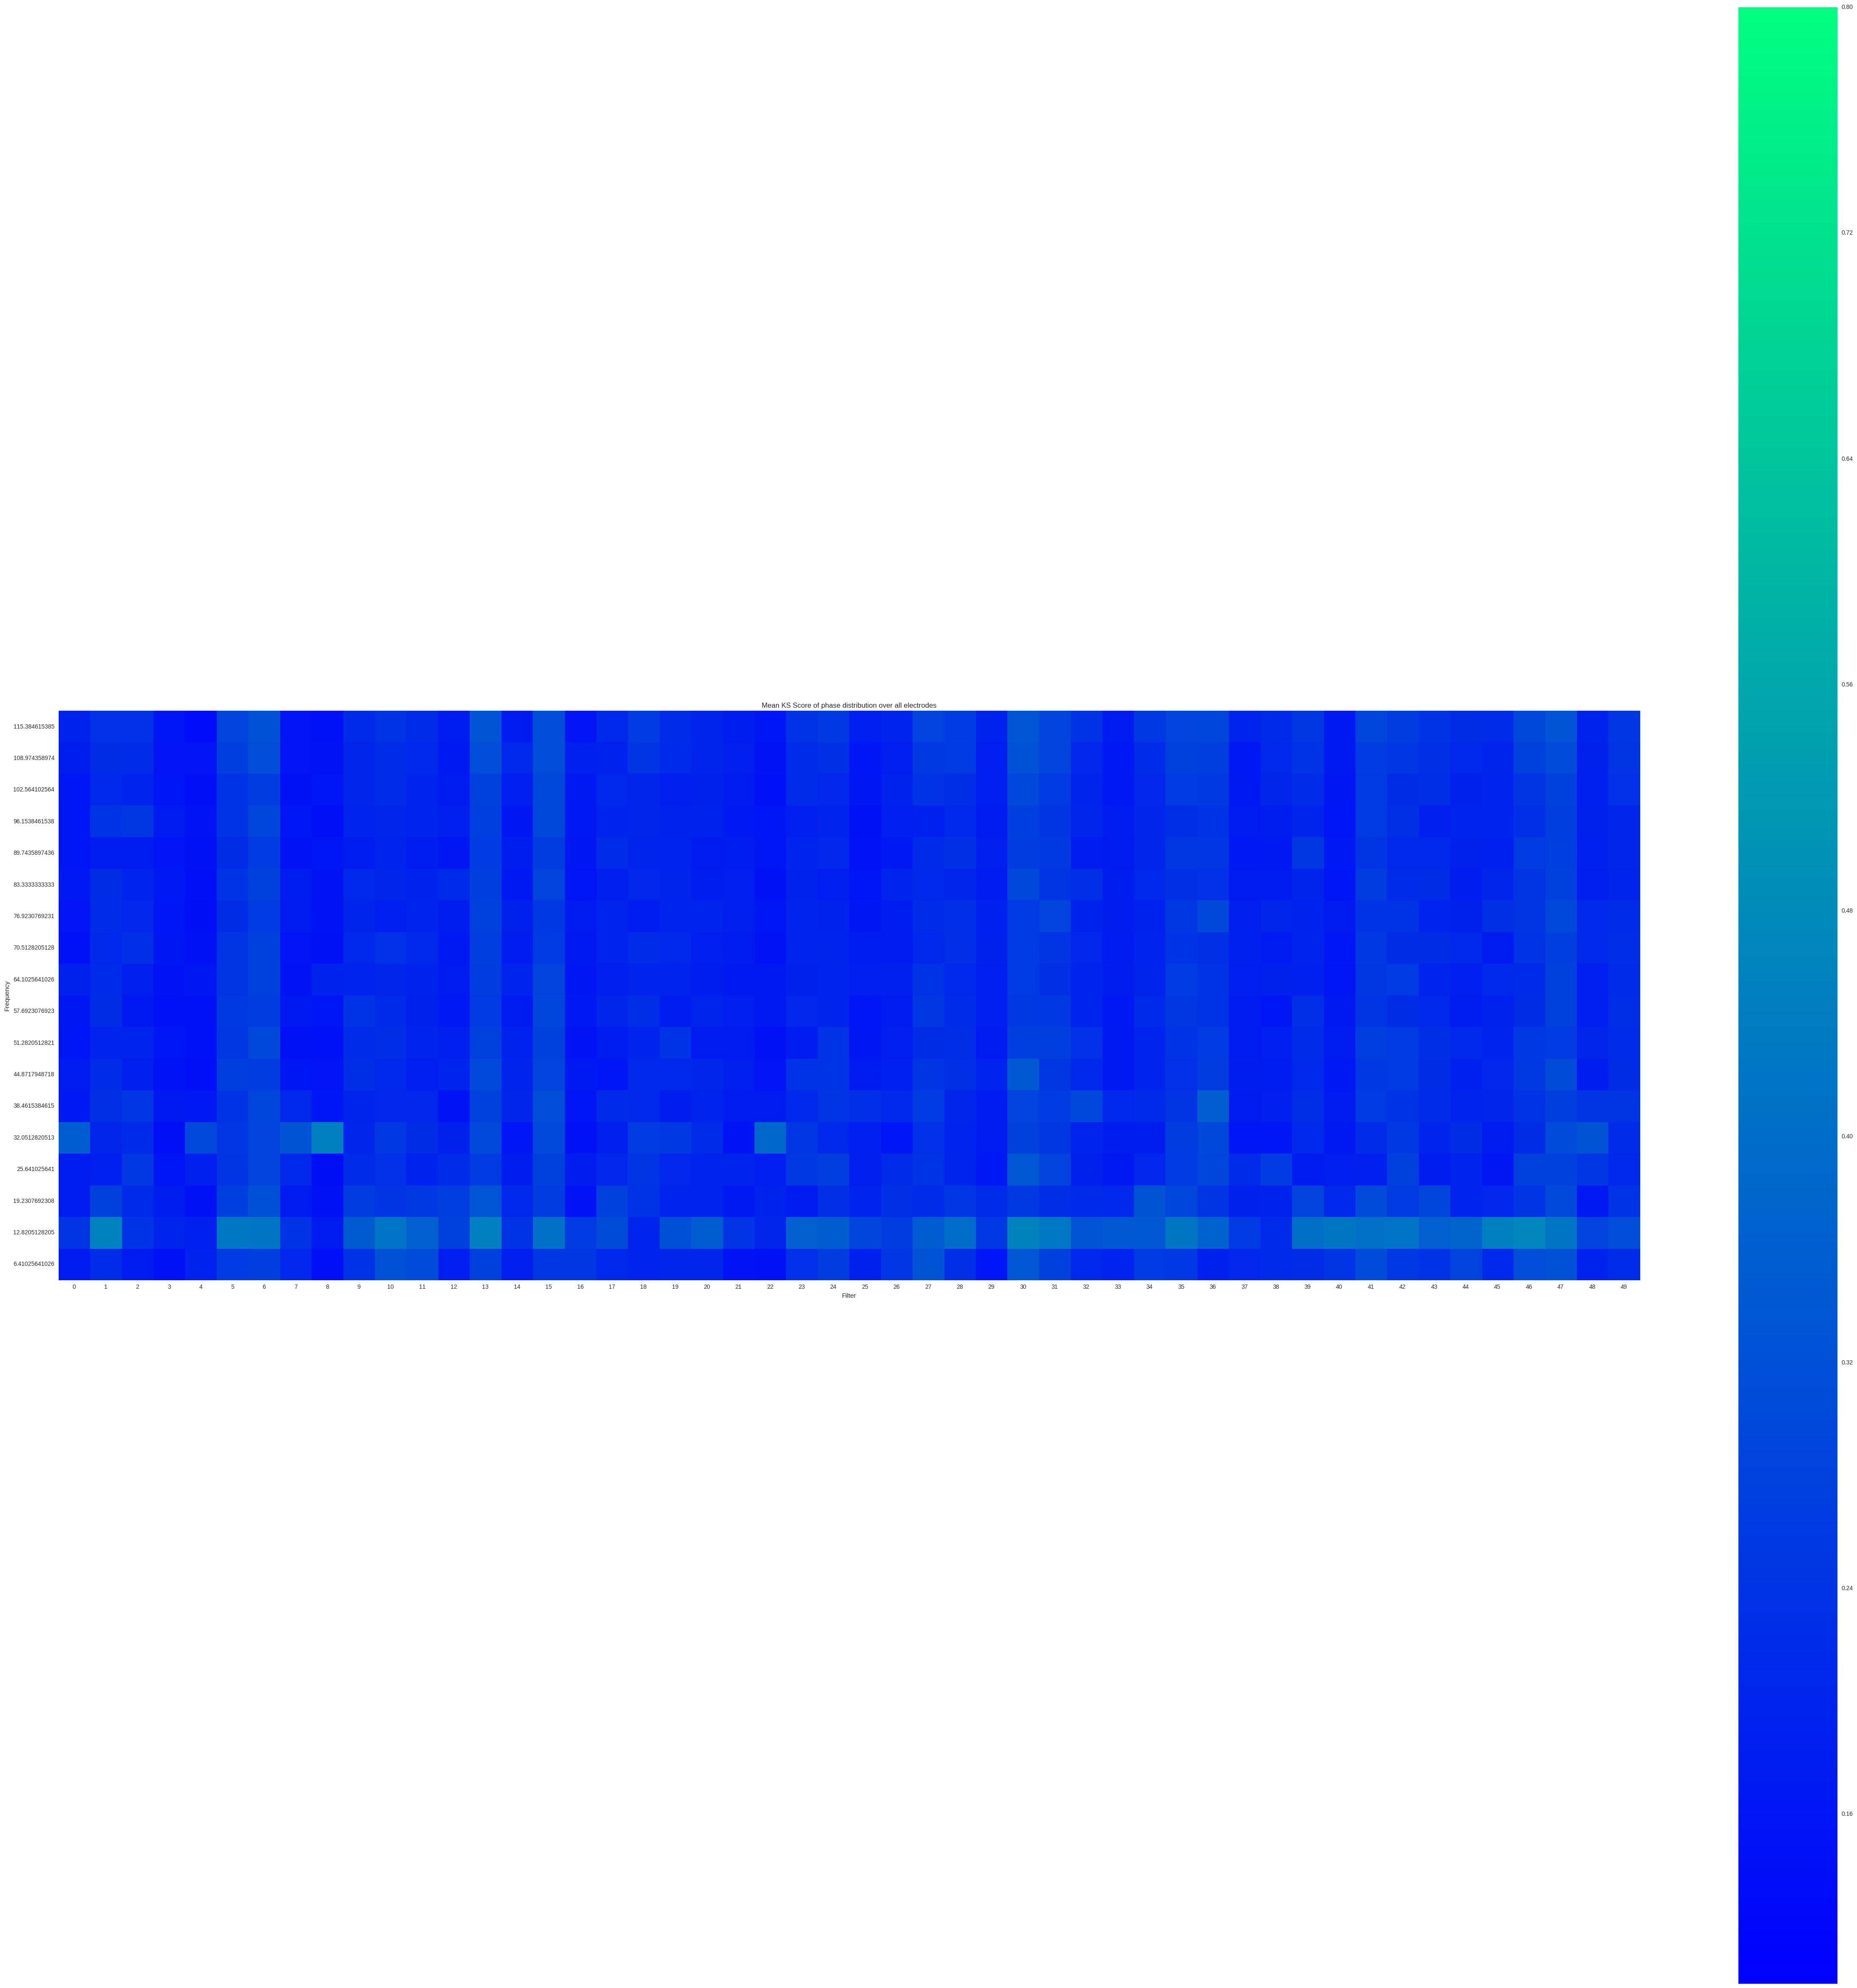

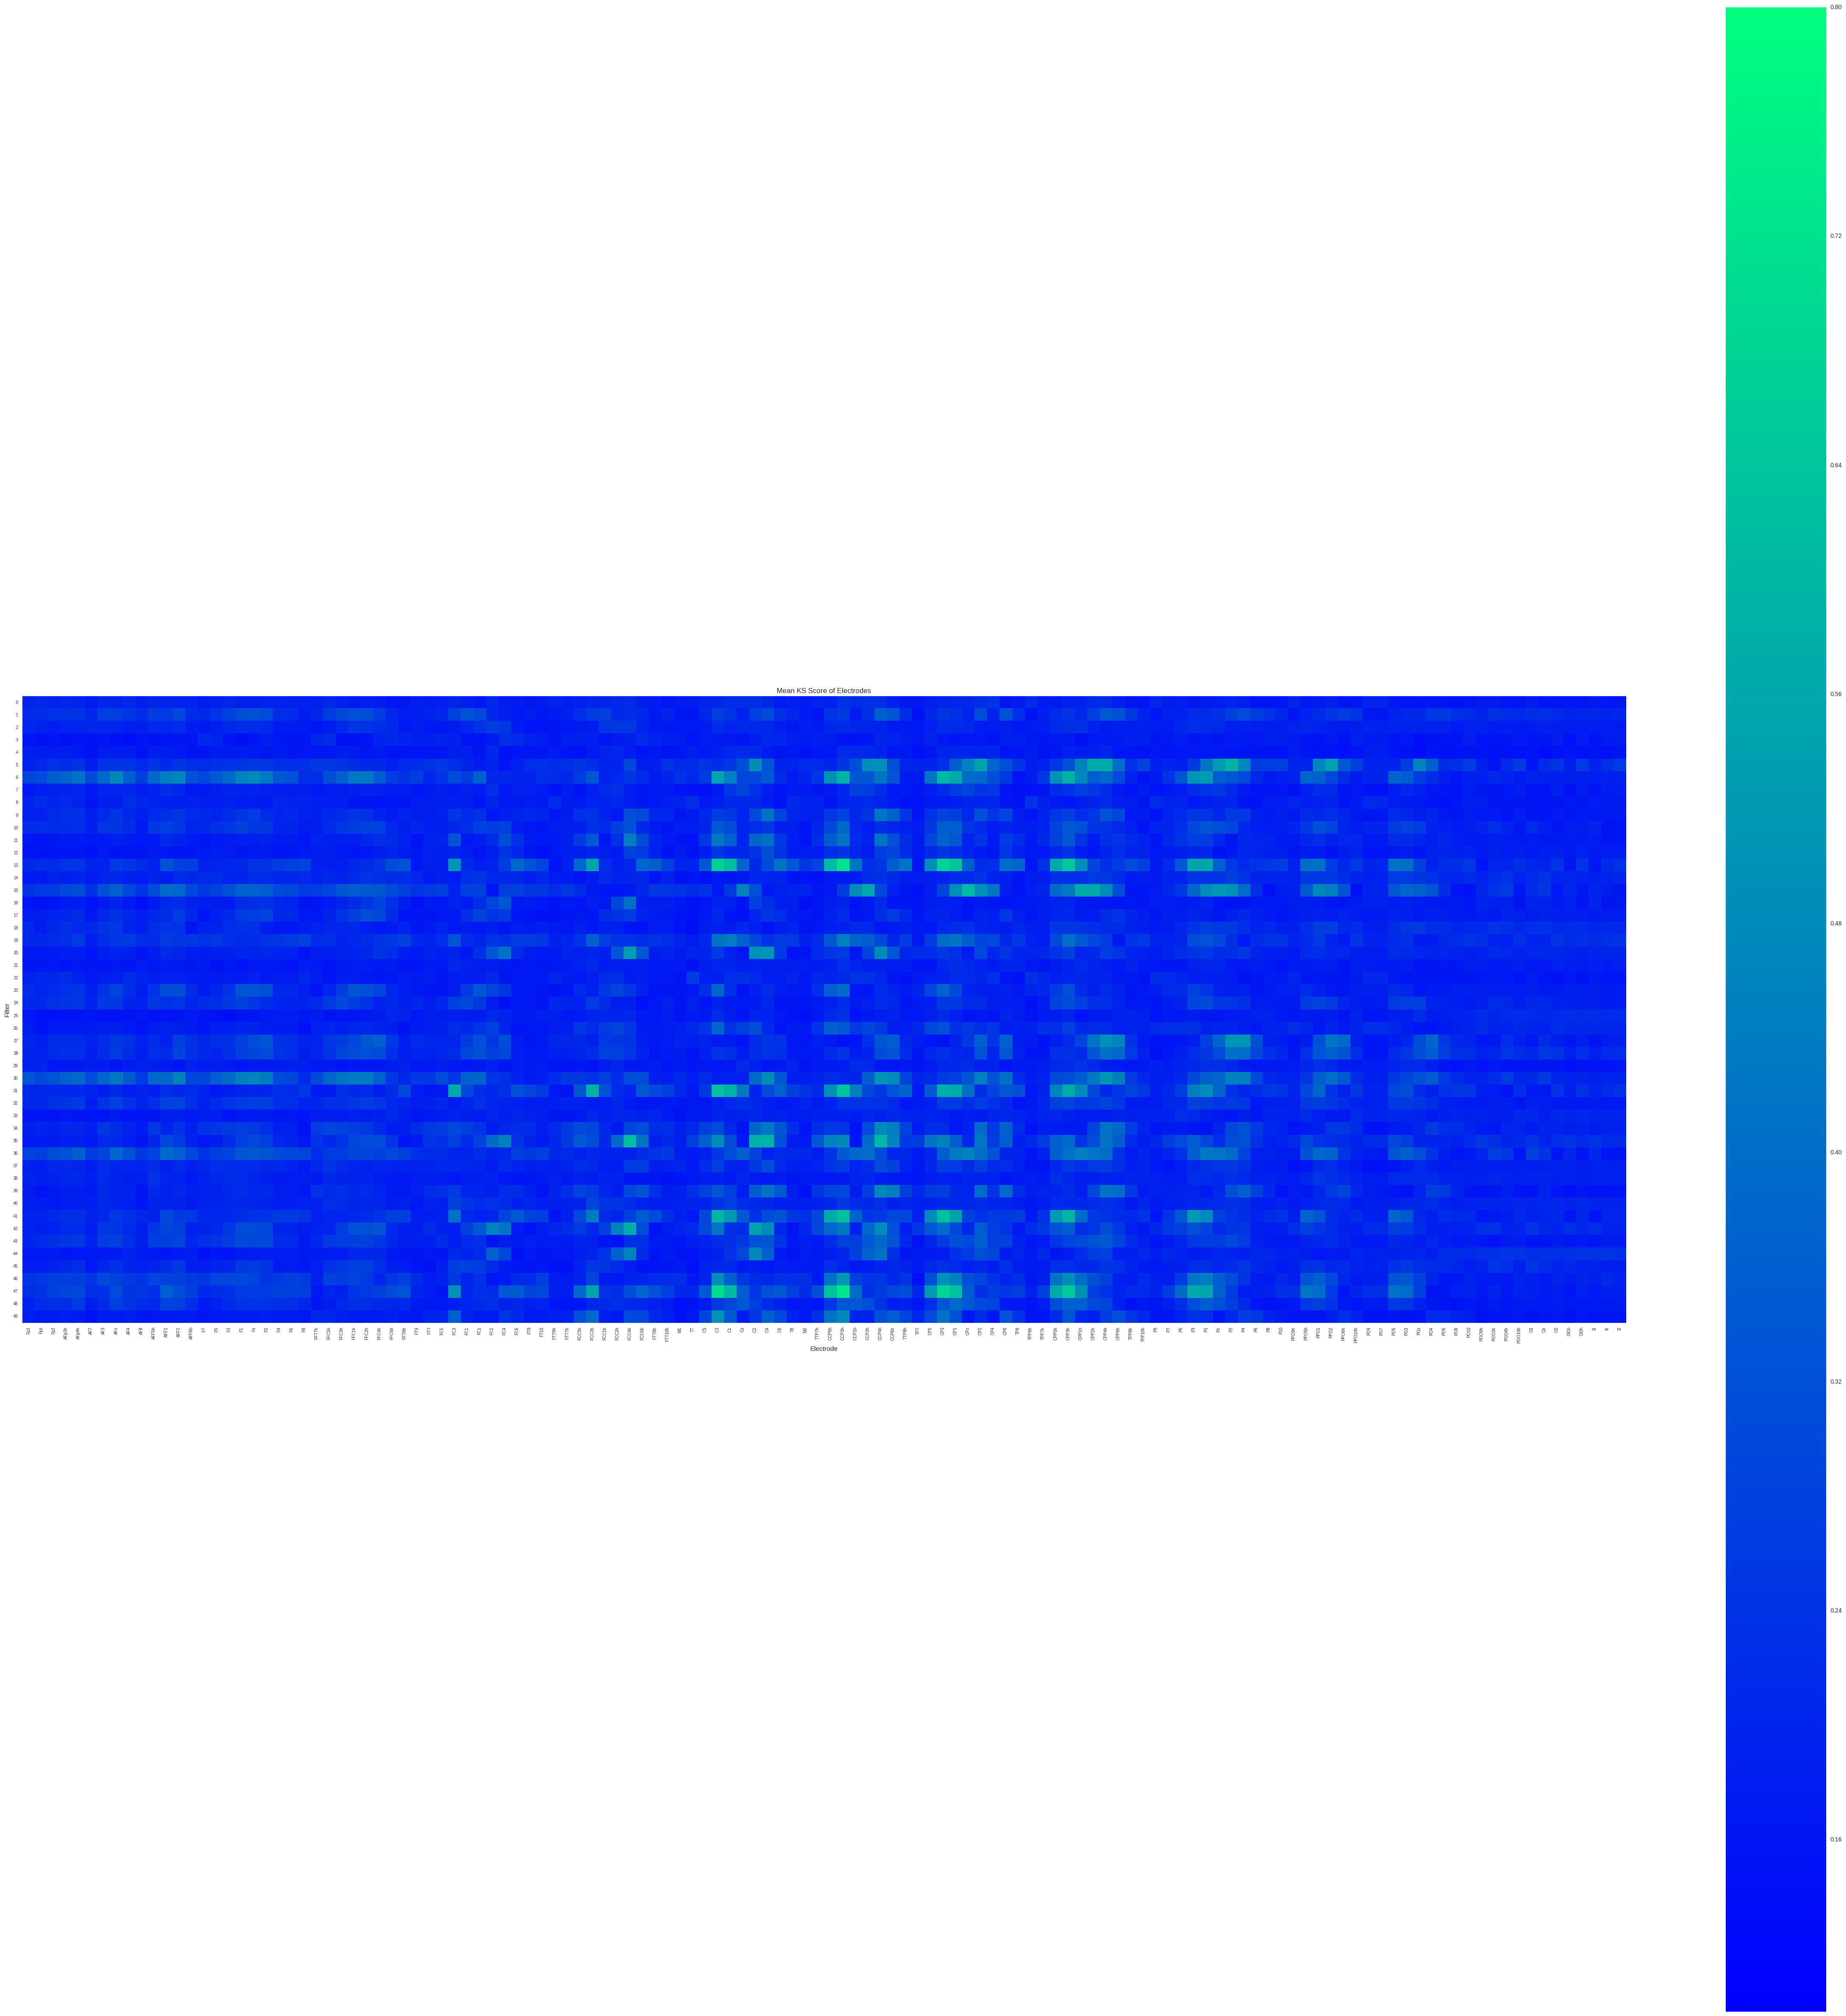

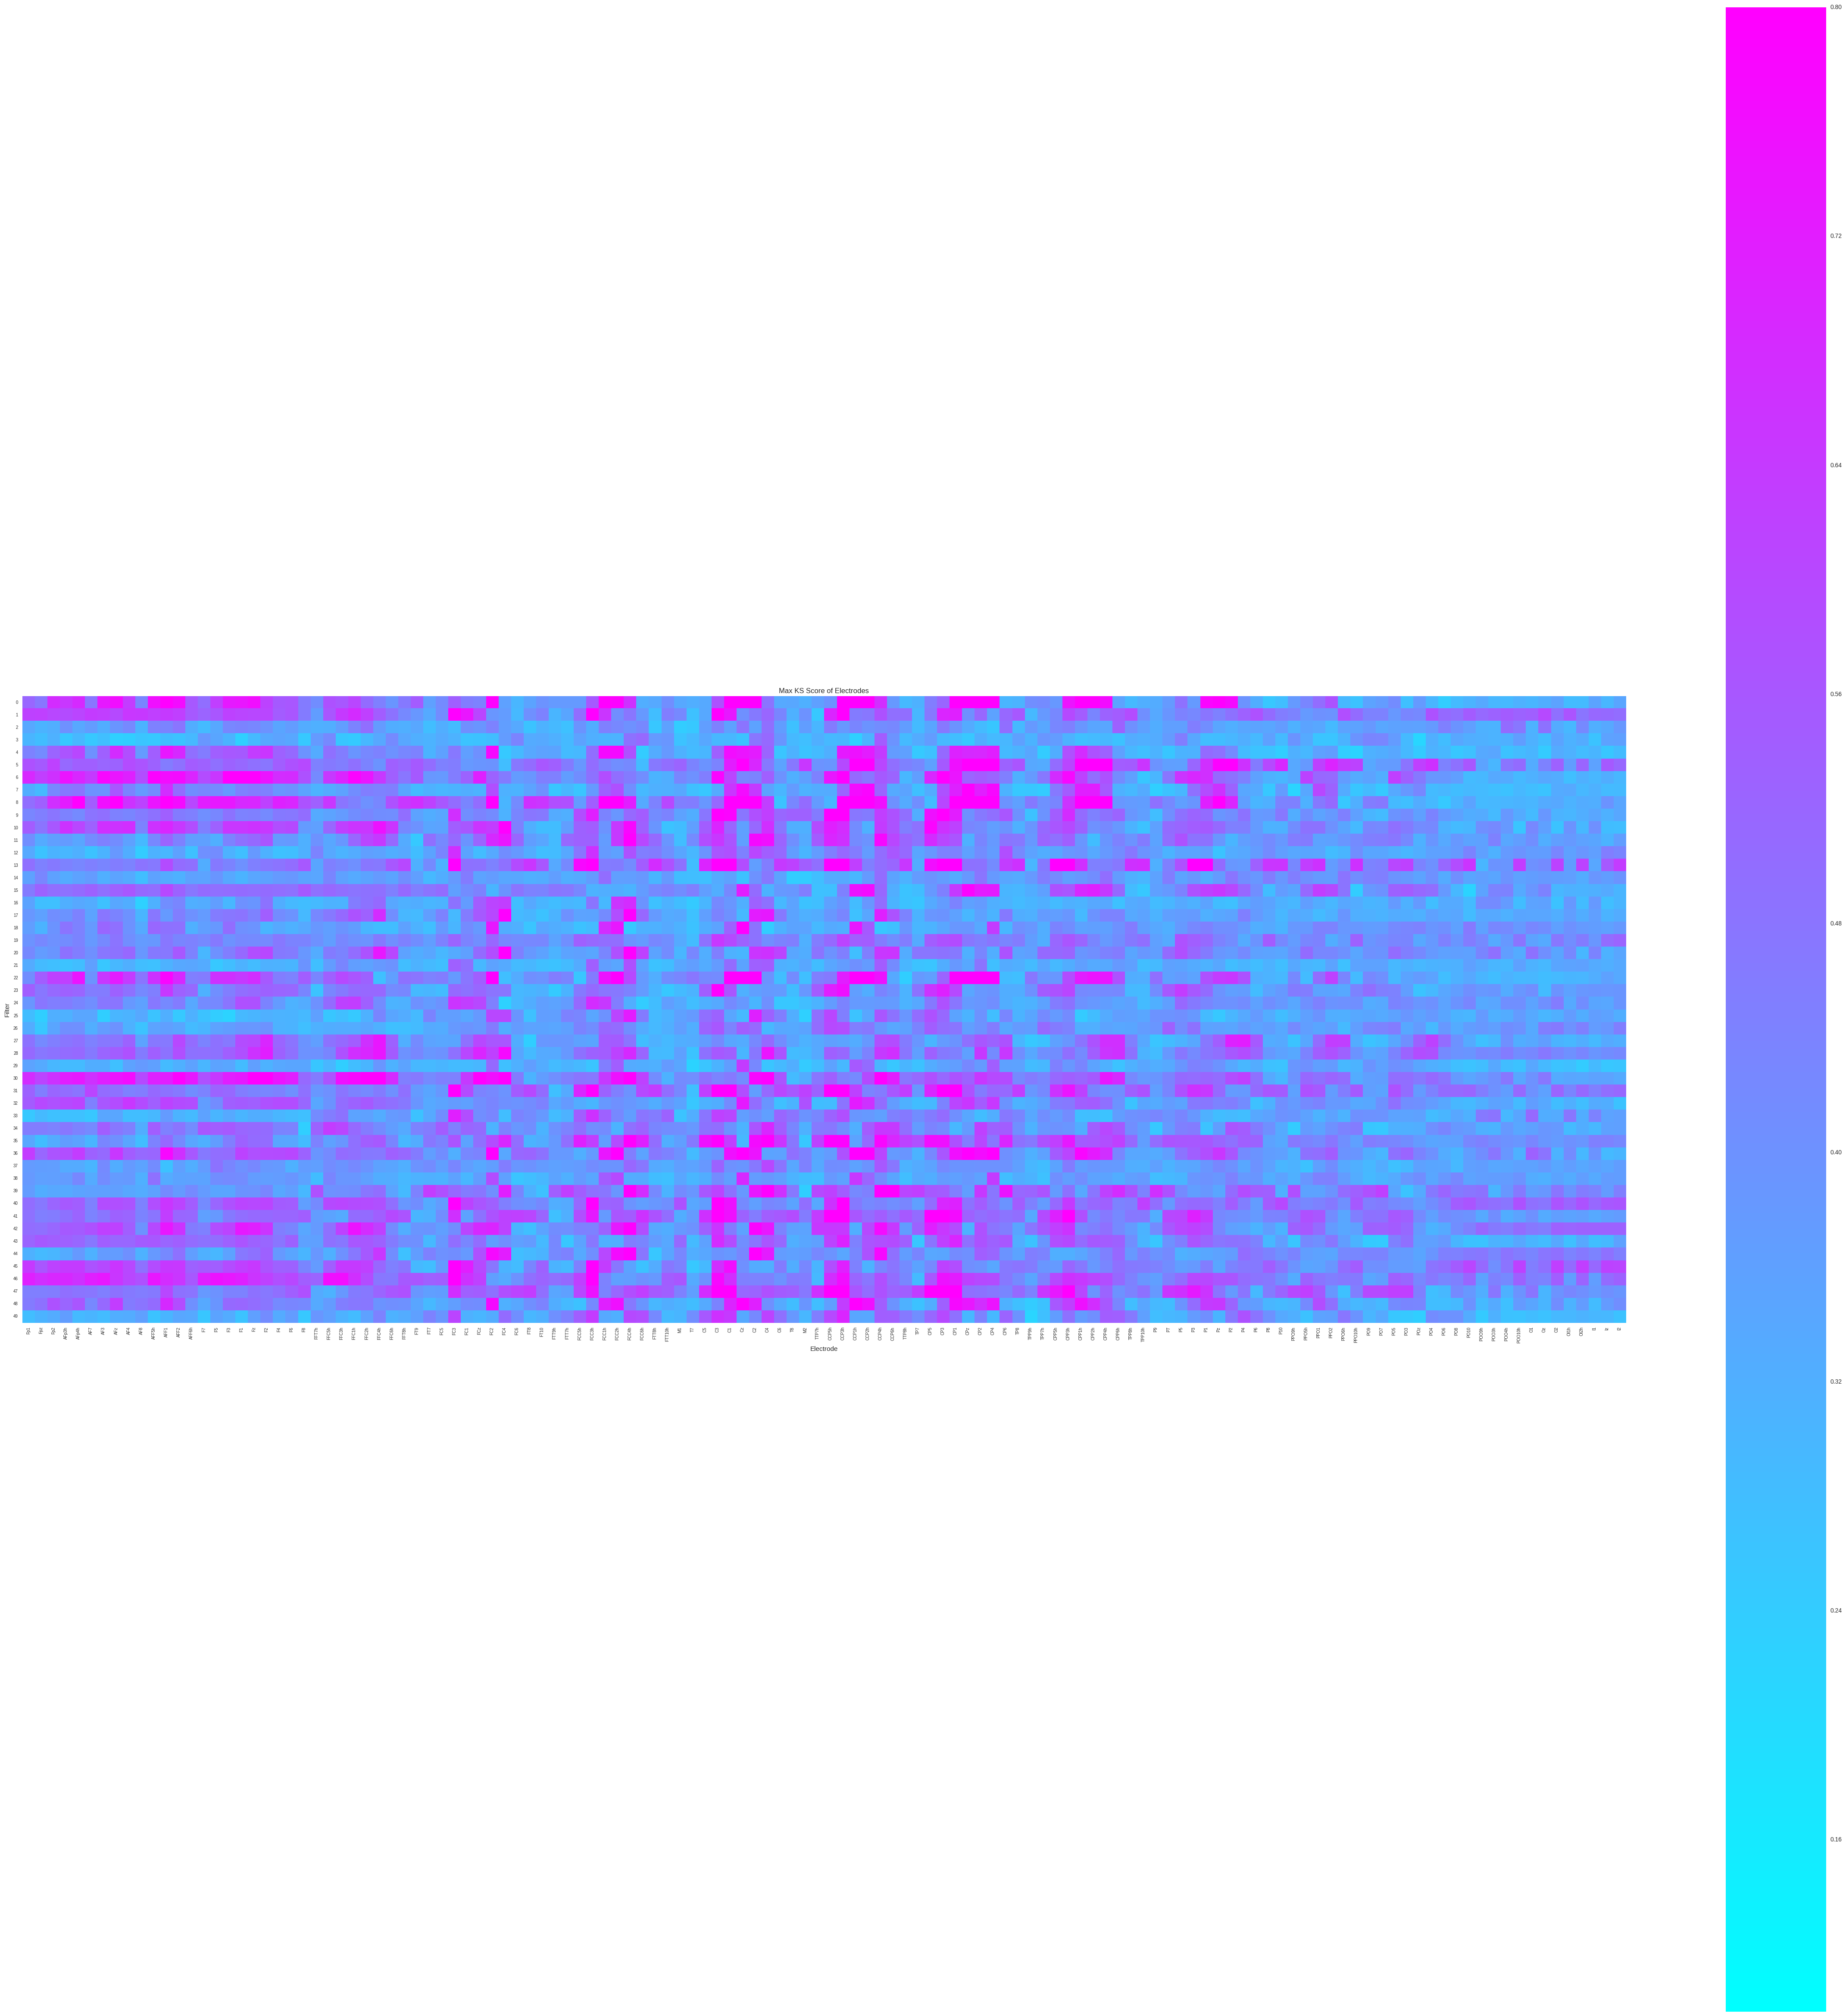

In [14]:
make_plot(FFT_diff,Phase_diff,FFT_KS,Phase_KS,Electrode_KS,Electrode_KS_max,sensor_names,frequencies)

### Layer 16

In [15]:
RF_Data = receptive_field.load_ExtractorData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'))
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'),16,None)

n_chans = RF_Data.n_chans
sensor_names = RF_Data.sensor_names
sampling_rate = RF_Data.sampling_rate

In [16]:
FFT_diff,Phase_diff,FFT_KS,Phase_KS,Electrode_KS,Electrode_KS_max,frequencies = make_data(RF_Result,n_chans)


(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (1612800,) ([0], 128, -1)
(100, 128, 100

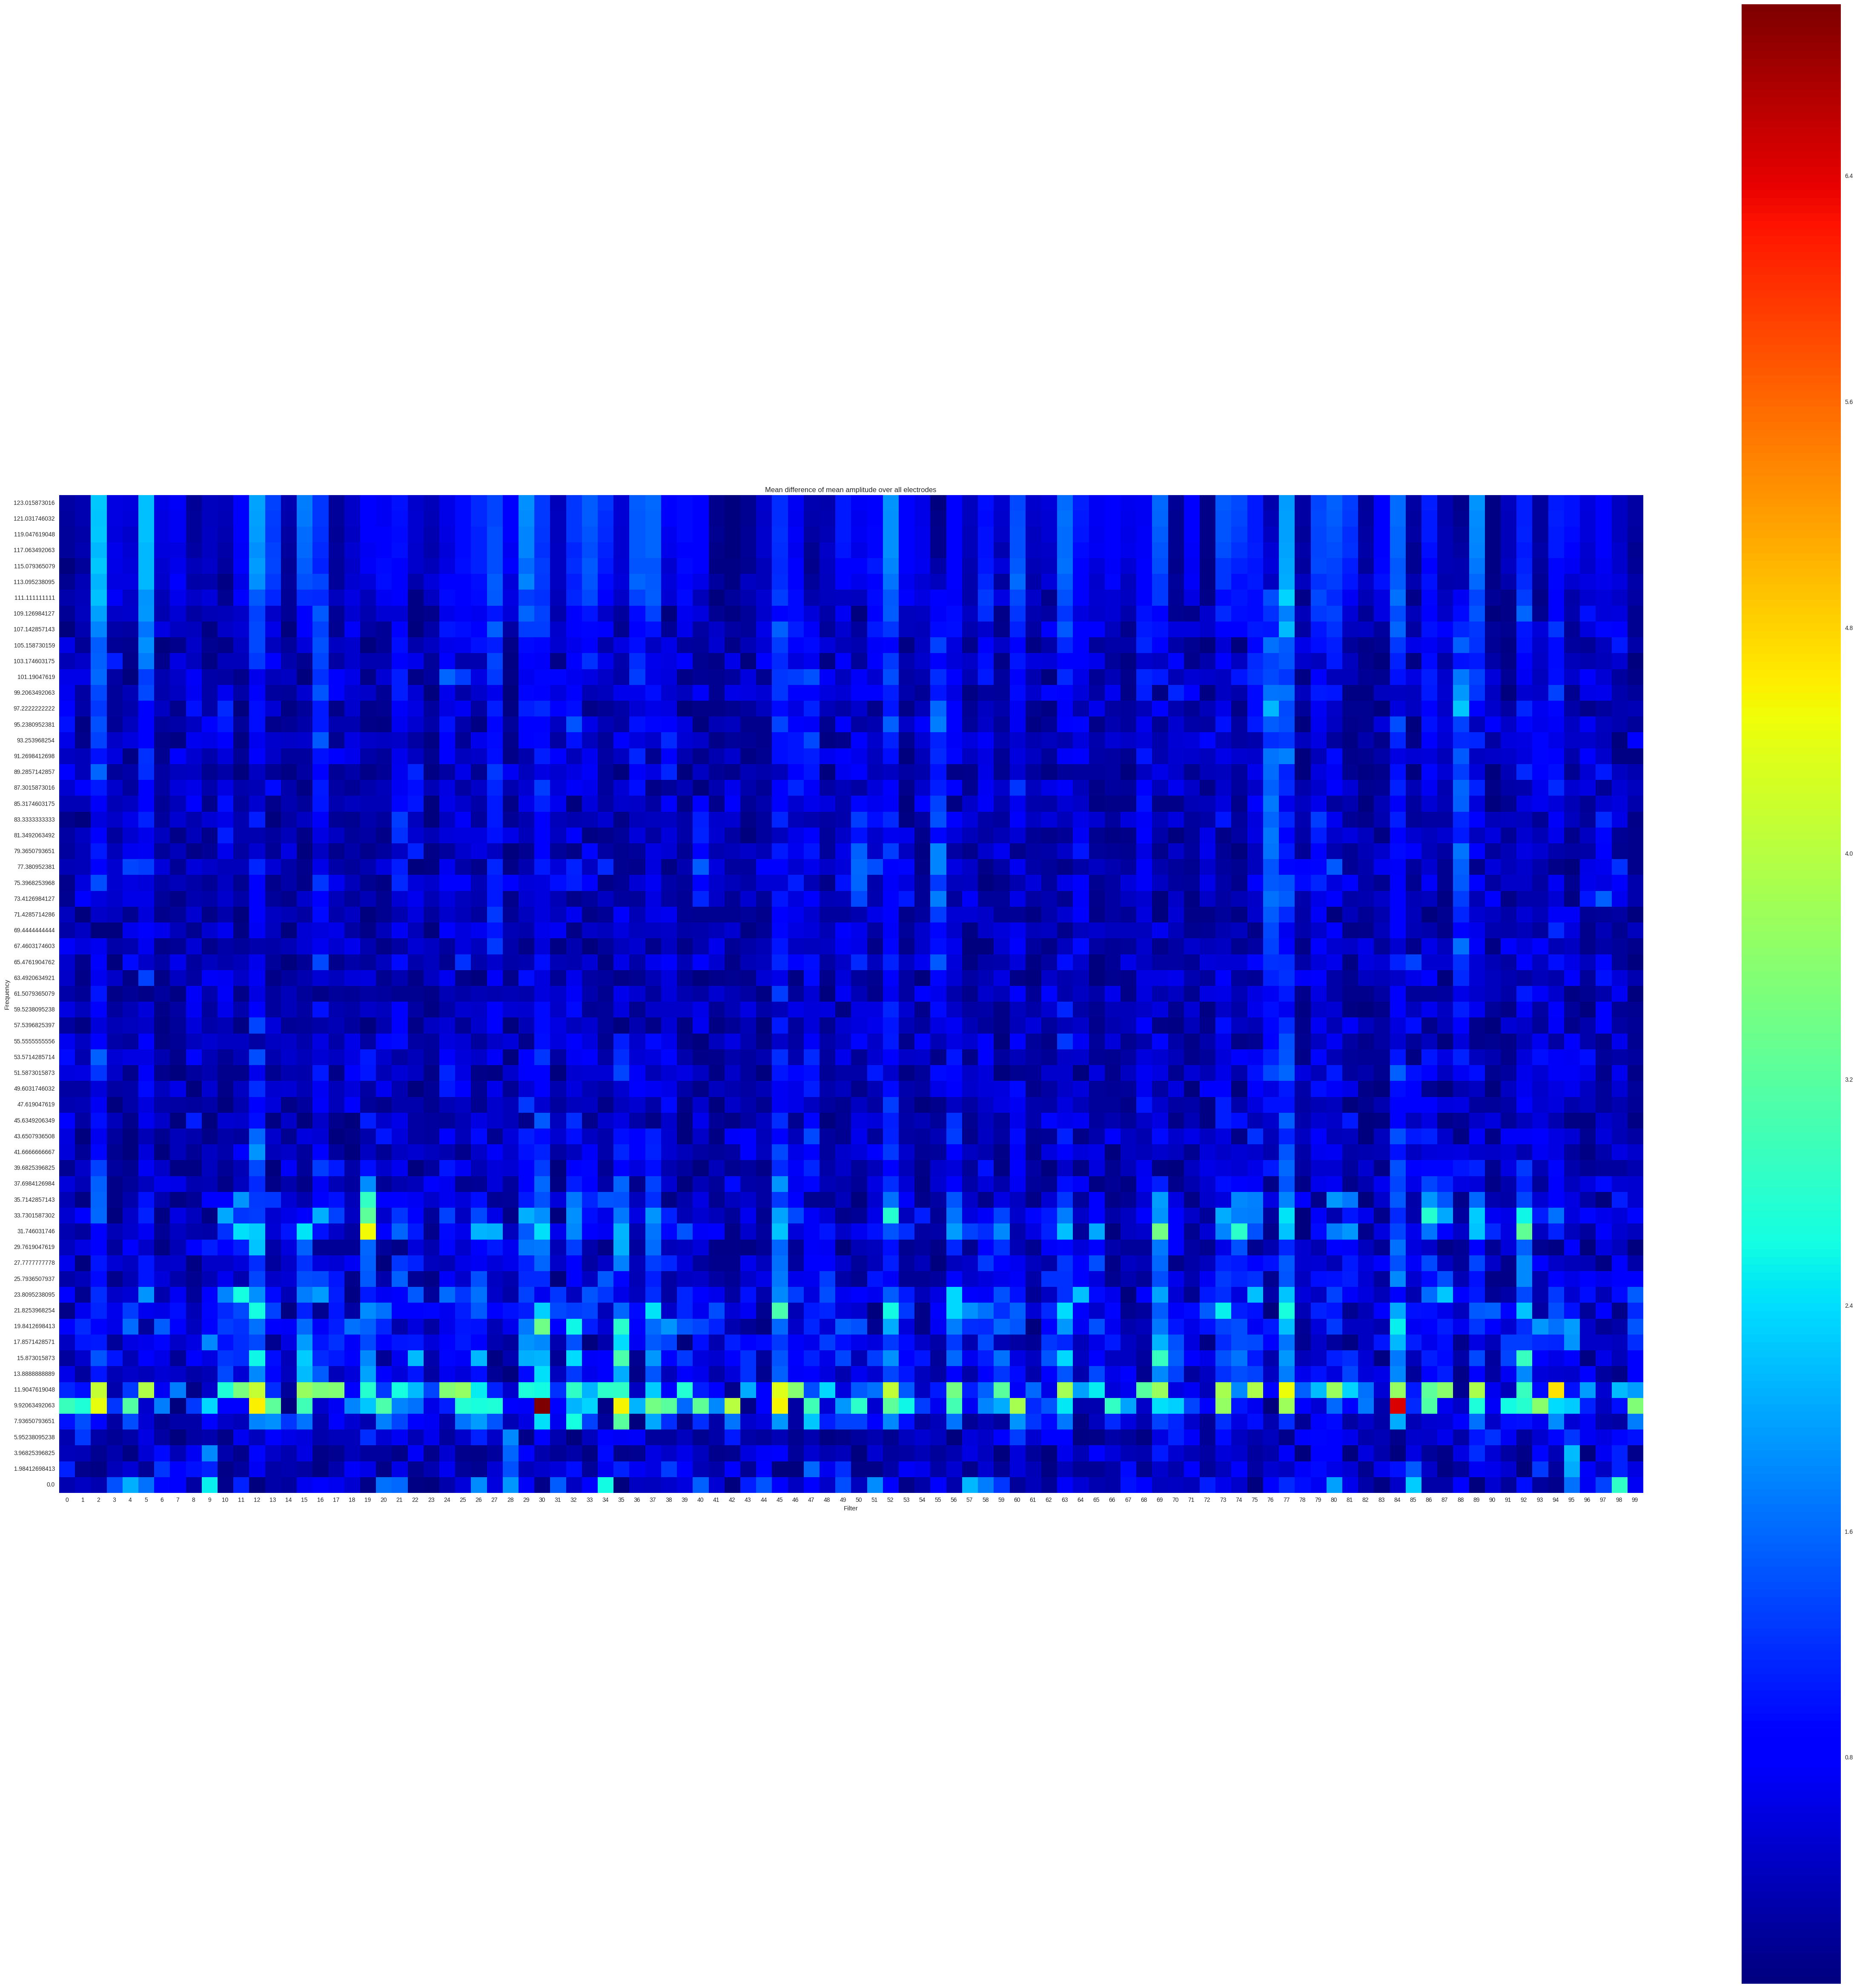

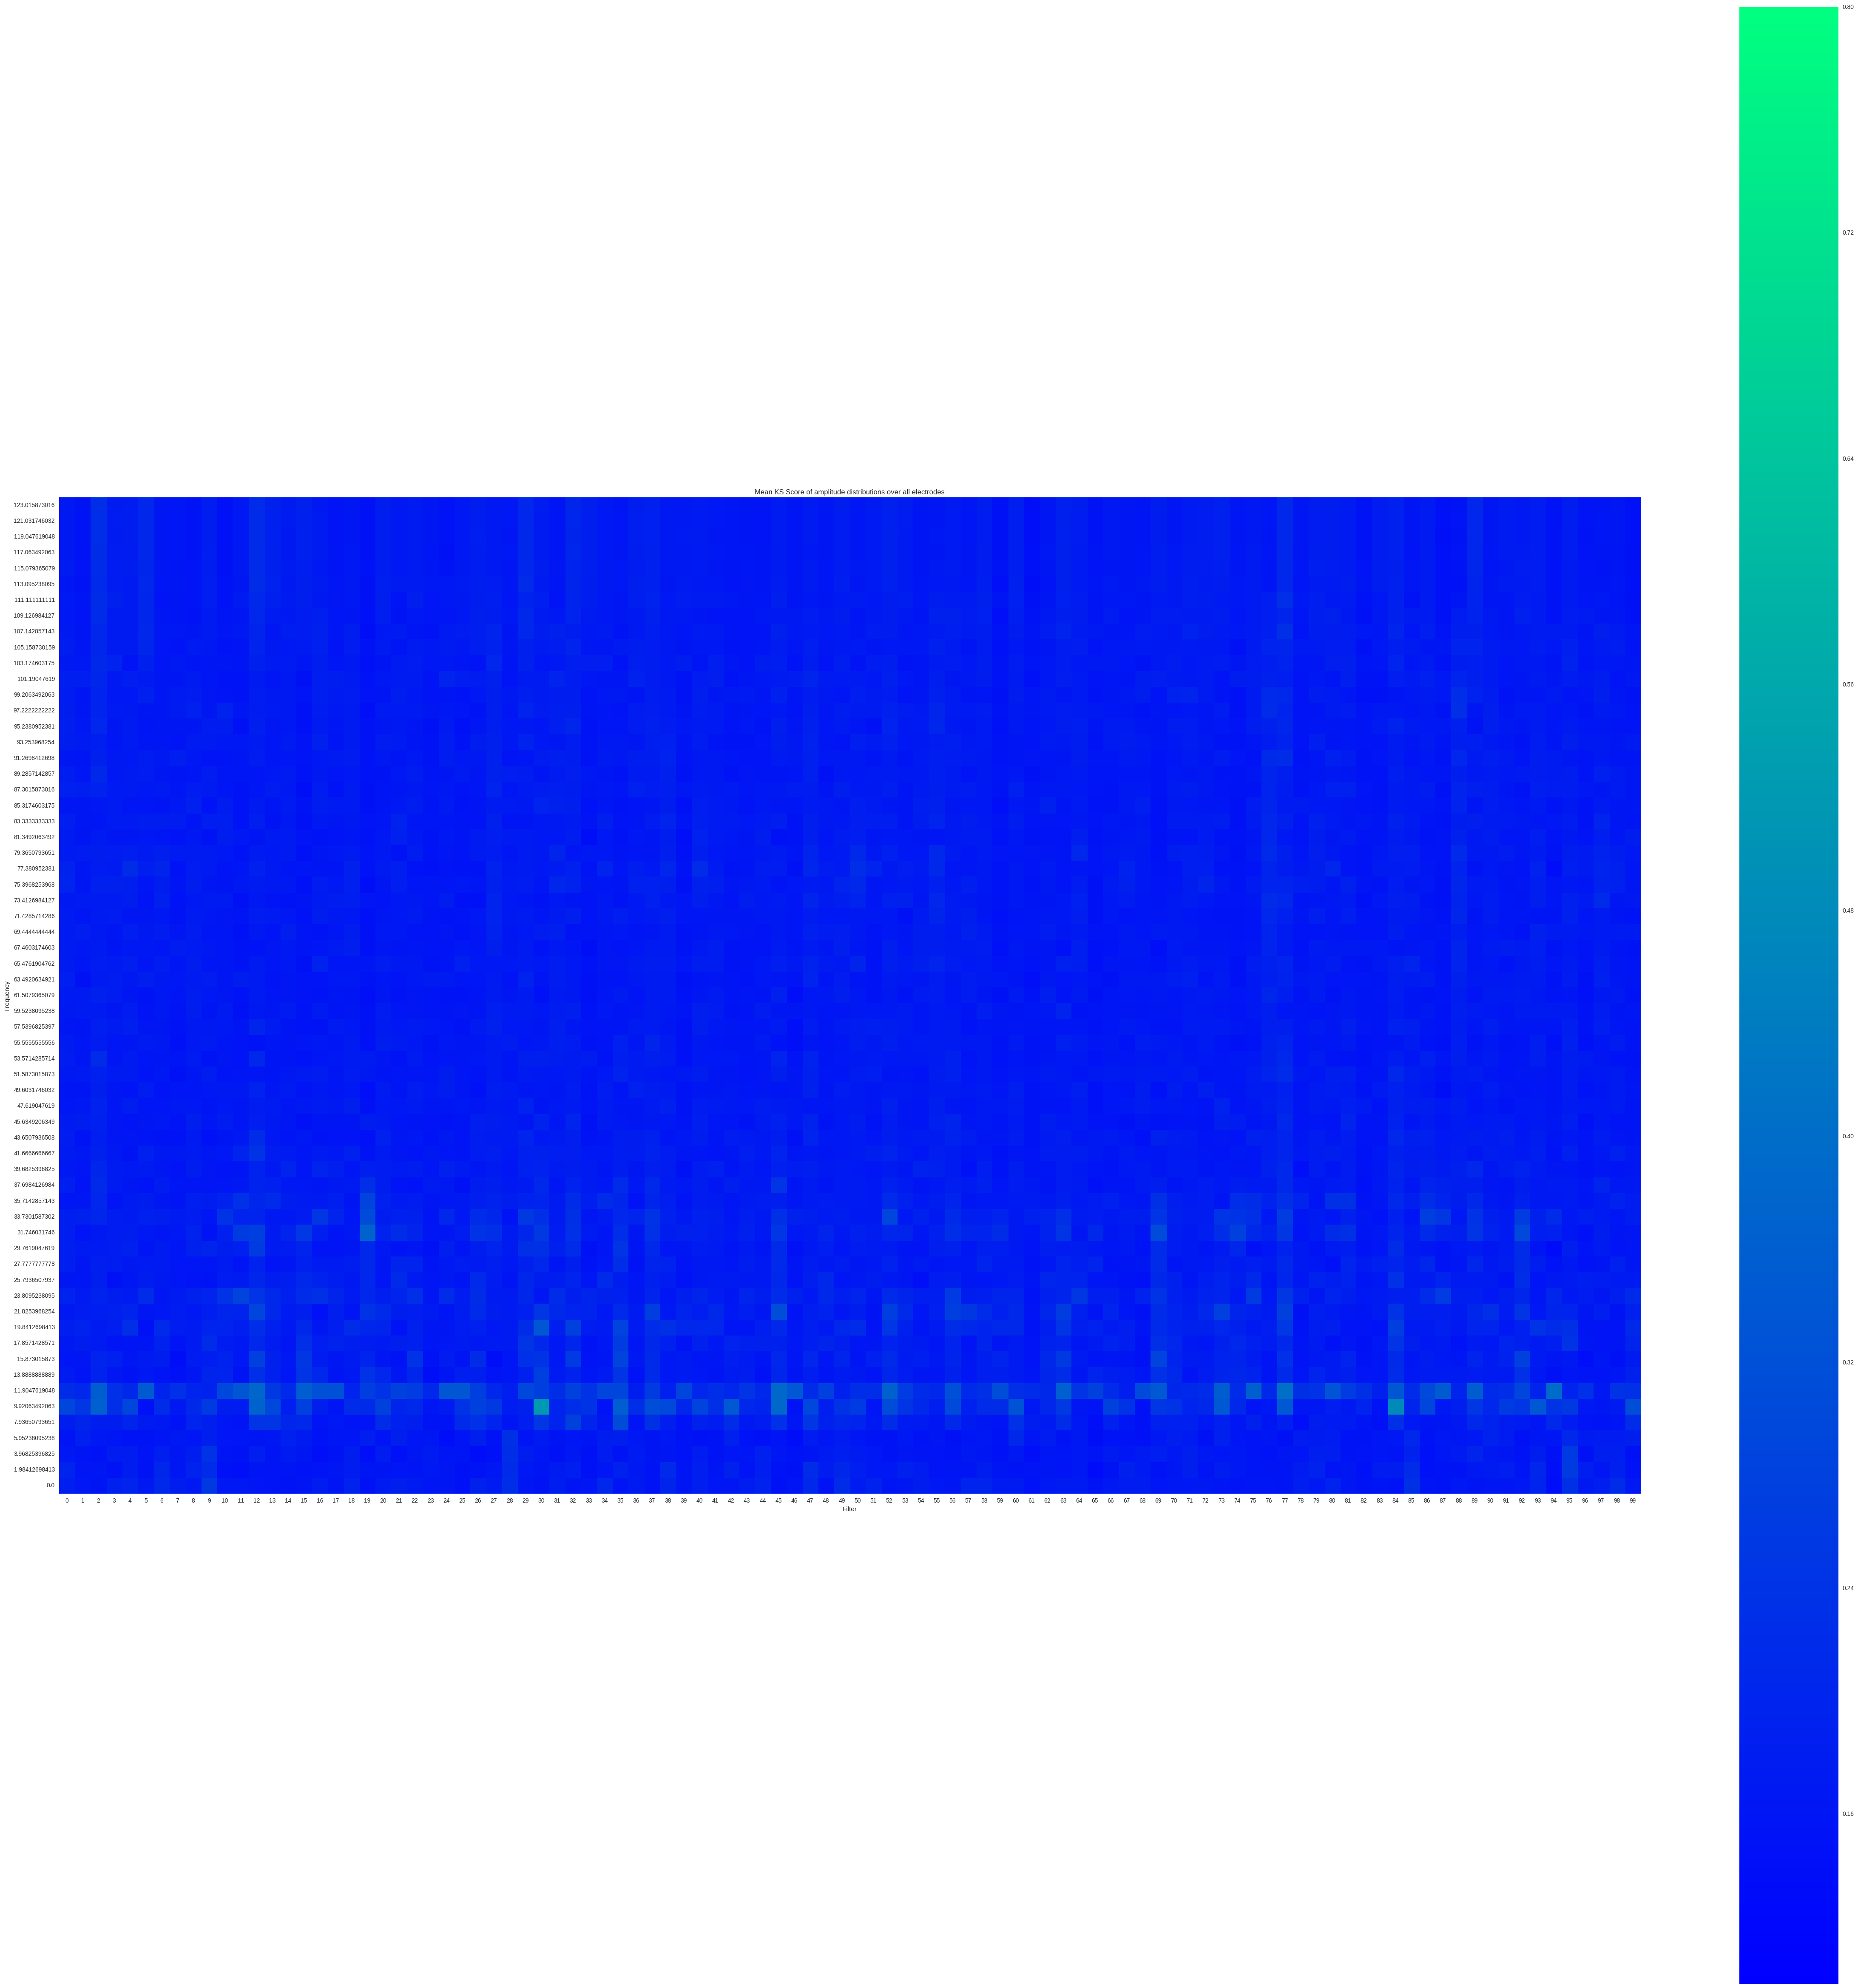

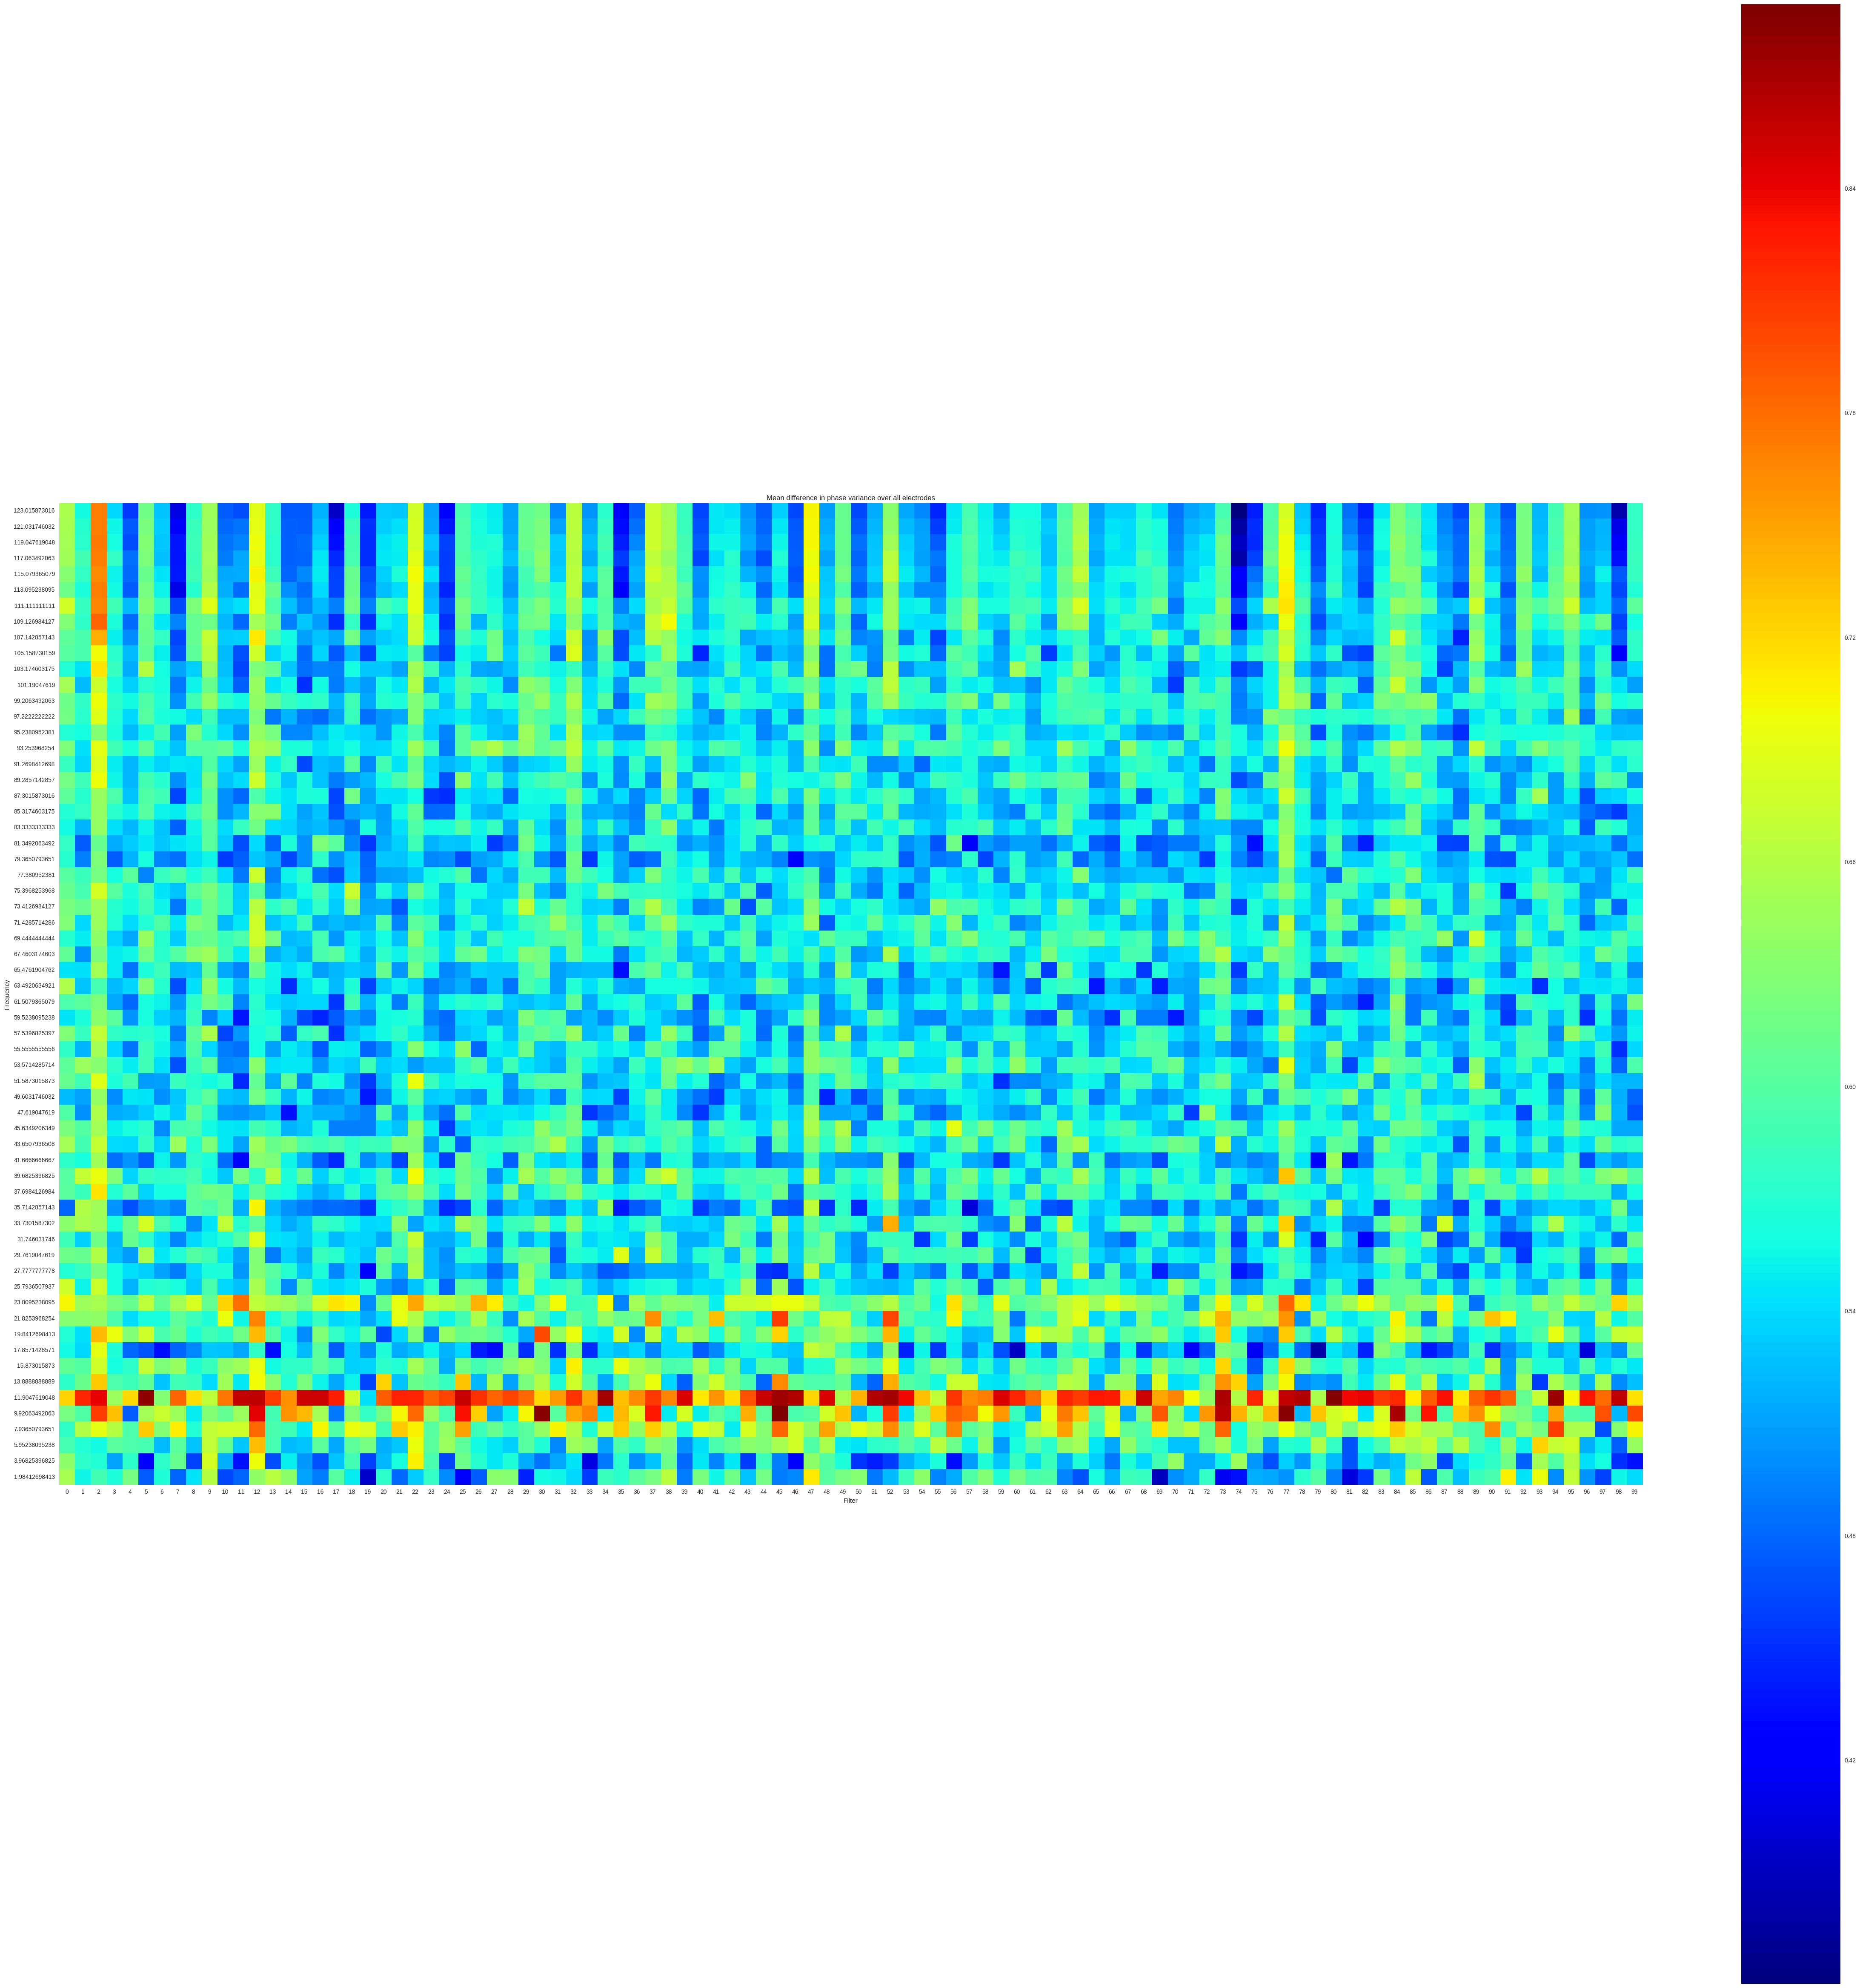

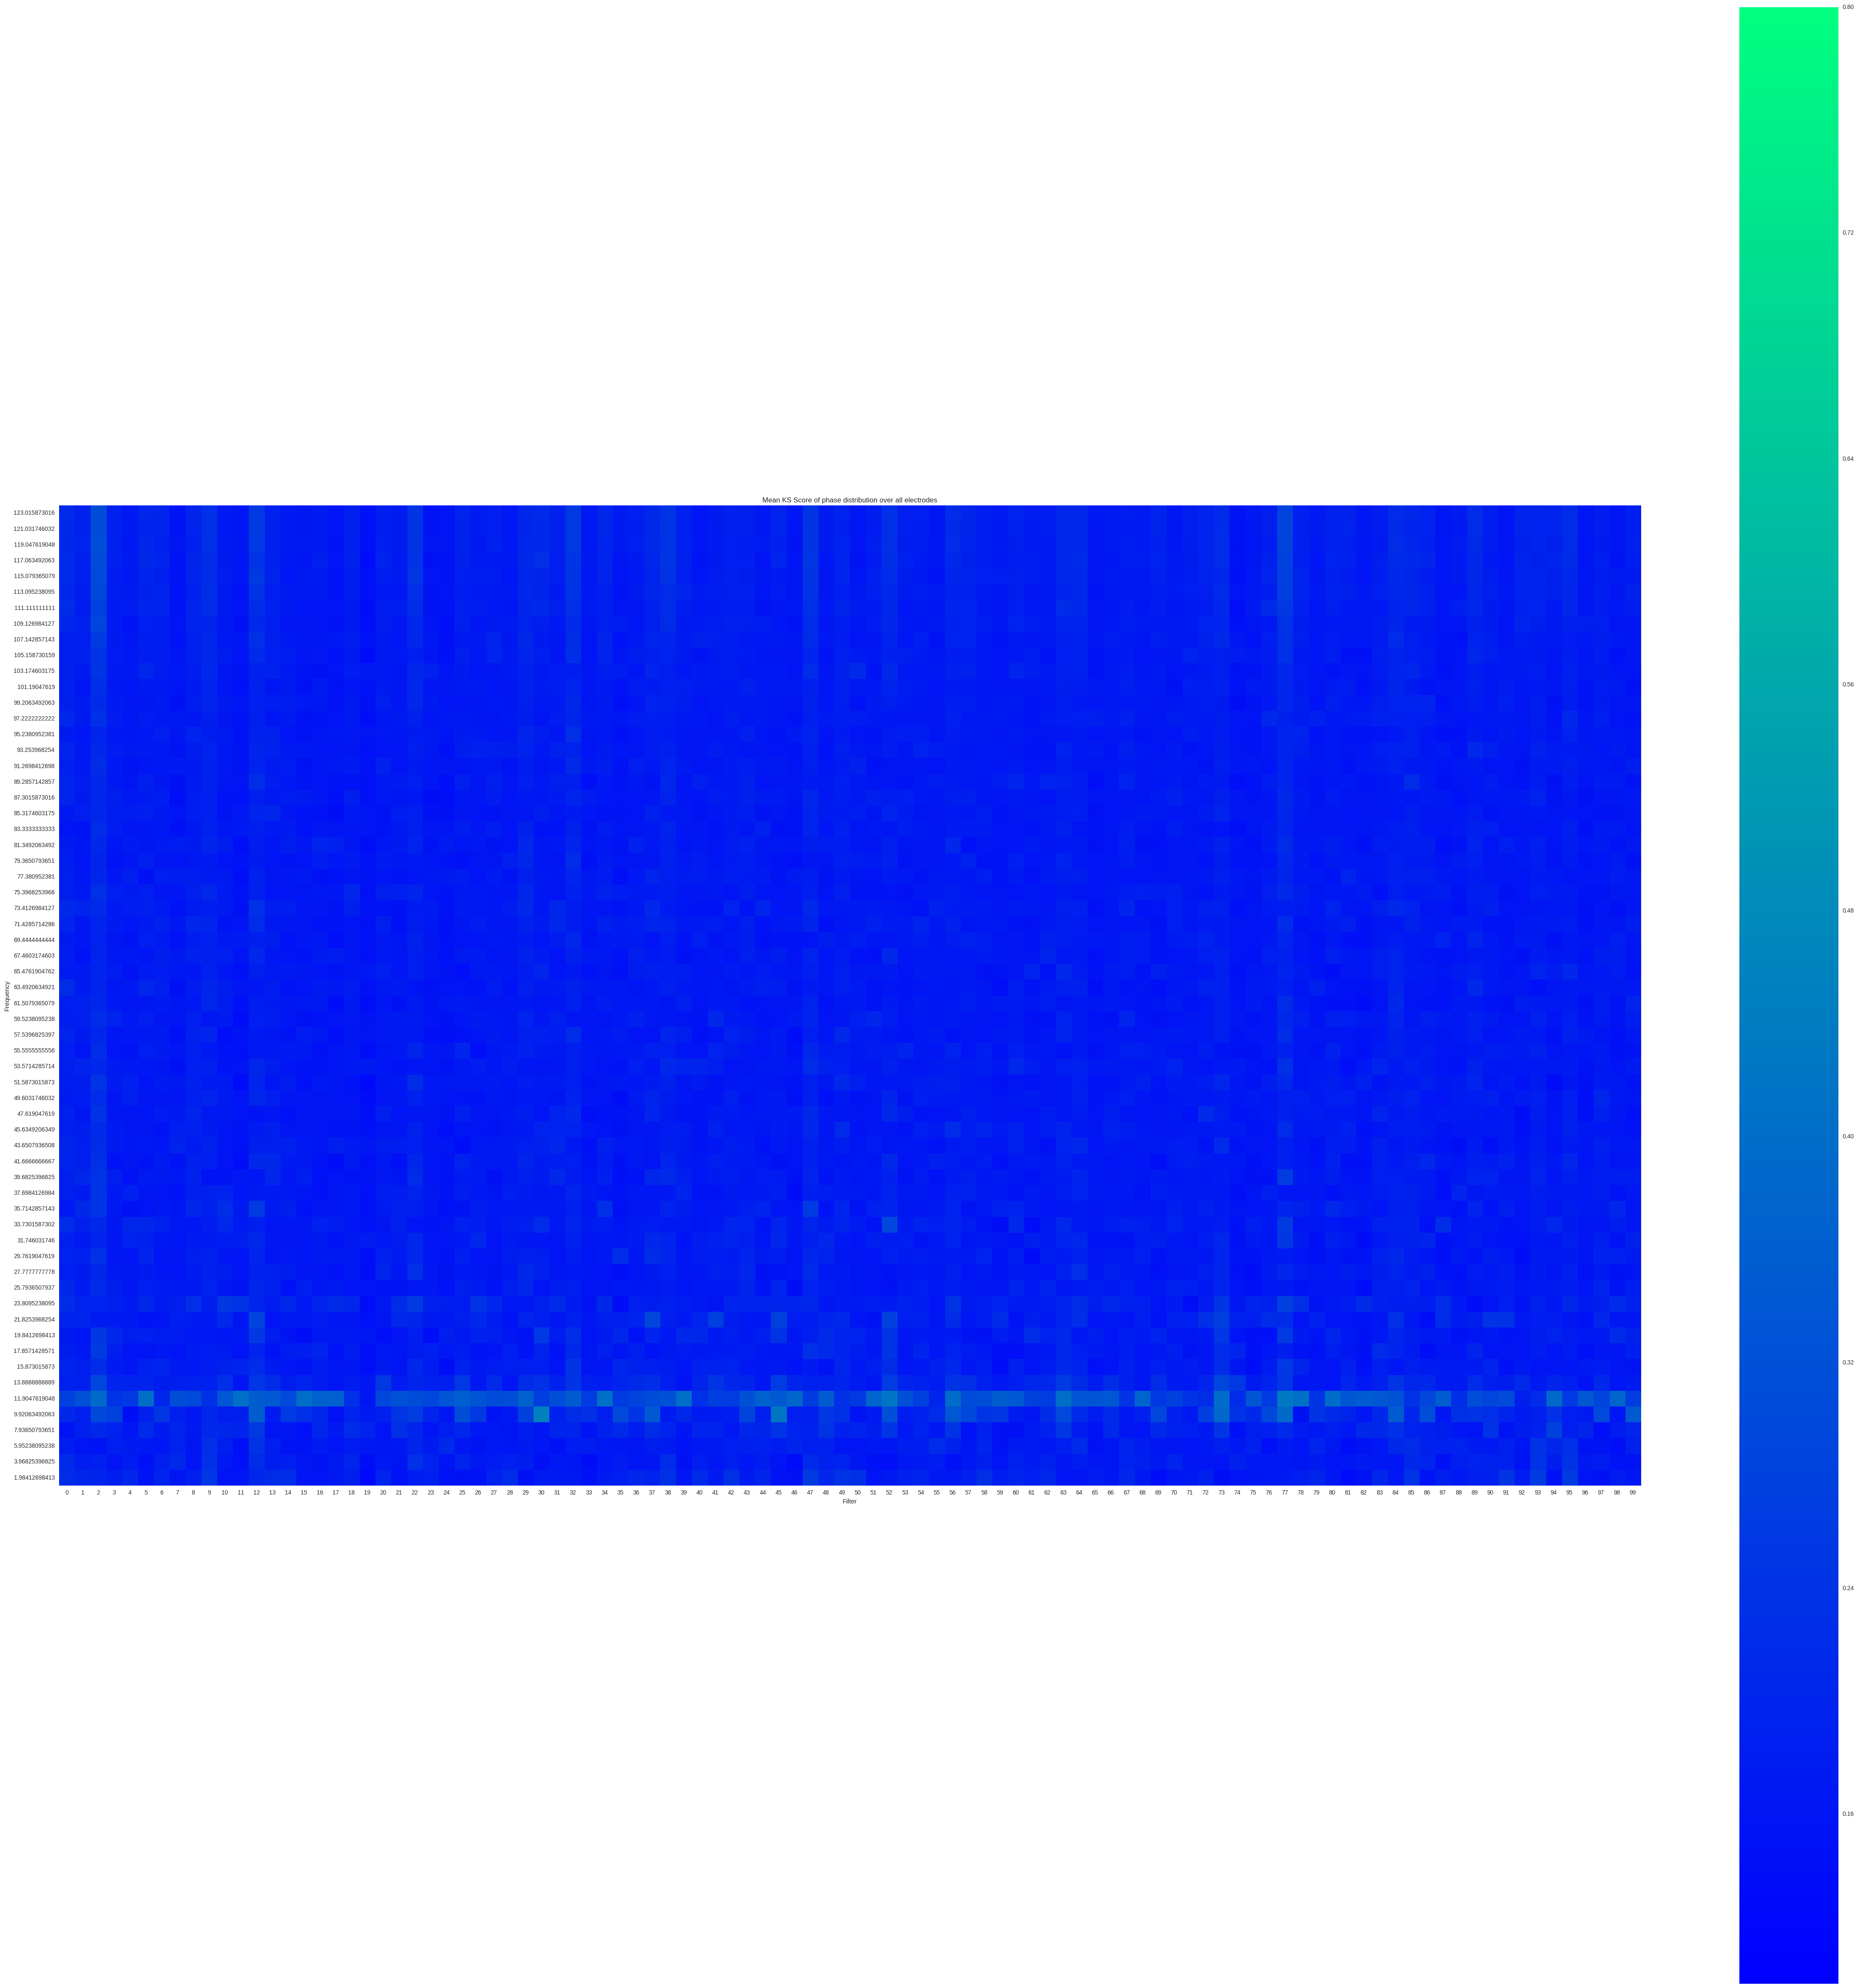

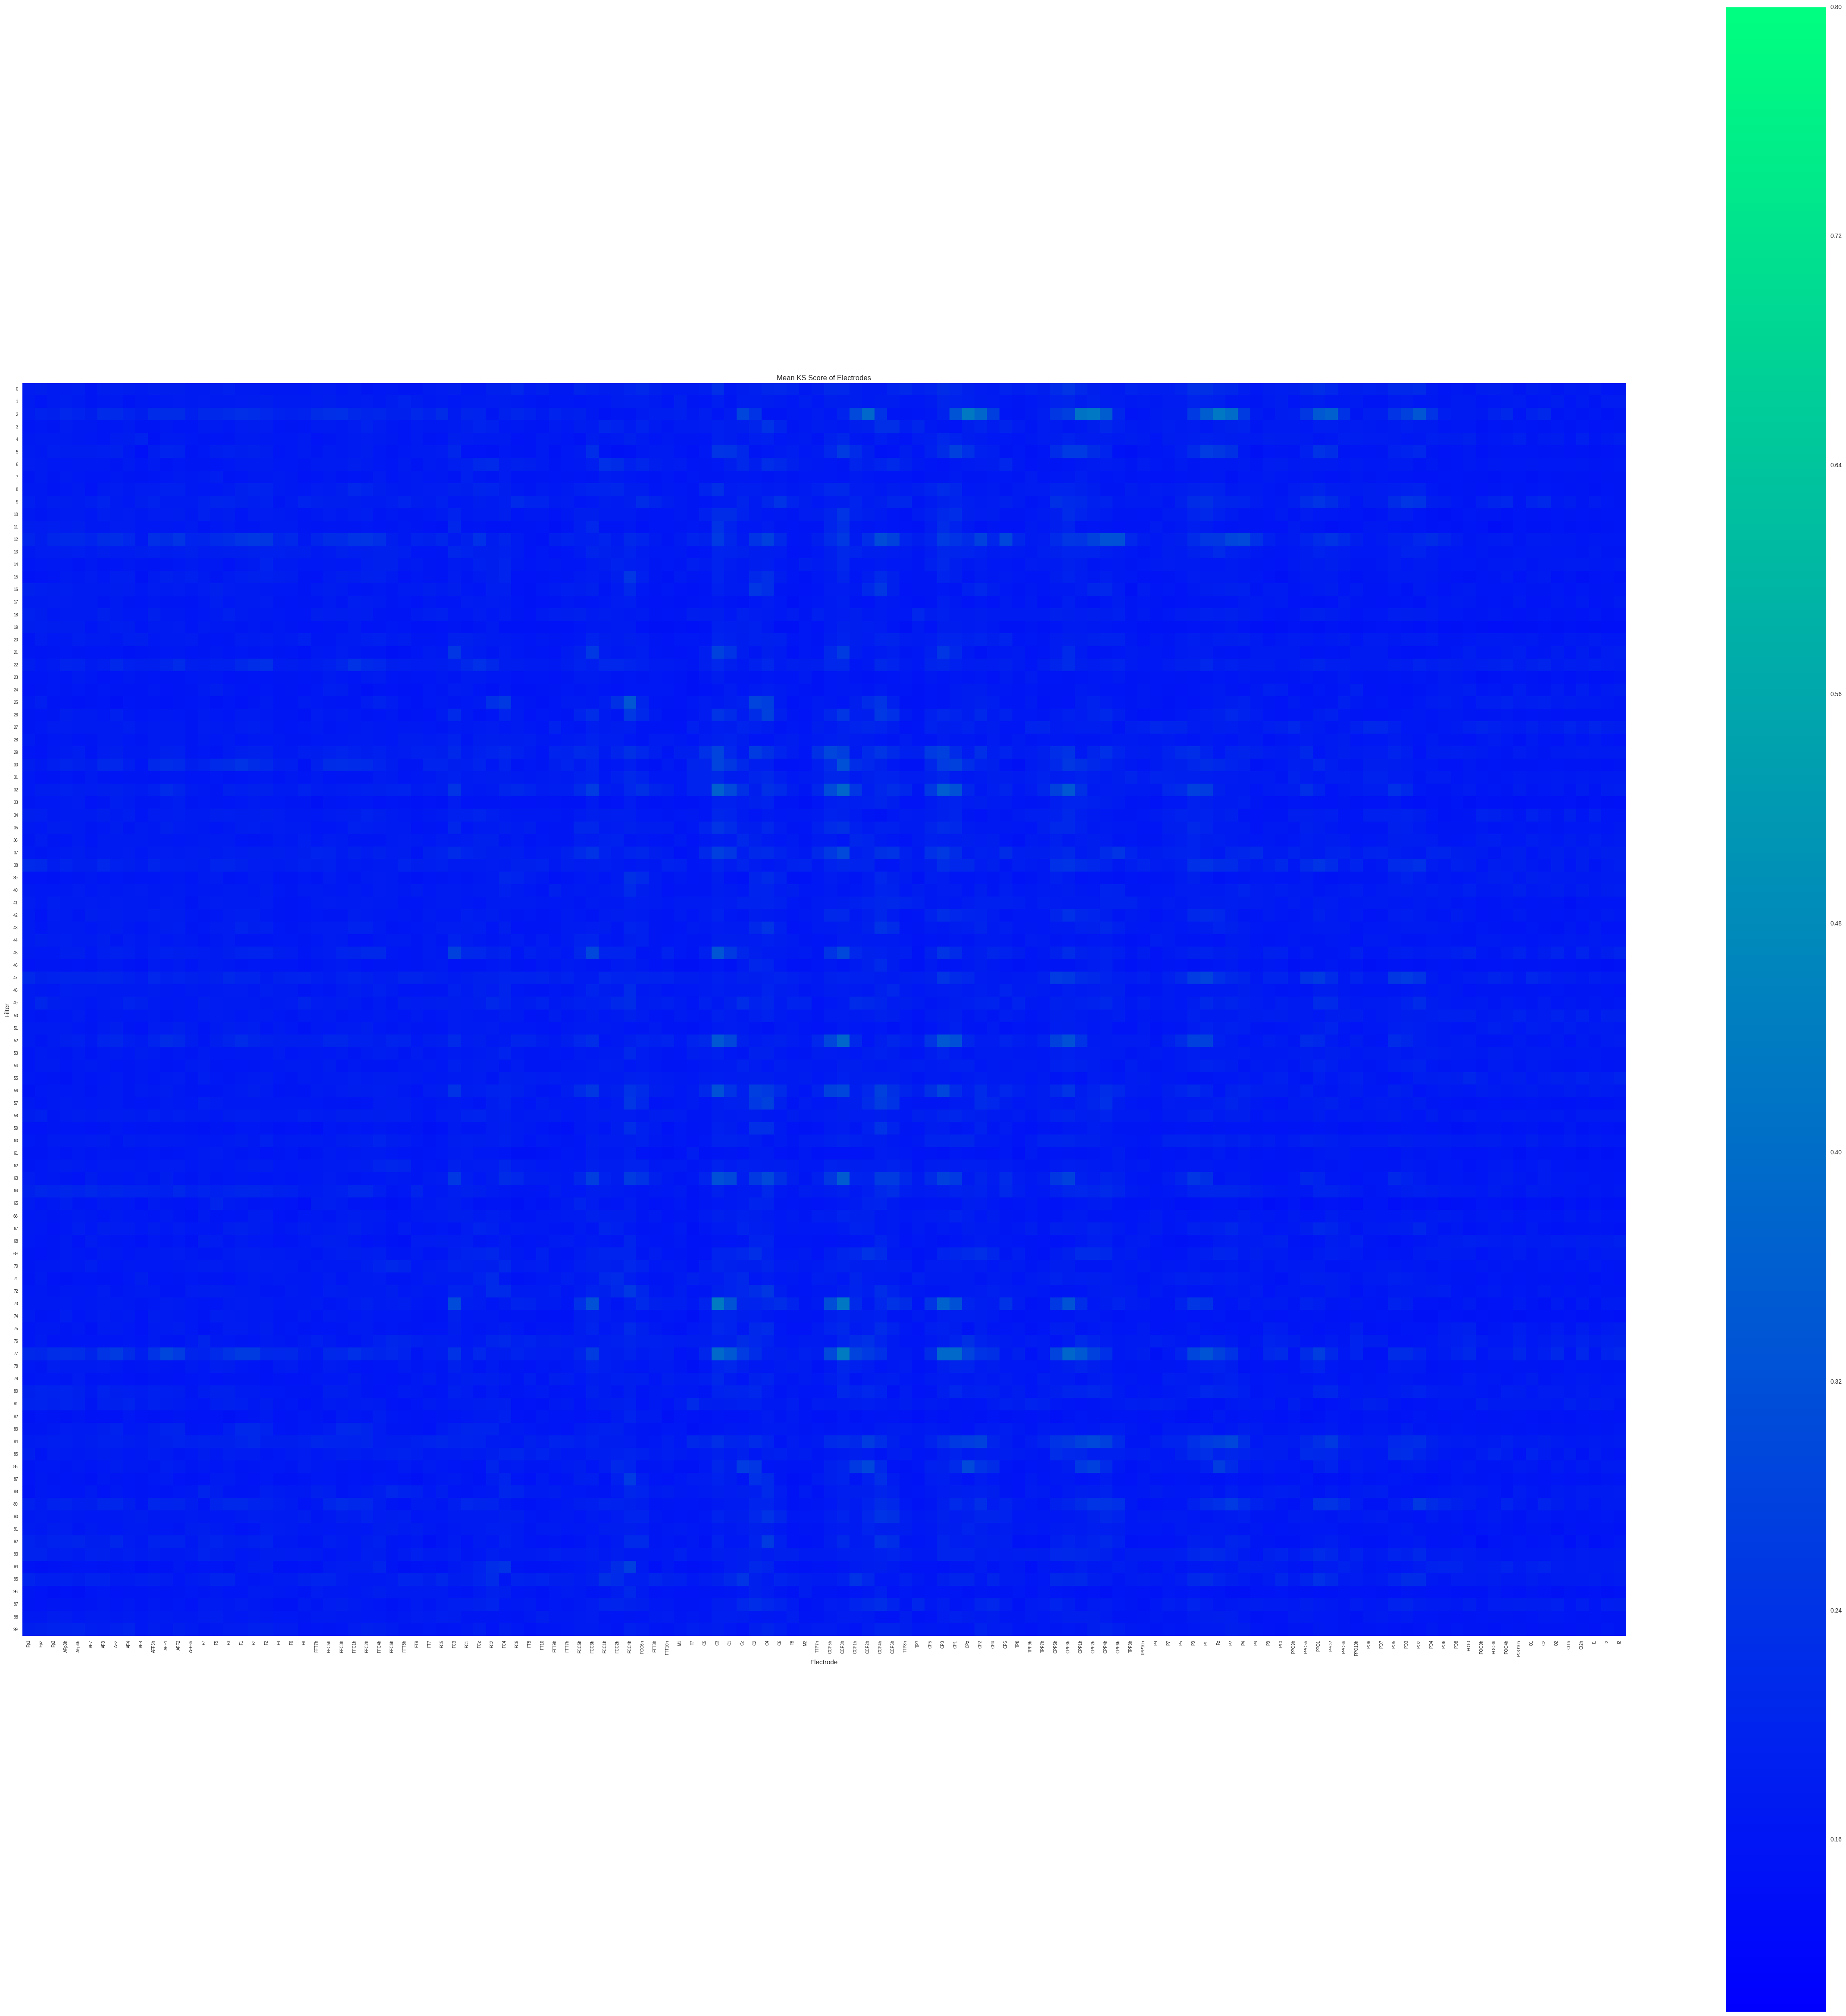

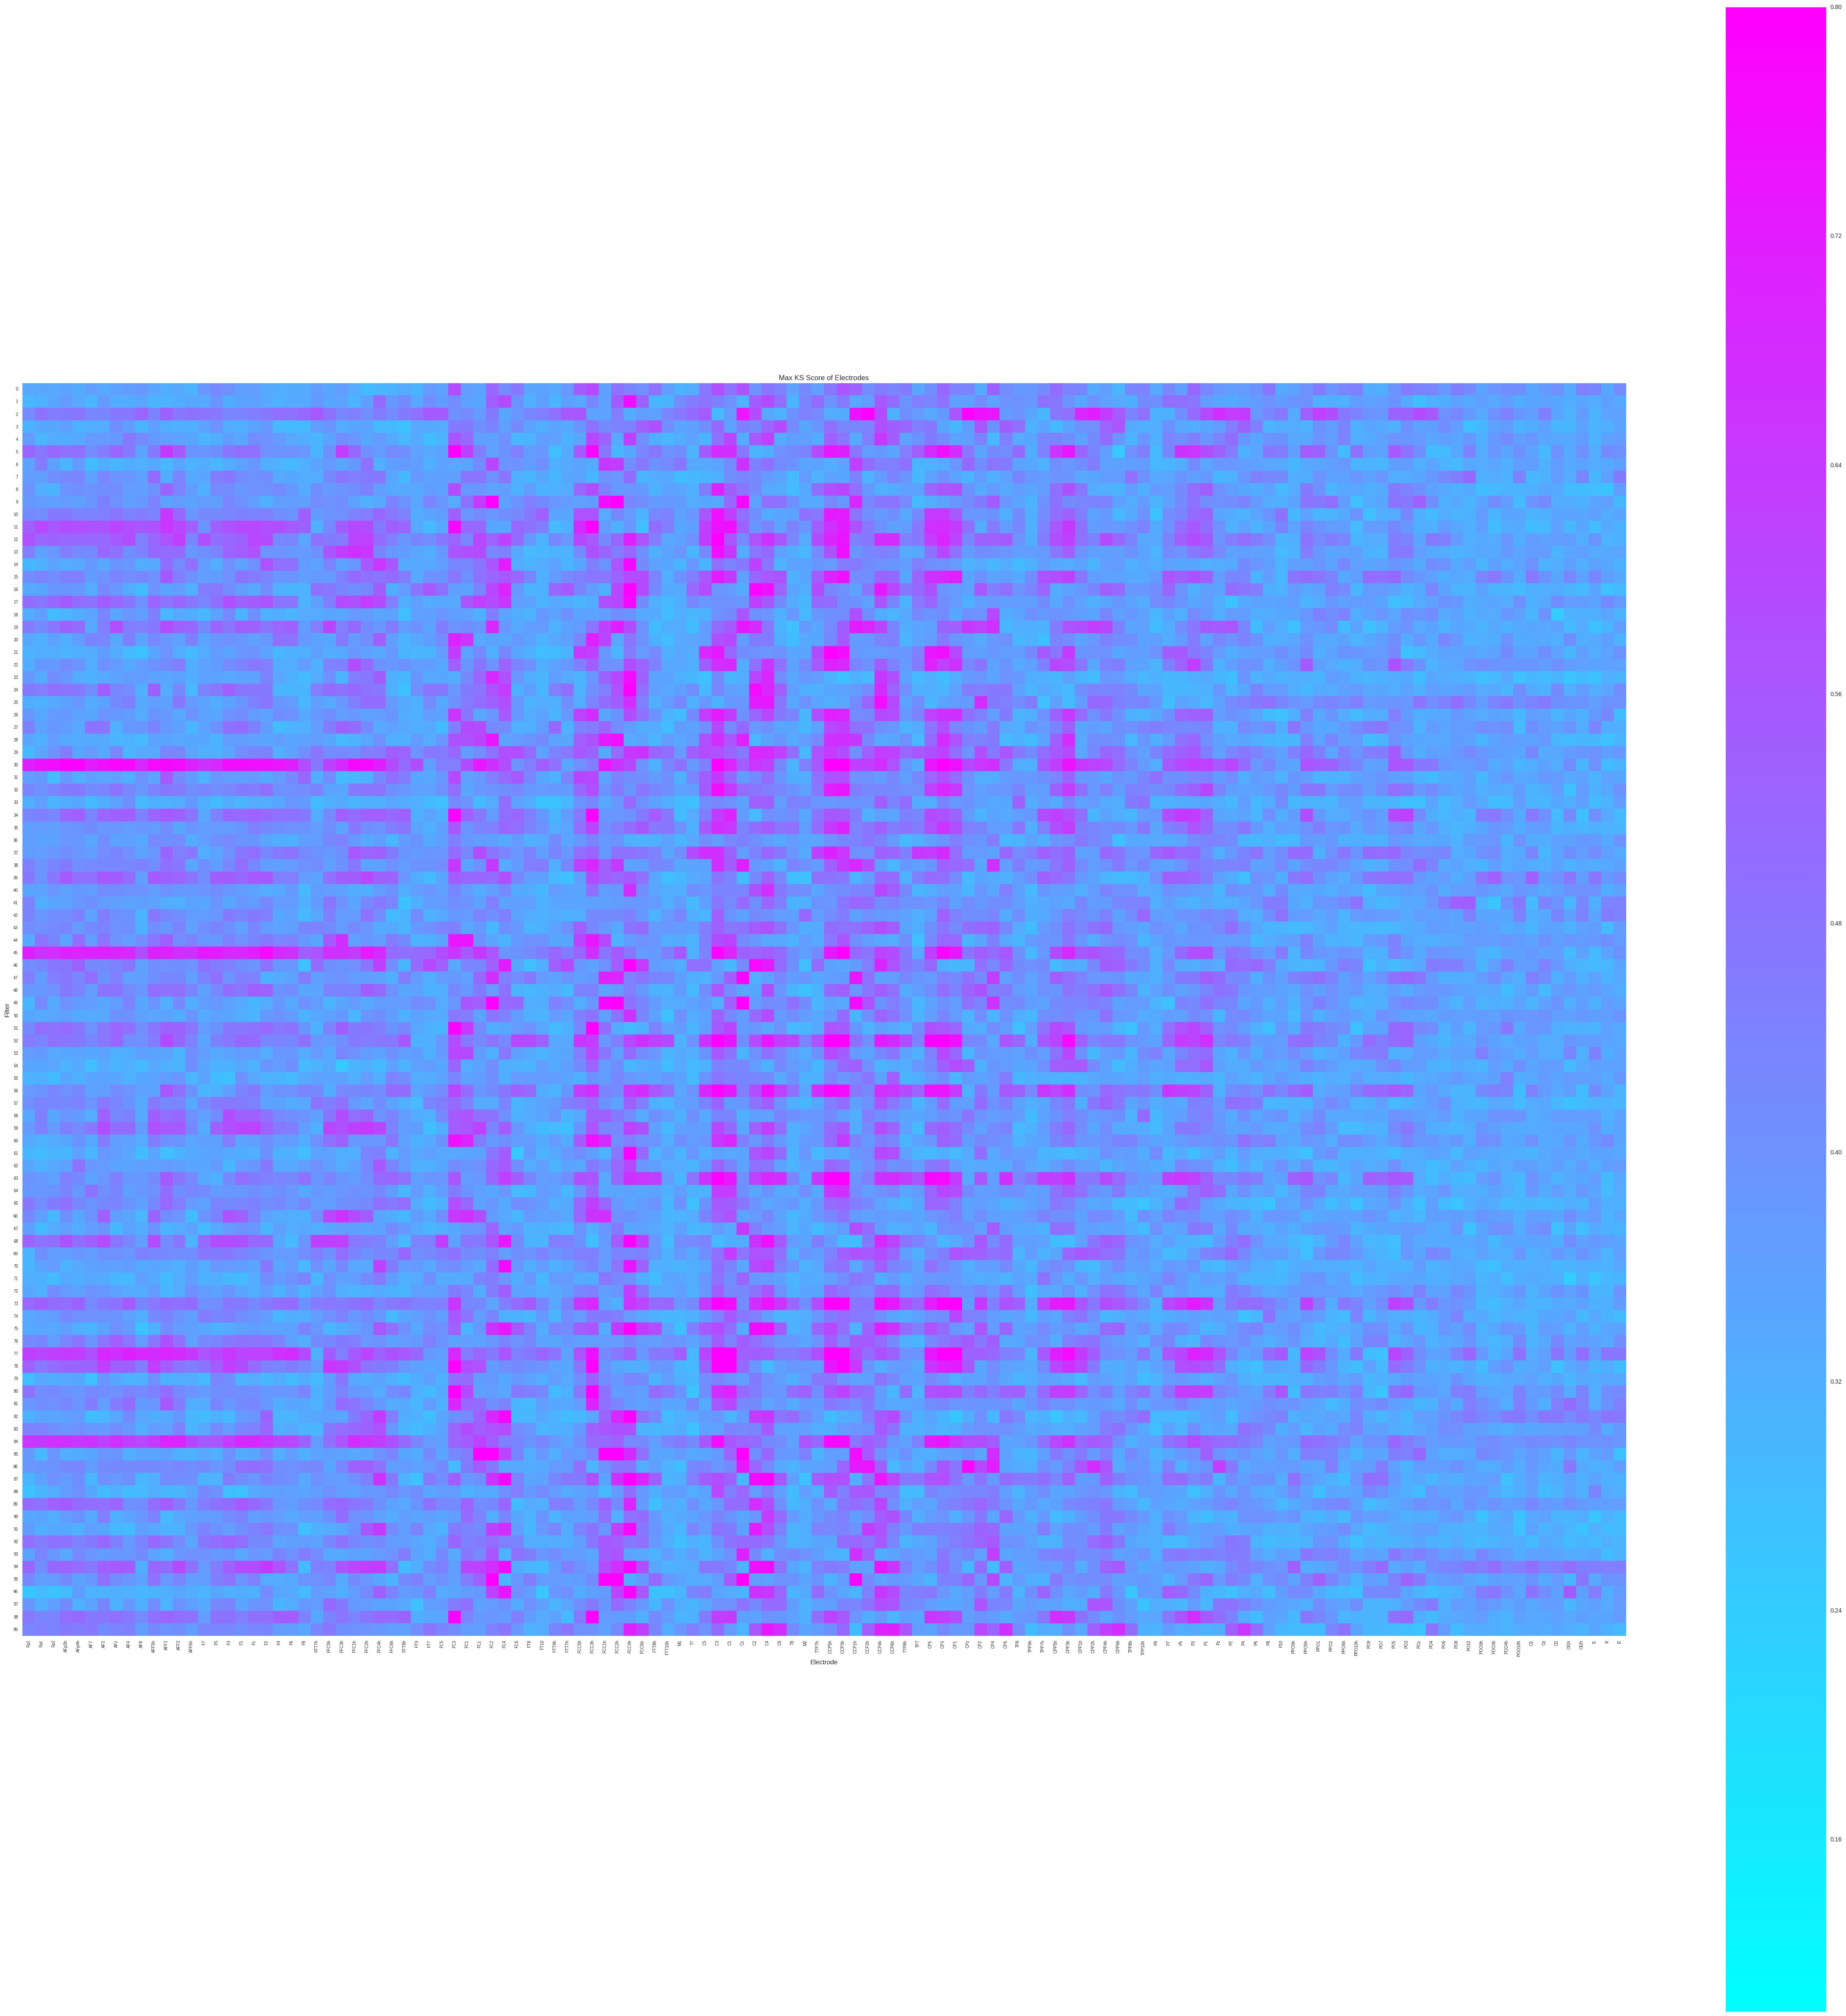

In [17]:
make_plot(FFT_diff,Phase_diff,FFT_KS,Phase_KS,Electrode_KS,Electrode_KS_max,sensor_names,frequencies)

### Layer 22

In [18]:
RF_Data = receptive_field.load_ExtractorData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'))
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'),22,None)

n_chans = RF_Data.n_chans
sensor_names = RF_Data.sensor_names
sampling_rate = RF_Data.sampling_rate

In [ ]:
FFT_diff,Phase_diff,FFT_KS,Phase_KS,Electrode_KS,Electrode_KS_max,frequencies = make_data(RF_Result,n_chans)


(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 1000) [100, 128, -1] (4953600,) ([0], 128, -1)
(100, 128, 100

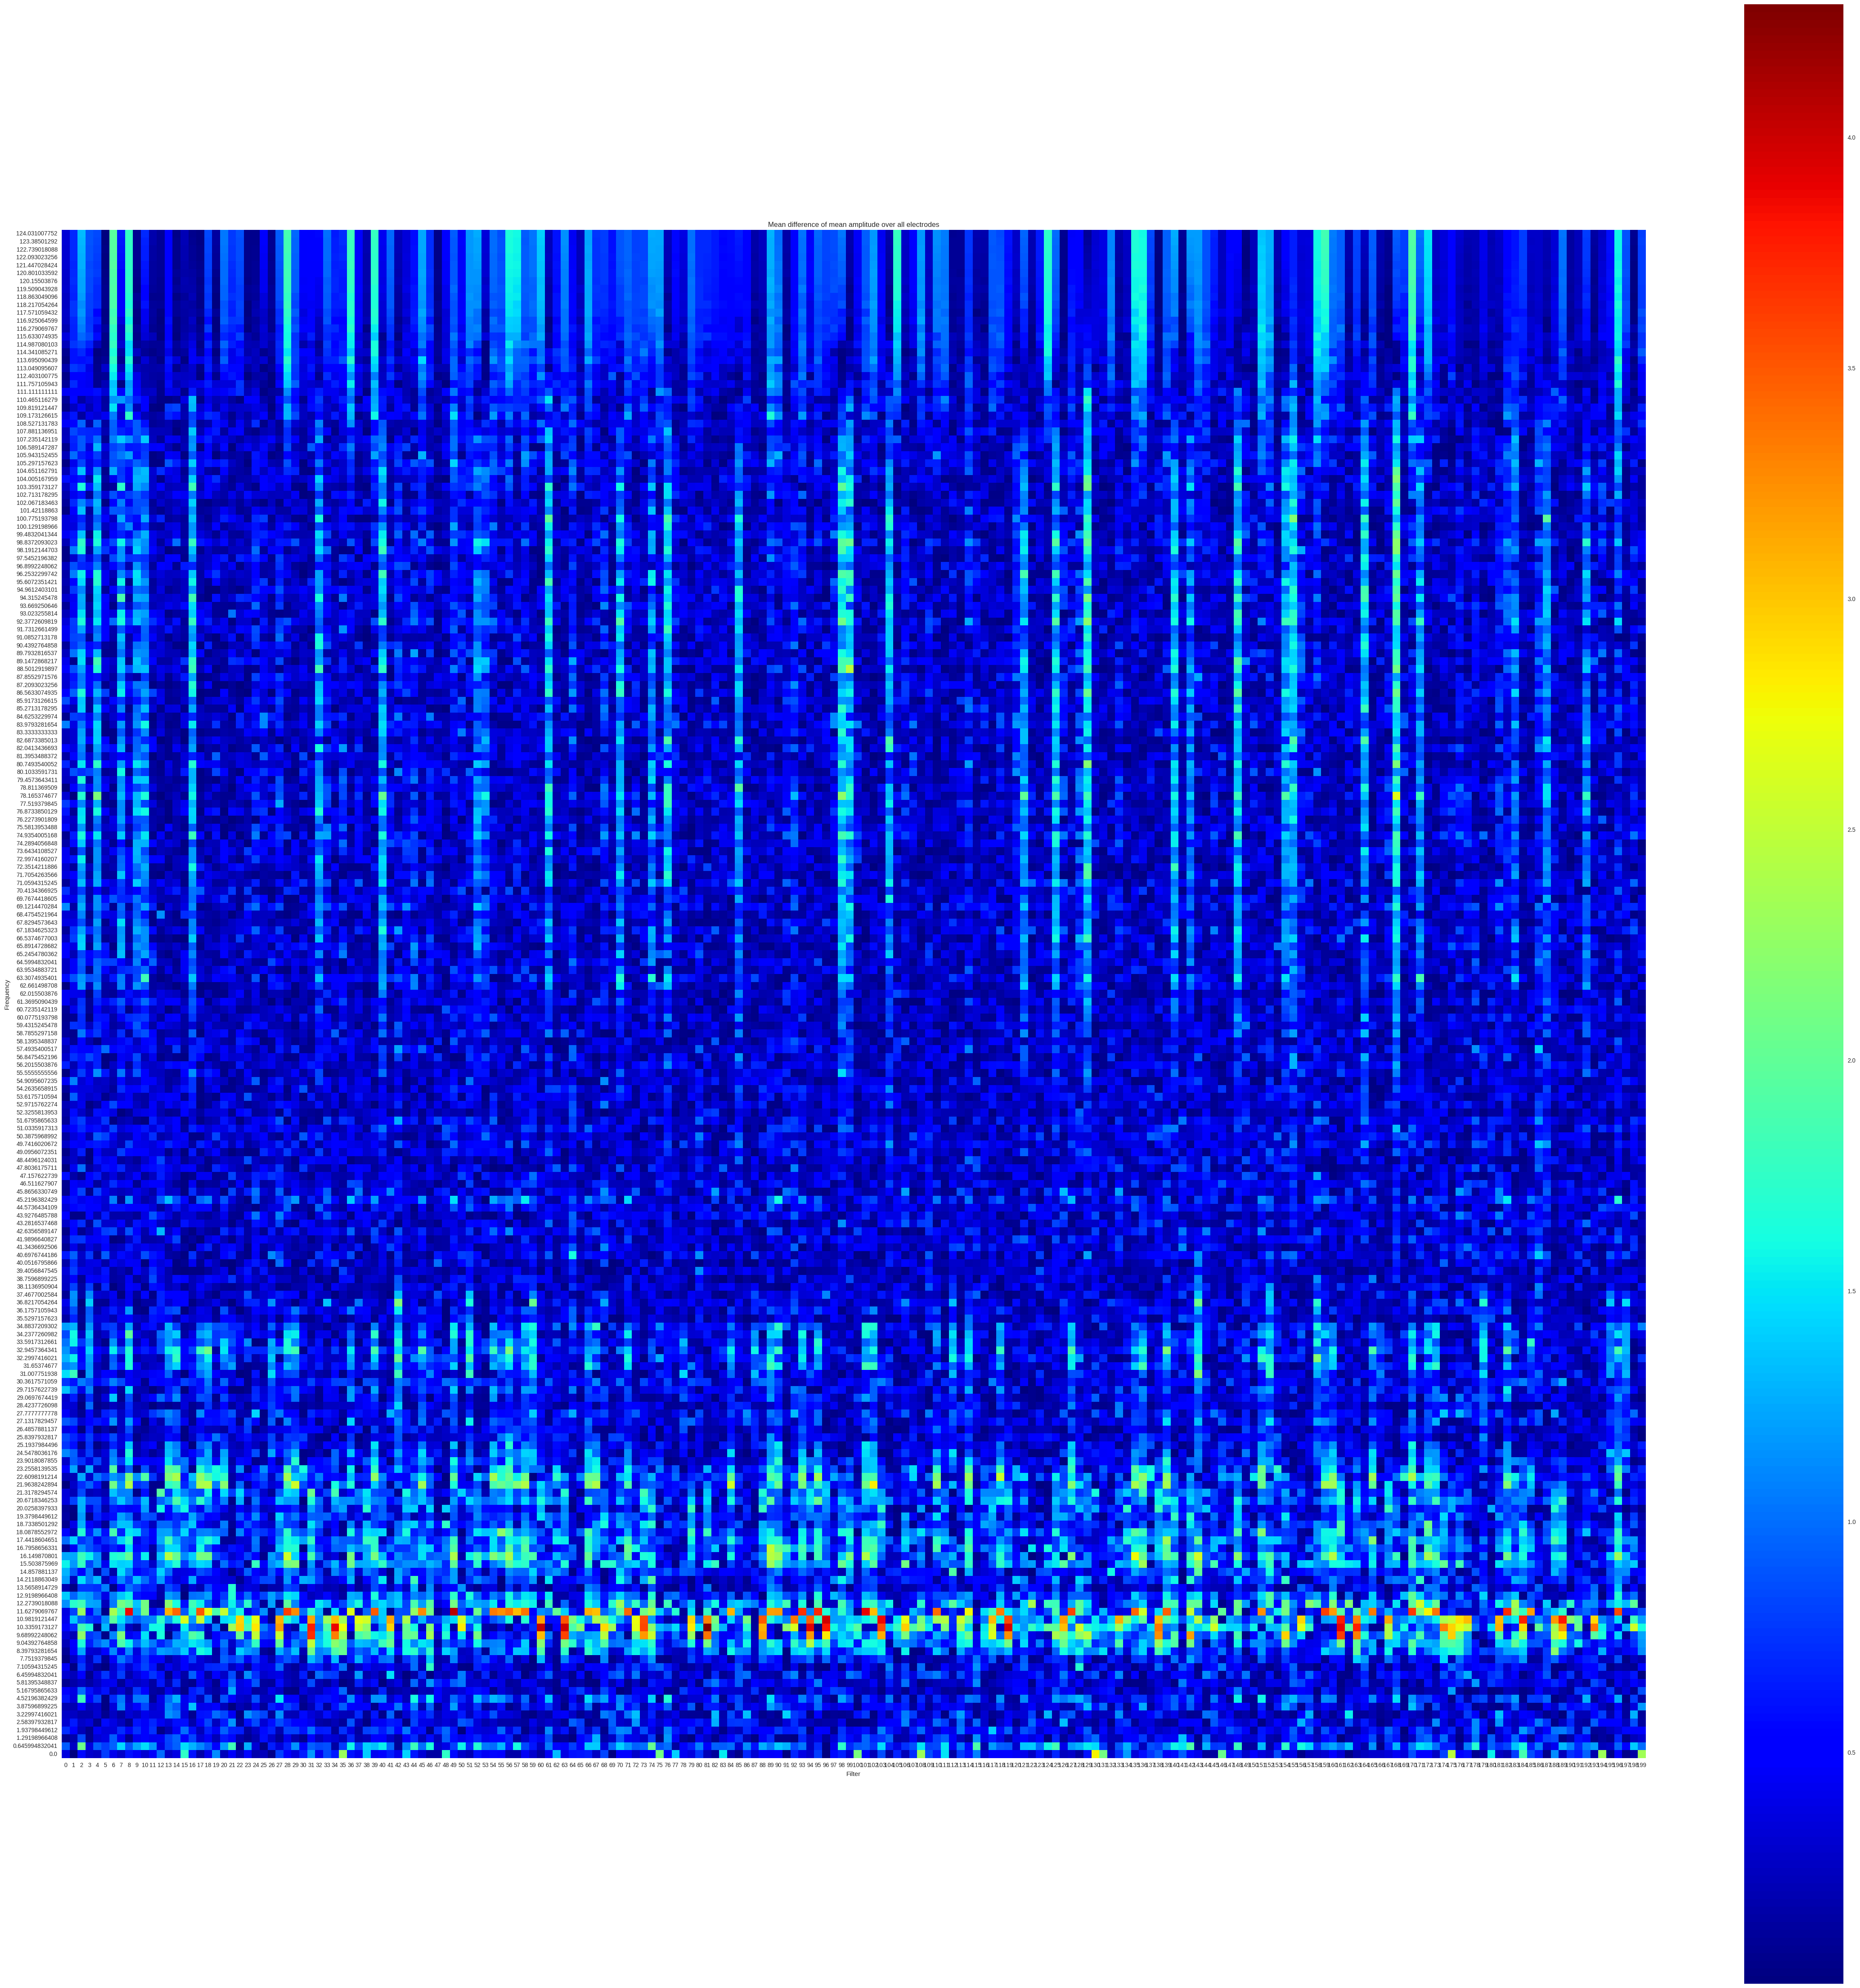

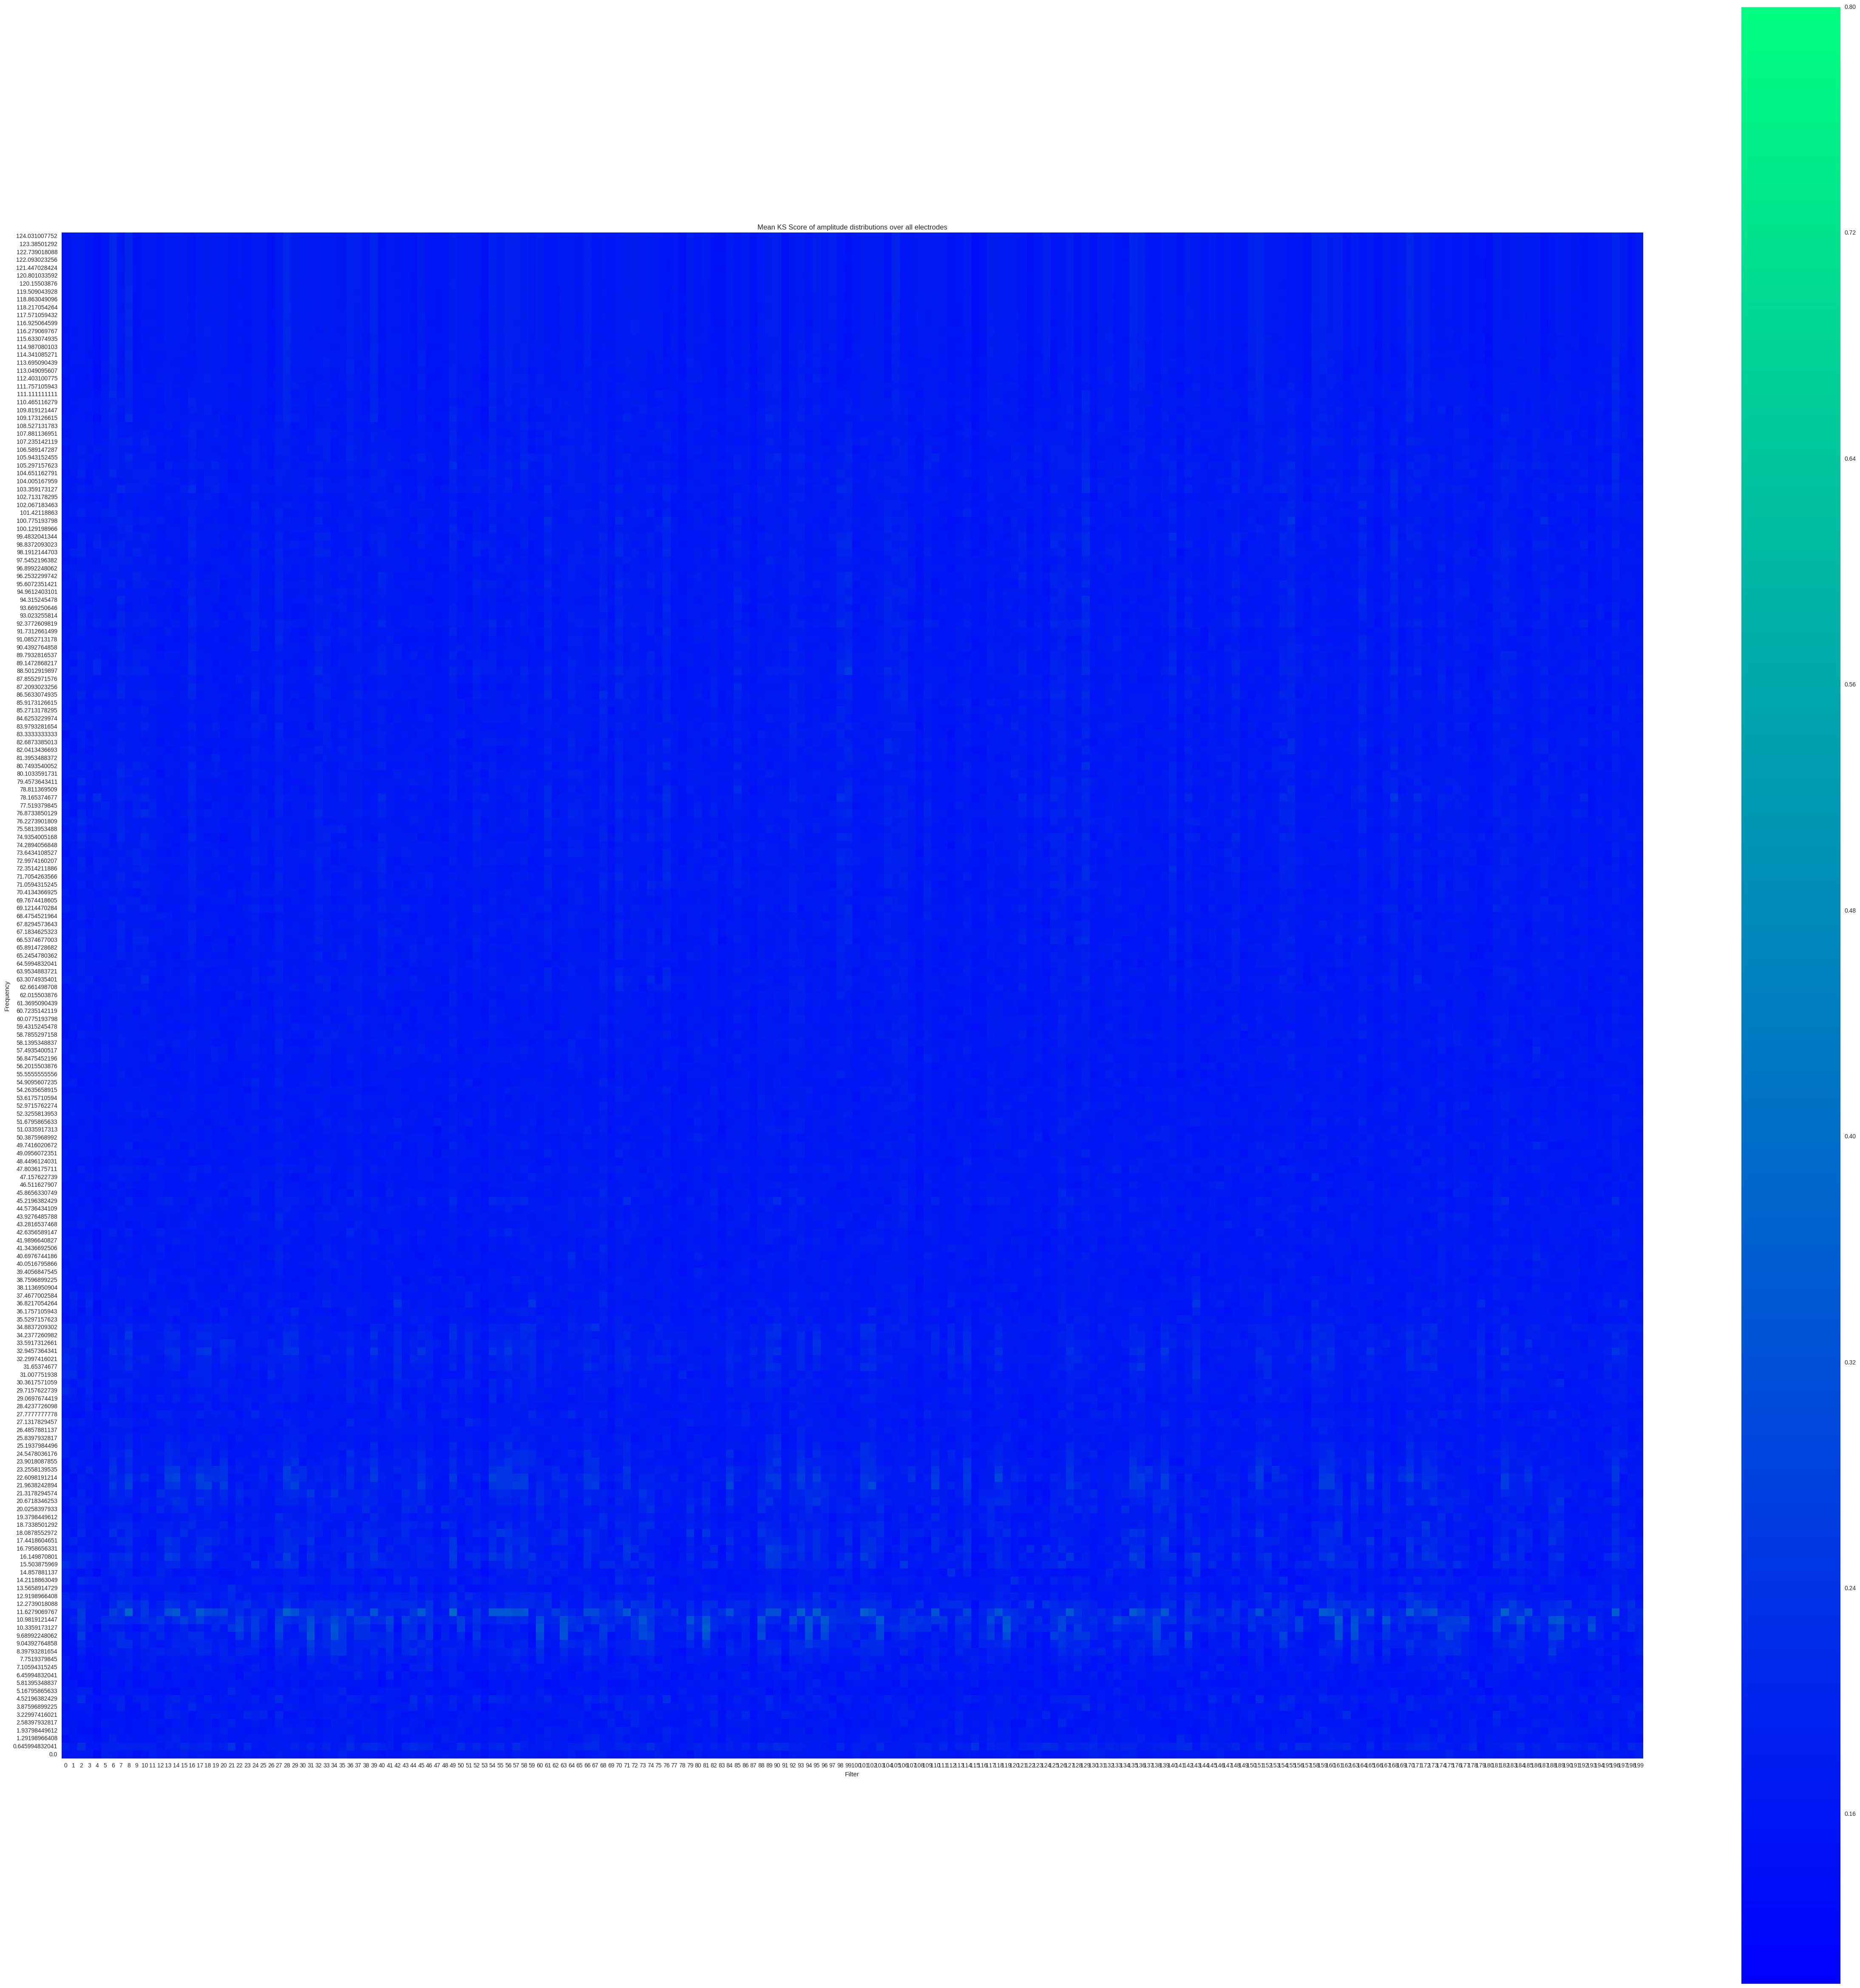

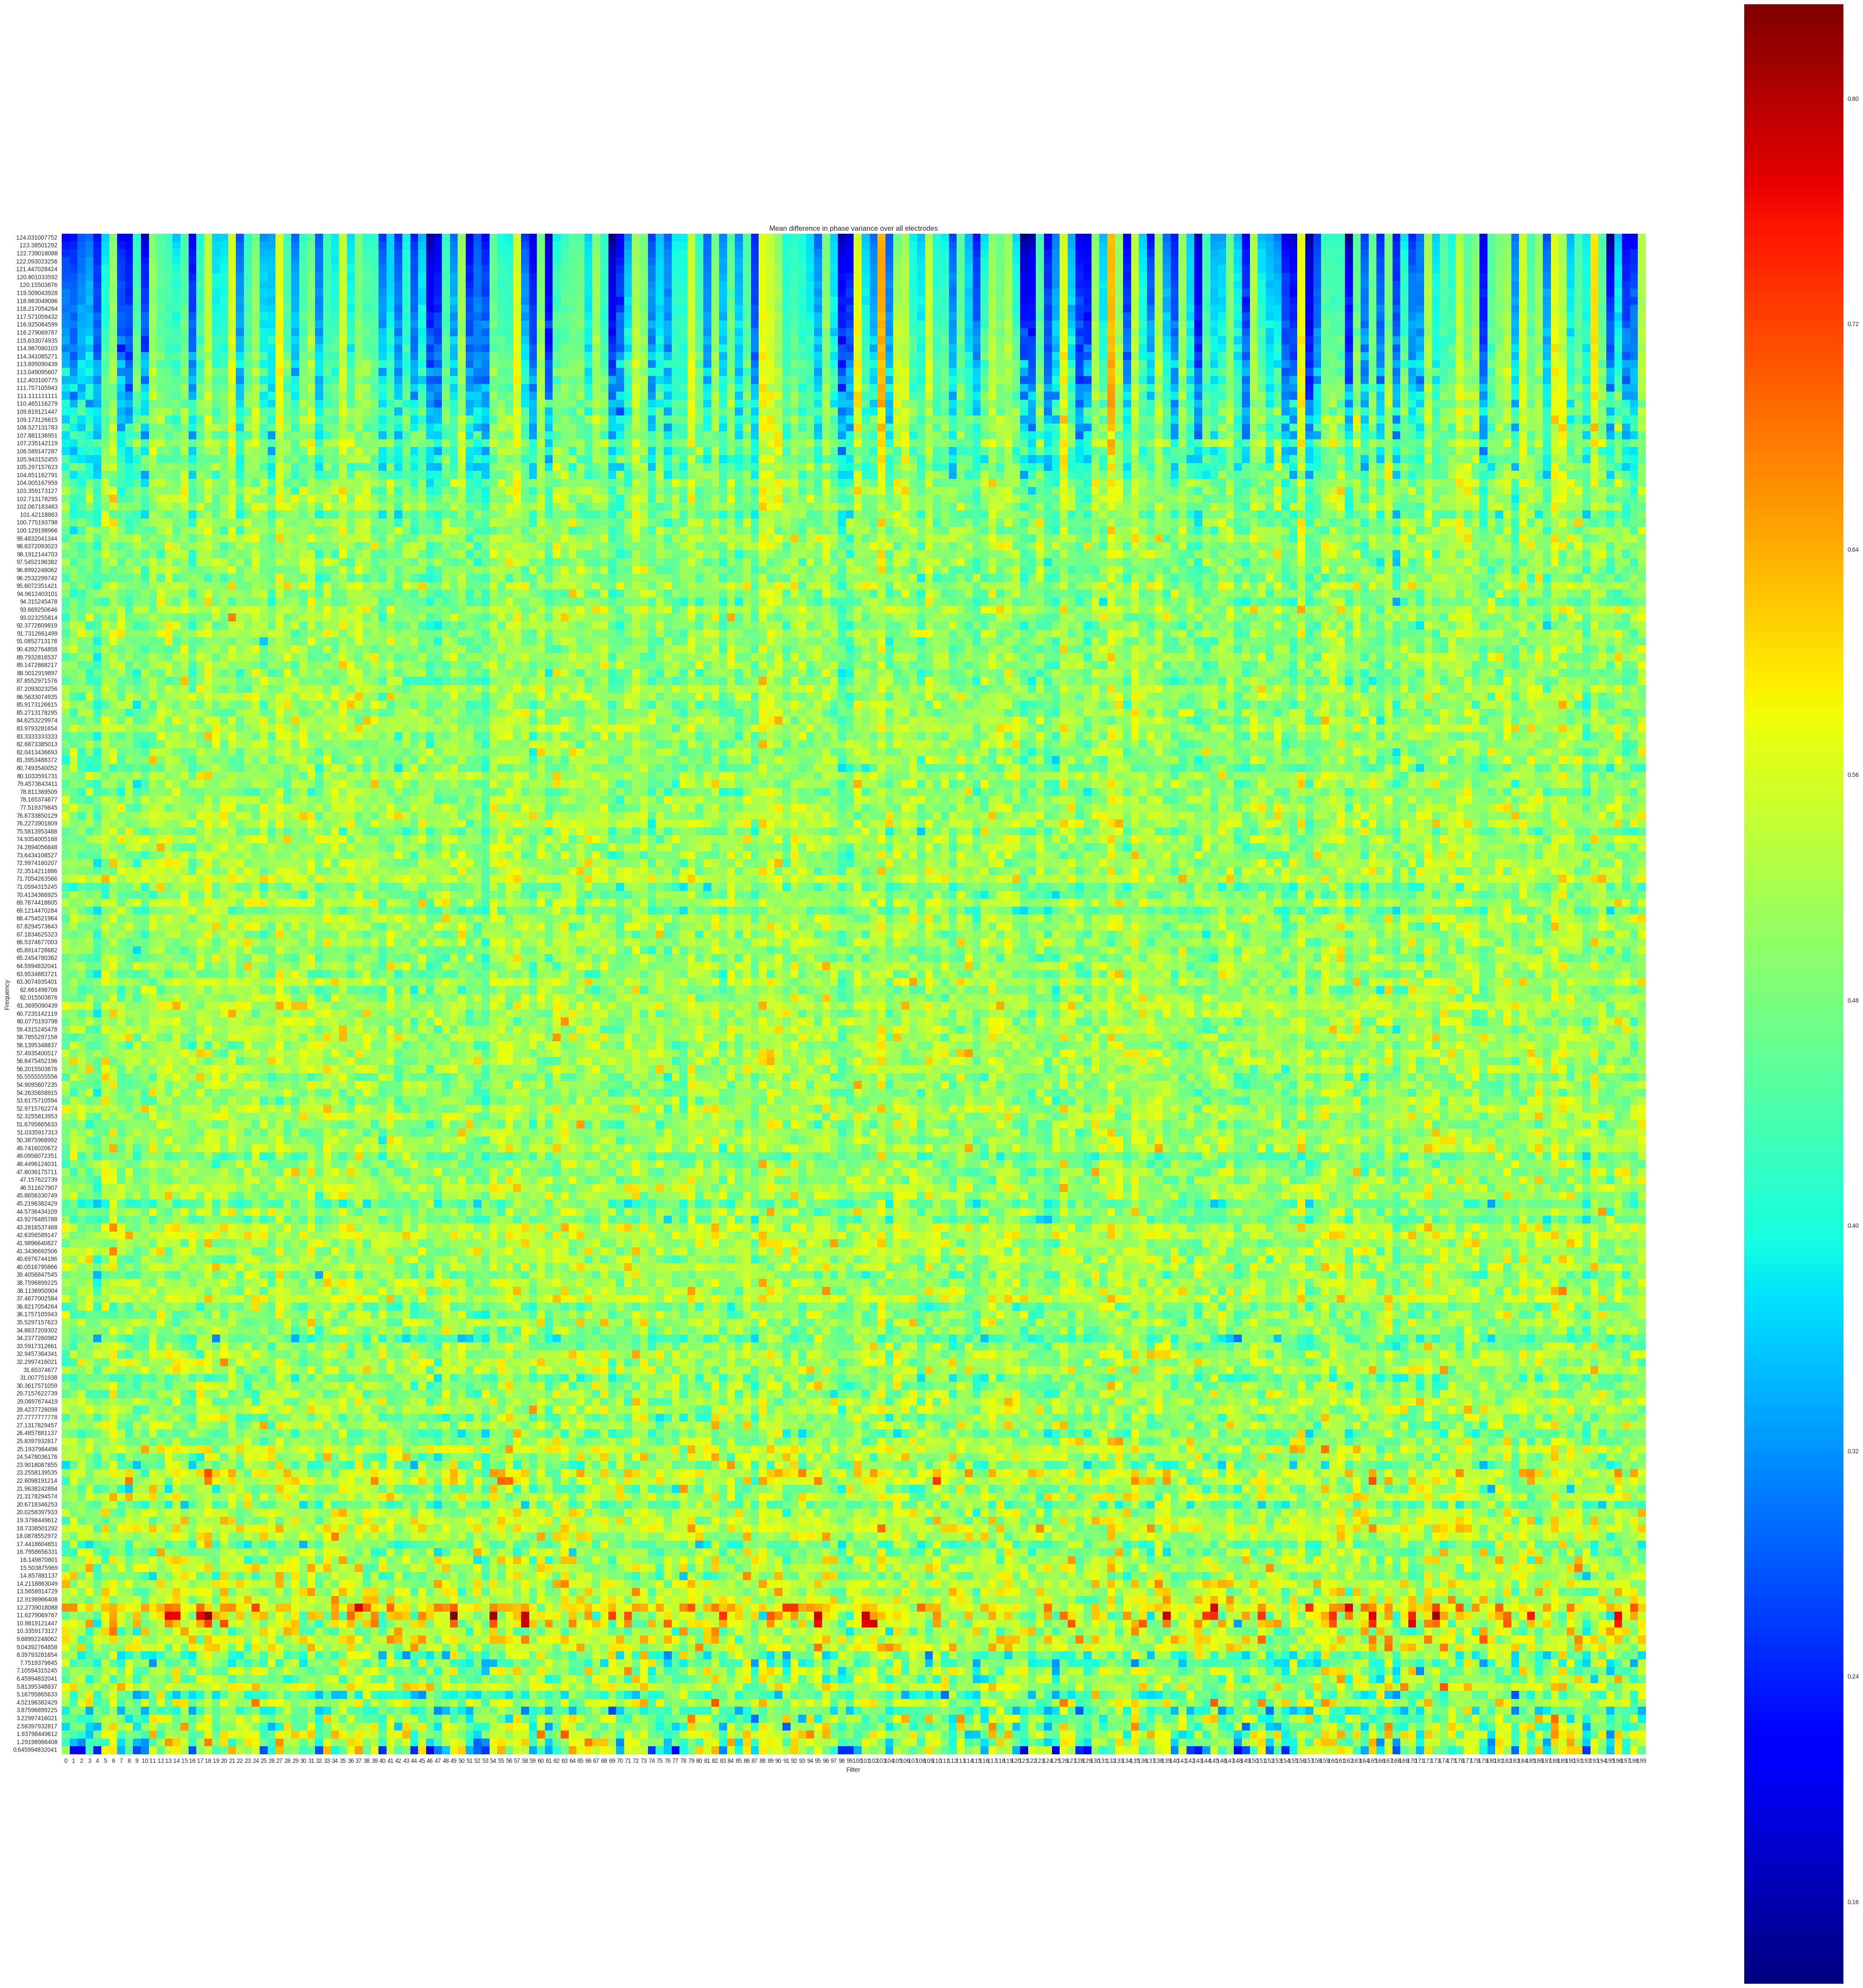

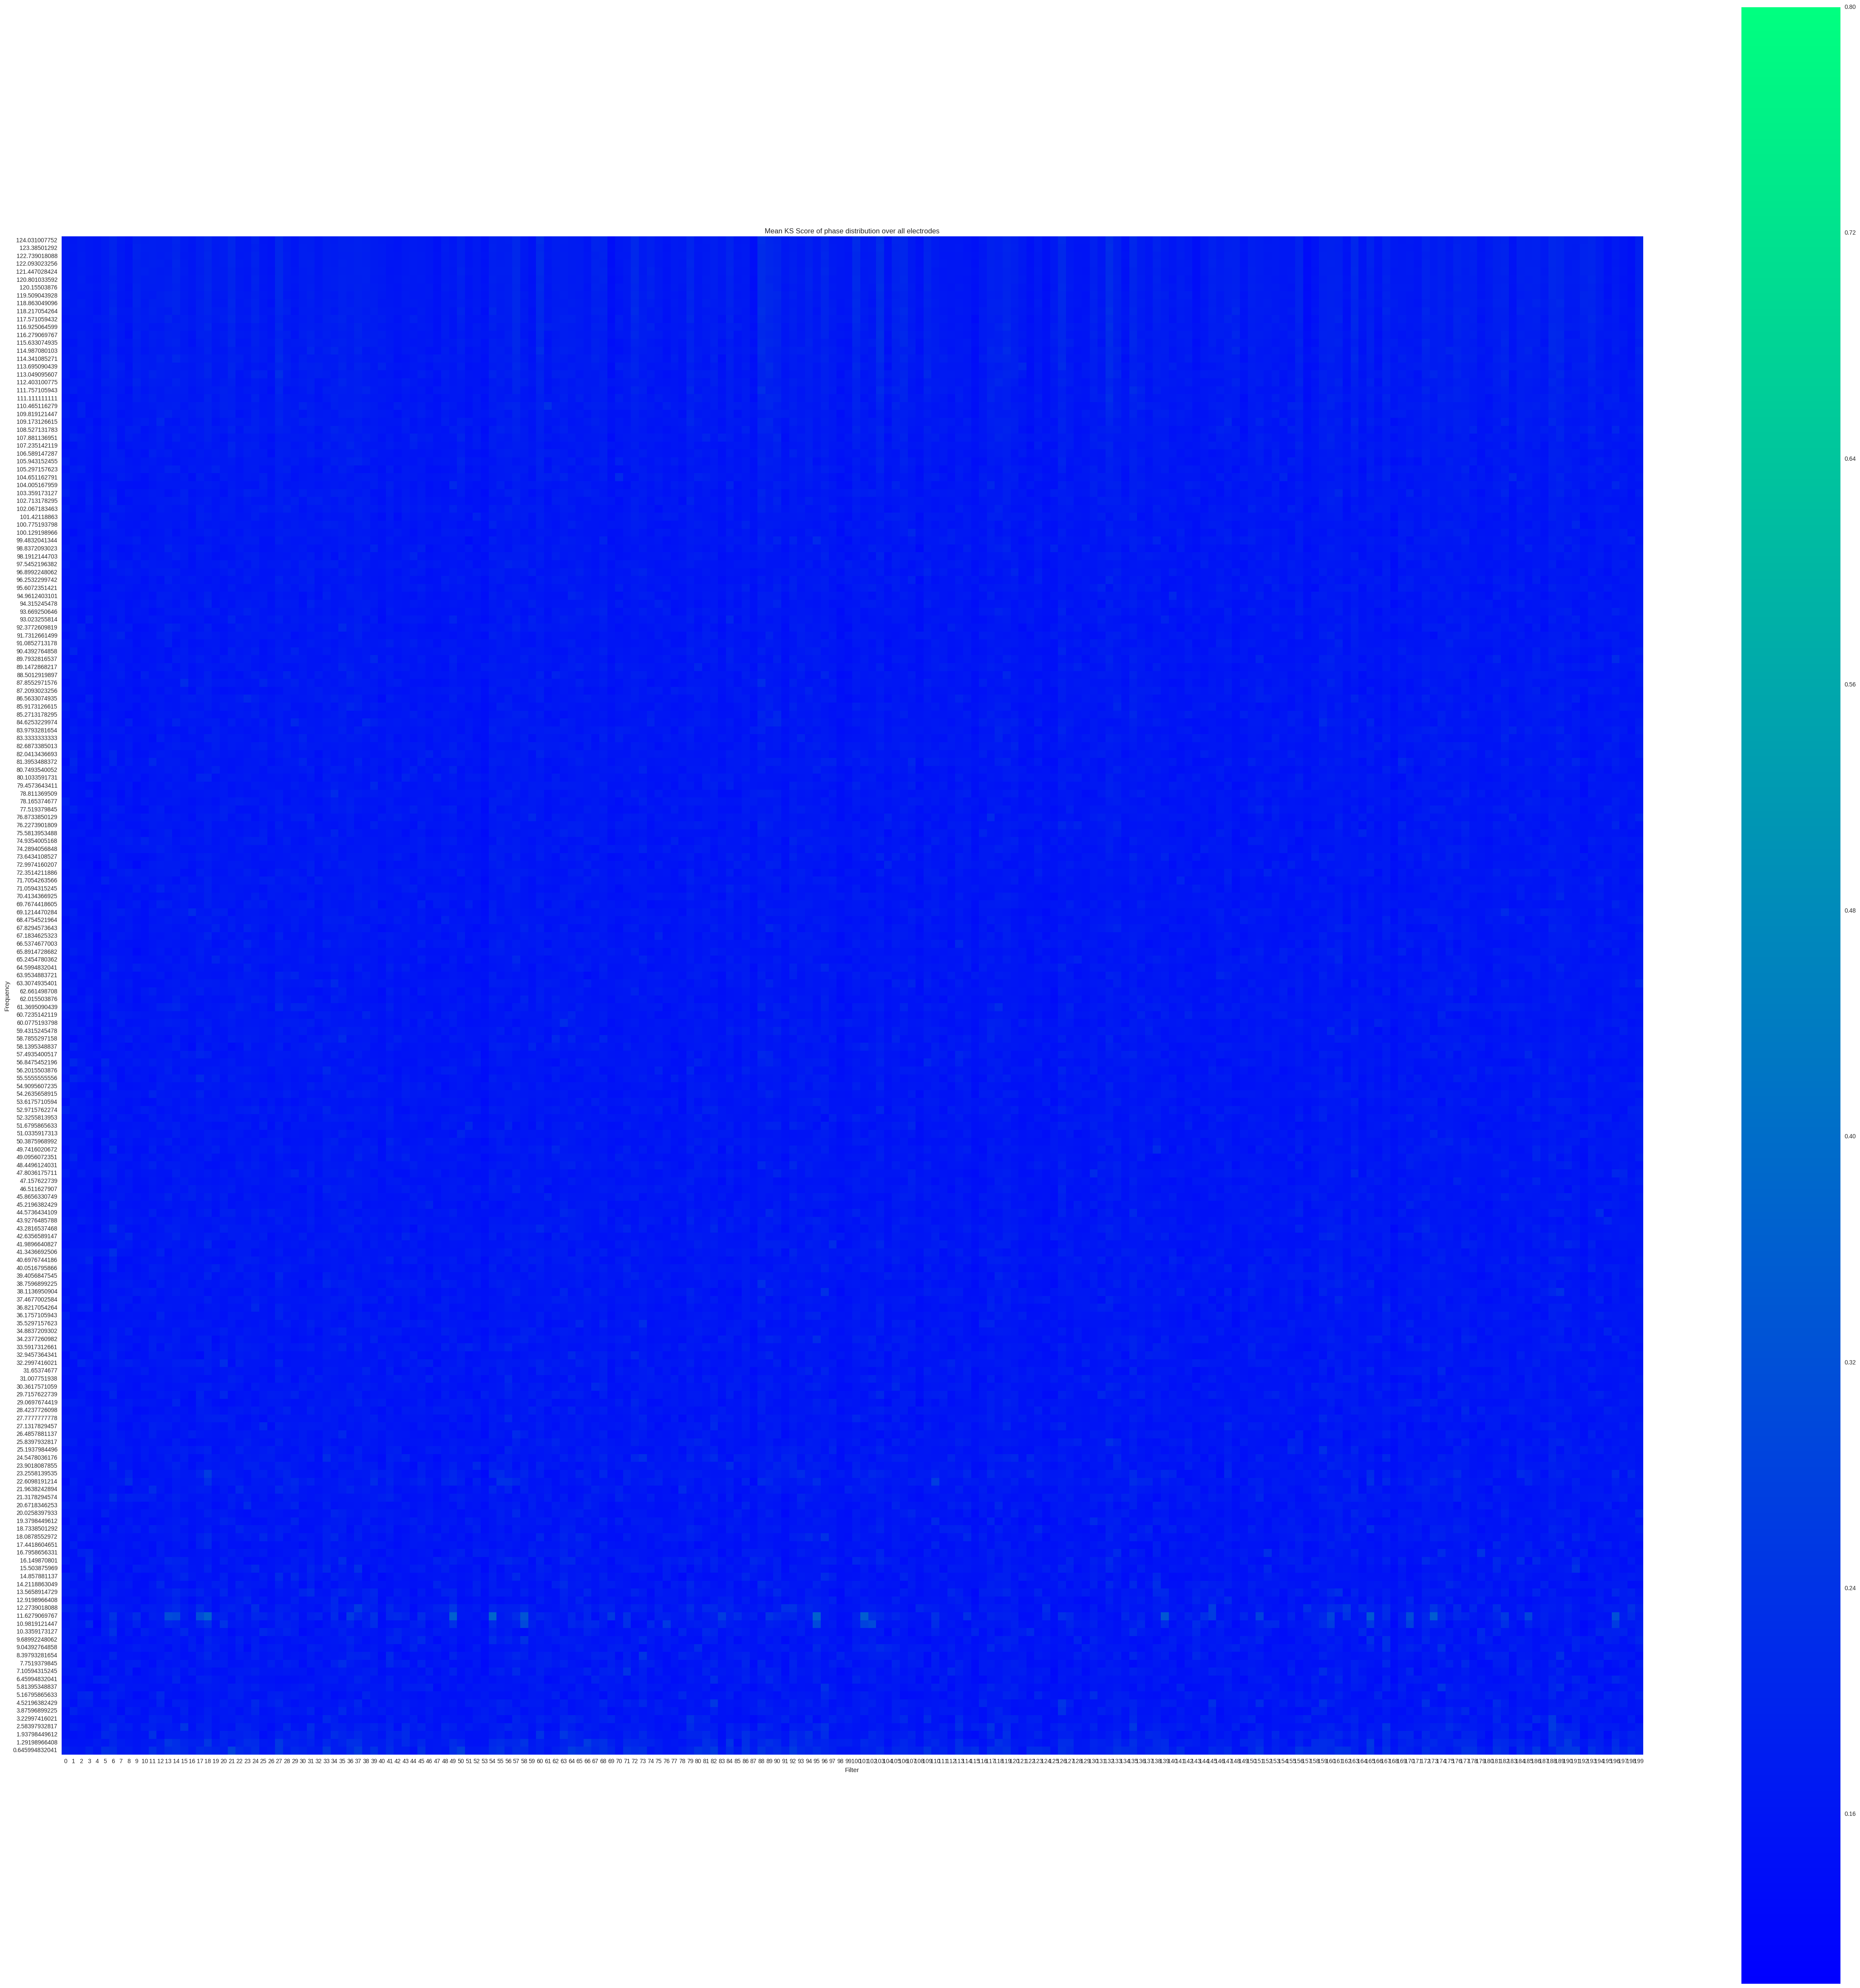

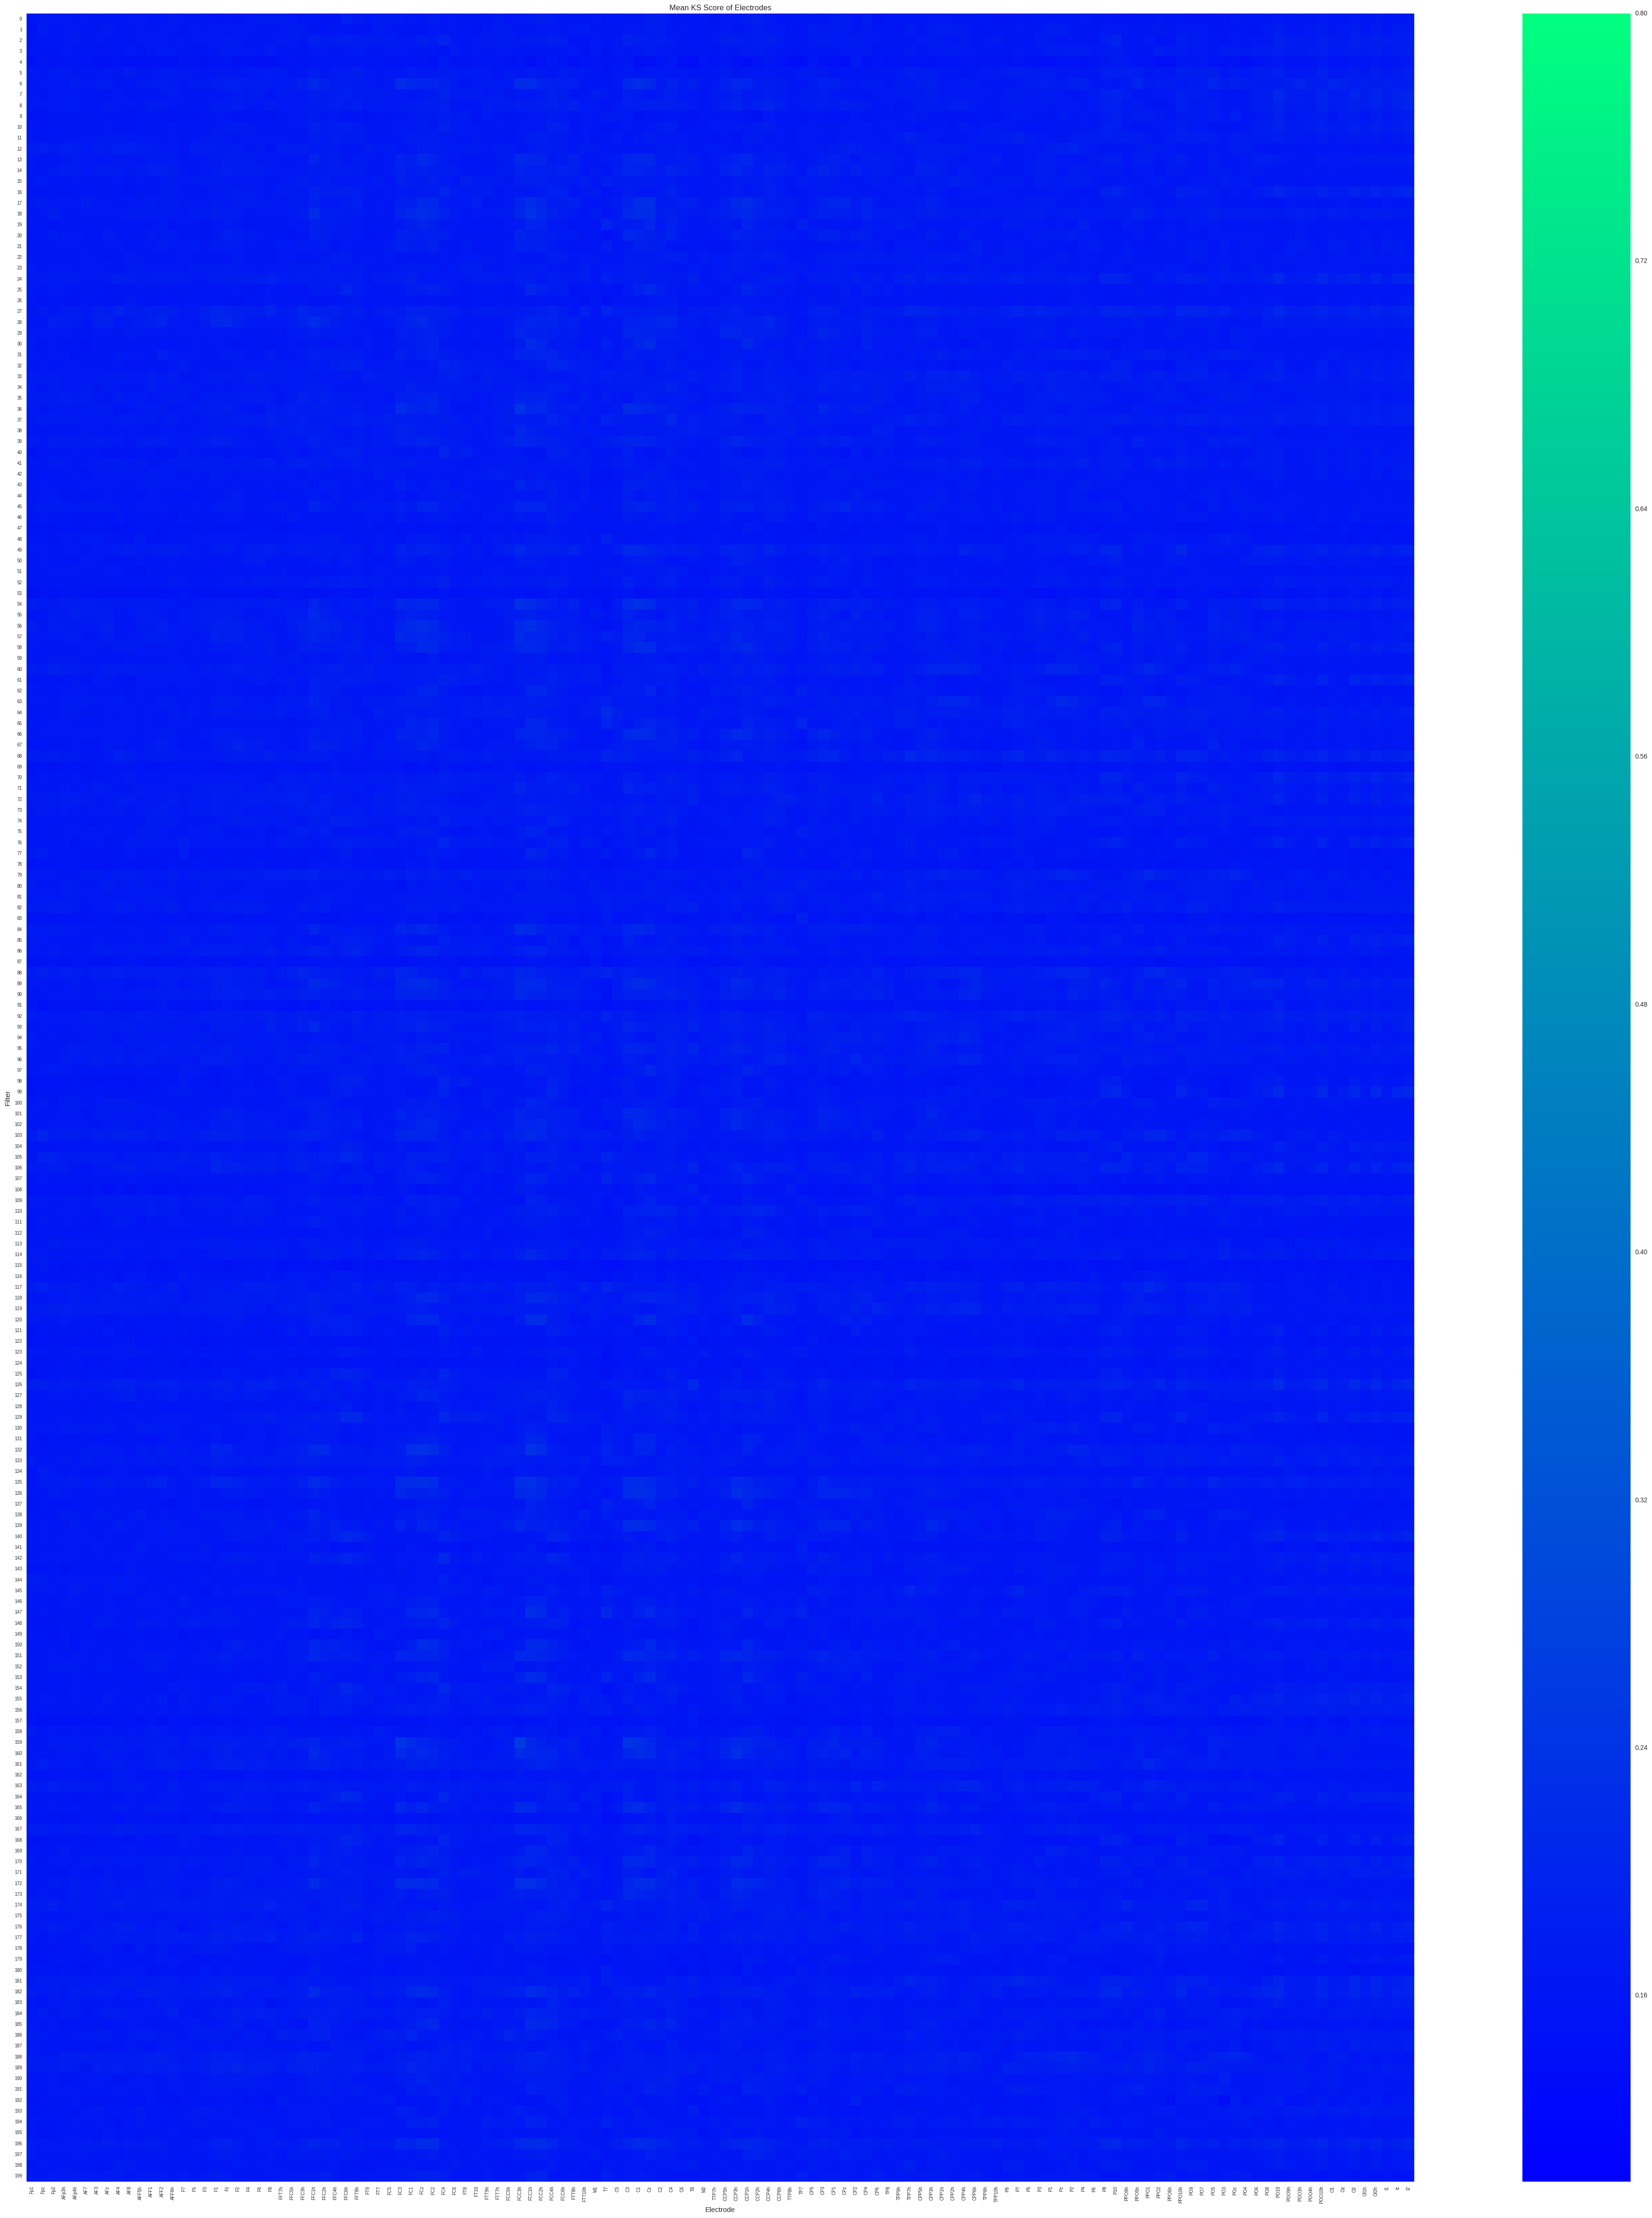

In [ ]:
make_plot(FFT_diff,Phase_diff,FFT_KS,Phase_KS,Electrode_KS,Electrode_KS_max,sensor_names,frequencies)